__The purpose of this notebook is to build an intuition for what the ocean looks like - what the boundaries are and what the physical properties of sea water are by exploring observational data.__ 

To examine the long-term average ocean properties observed in the global ocean we will use the World Ocean Atlas 18 gridded product ([Boyer et al., 2018](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18)) hosted by NOAA's National Centers for Environmental Information (NCEI) and based on data in the World Ocean Database (WOD).

From www.ncei.noaa.gov: _The World Ocean Atlas (WOA) is a collection of gridded, quality controlled temperature, salinity, oxygen, phosphate, silicate, and nitrate means on standard depth levels based on profile data from the World Ocean Database (WOD). It can be used to create boundary and/or initial conditions for a variety of ocean models, verify numerical simulations of the ocean, and corroborate satellite data._

The WOA is published semi-regulary since 1994 and is based off of the ground breaking Climatological Atlas of the World Ocean published by NOAA scientist Sydney Levitus in 1982 (while at NOAA's Geophysical Fluid Dynamics Laboratory). __The WOA is one of the most widely used datasets in oceanography and climate science__.

![](https://books.google.com/books/content?id=_x0IAQAAIAAJ&pg=PR1&img=1&zoom=3&hl=en&sig=ACfU3U1UpmEg019E4PriRYiyjSzvlagEDQ&w=1025)

##### The gridded WOA observational product is used for:
* the development and evaluation of ocean models.
* the development and evaluation of fully coupled climate models.
* providing __initial conditions__ for climate model simulations.
* verification of ocean surface properties against satellite observations.
* planning oceanographic expeditions and observational campaigns.
* assessing physical and biogeochemical properties in the ocean and their change.

#### Authors: Dr. Rebecca L. Beadling. For any questions regarding the contents of this notebook please contact rebecca.beadling@temple.edu.

#### Load in our packages, set up the notebook, and read in the data. Here we will load in WOA18 data and also the ETOPO5 land surface elevations and sea floor depth dataset.

In [1]:
import xarray as xr
import cmocean 
import matplotlib.pyplot as plt
import cftime
import numpy as np

In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6

In [3]:
woa18_data = xr.open_zarr('/home/tu.temple.edu/tut47217/Phys_ocean/physical_oceanography/data/woa18_full_decadal_ave_fields/')

etopo5_data = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/dods')
etopo5_data = etopo5_data.rename({'X': 'lon', 'Y': 'lat'})
etopo5_data['elev_ocean'] = etopo5_data.elev.where(etopo5_data.elev<0).load()
etopo5_data

<xarray.Dataset>
Dimensions:     (lon: 4320, lat: 2160)
Coordinates:
  * lon         (lon) float32 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
  * lat         (lat) float32 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
Data variables:
    elev        (lat, lon) int16 -4290 -4290 -4290 -4290 ... 2774 2774 2774 2774
    elev_ocean  (lat, lon) float32 -4.29e+03 -4.29e+03 -4.29e+03 ... nan nan nan
Attributes:
    dataset_documentation.html:  http://iridl.ldeo.columbia.edu/SOURCES/.NOAA...
    Conventions:                 IRIDL
    description:                 ETOPO5 5x5 minute land surface elevations an...

In [4]:
woa18_data

<xarray.Dataset>
Dimensions:   (depth: 102, lat: 180, lon: 360)
Coordinates:
  * depth     (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * lat       (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    nitrate   (depth, lat, lon) float32 dask.array<chunksize=(26, 45, 180), meta=np.ndarray>
    oxygen    (depth, lat, lon) float32 dask.array<chunksize=(26, 45, 180), meta=np.ndarray>
    salinity  (depth, lat, lon) float32 dask.array<chunksize=(26, 45, 180), meta=np.ndarray>
    temp      (depth, lat, lon) float32 dask.array<chunksize=(26, 45, 180), meta=np.ndarray>

In [5]:
etopo5_data

<xarray.Dataset>
Dimensions:     (lon: 4320, lat: 2160)
Coordinates:
  * lon         (lon) float32 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
  * lat         (lat) float32 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
Data variables:
    elev        (lat, lon) int16 -4290 -4290 -4290 -4290 ... 2774 2774 2774 2774
    elev_ocean  (lat, lon) float32 -4.29e+03 -4.29e+03 -4.29e+03 ... nan nan nan
Attributes:
    dataset_documentation.html:  http://iridl.ldeo.columbia.edu/SOURCES/.NOAA...
    Conventions:                 IRIDL
    description:                 ETOPO5 5x5 minute land surface elevations an...

#### Define variables of interest

In [6]:
temp = woa18_data.temp
salt = woa18_data.salinity
elev = etopo5_data.elev
elev_ocean = etopo5_data.elev_ocean

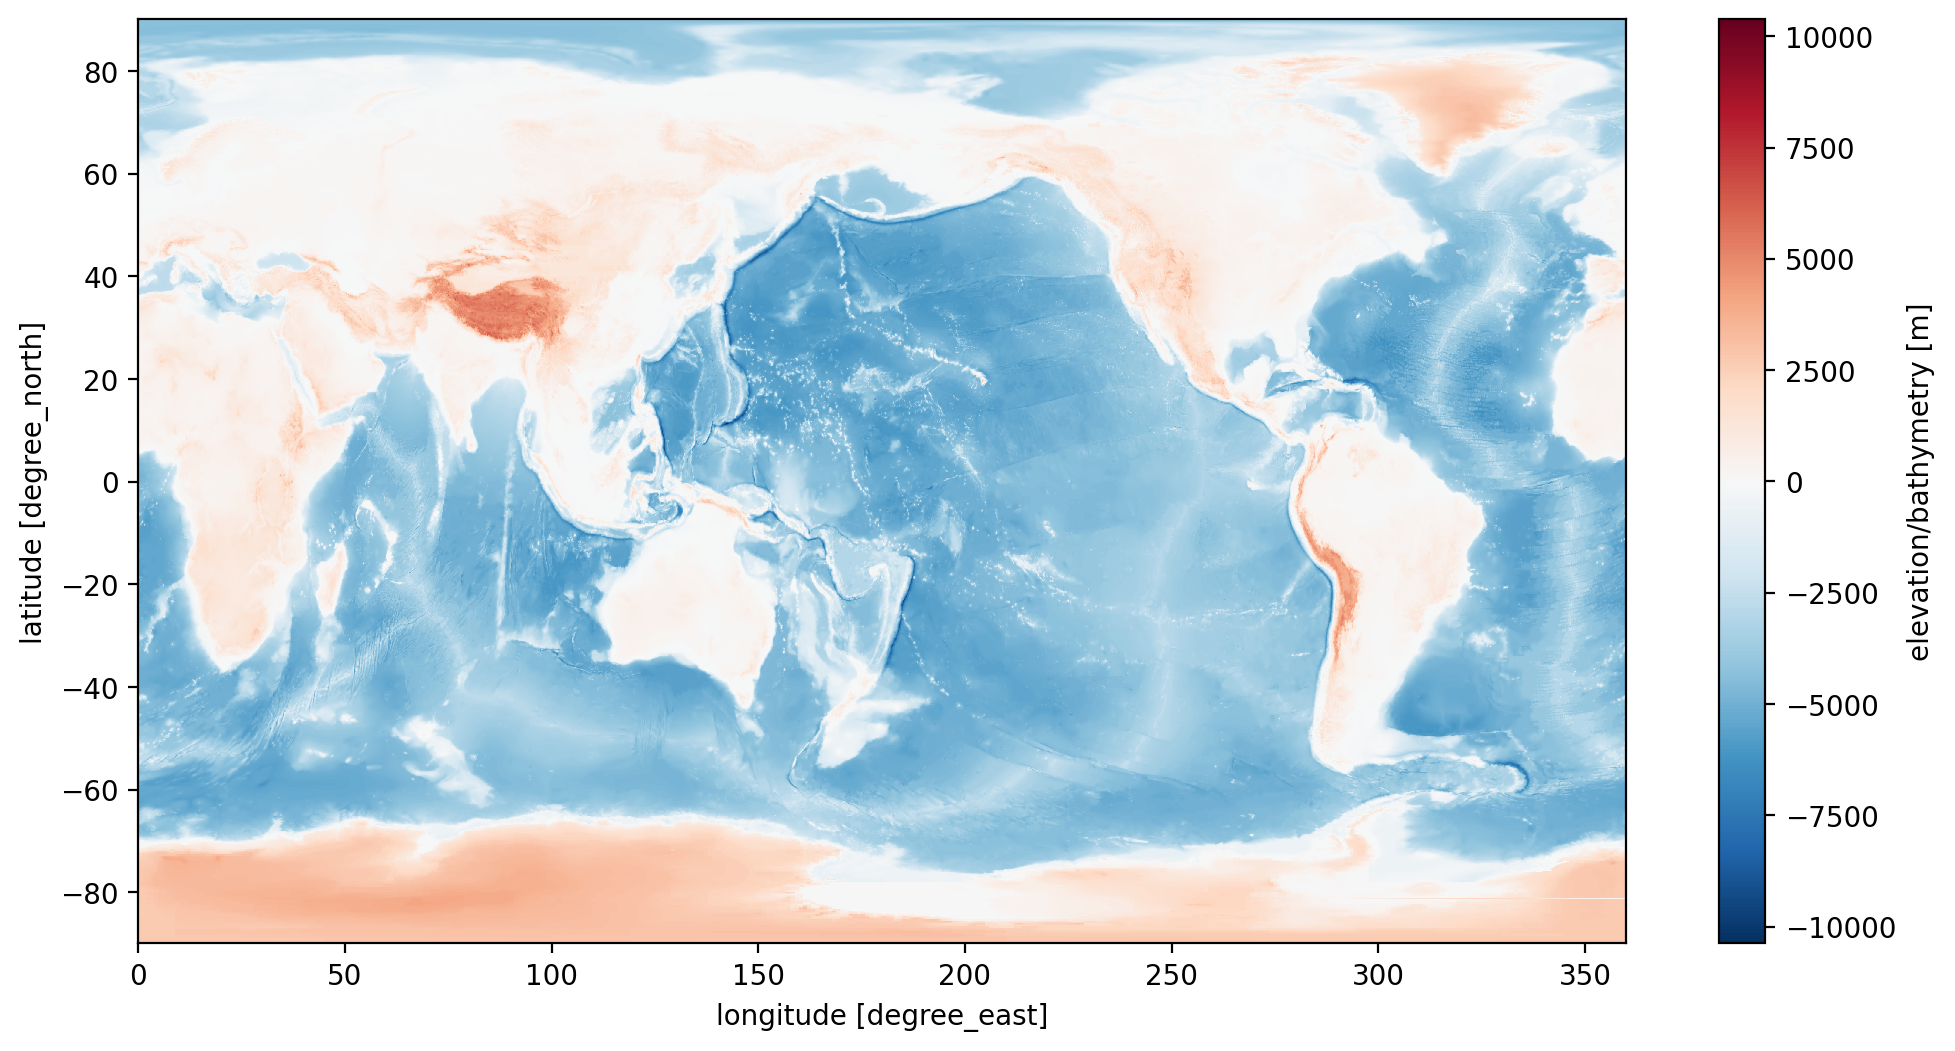

In [7]:
elev.plot()

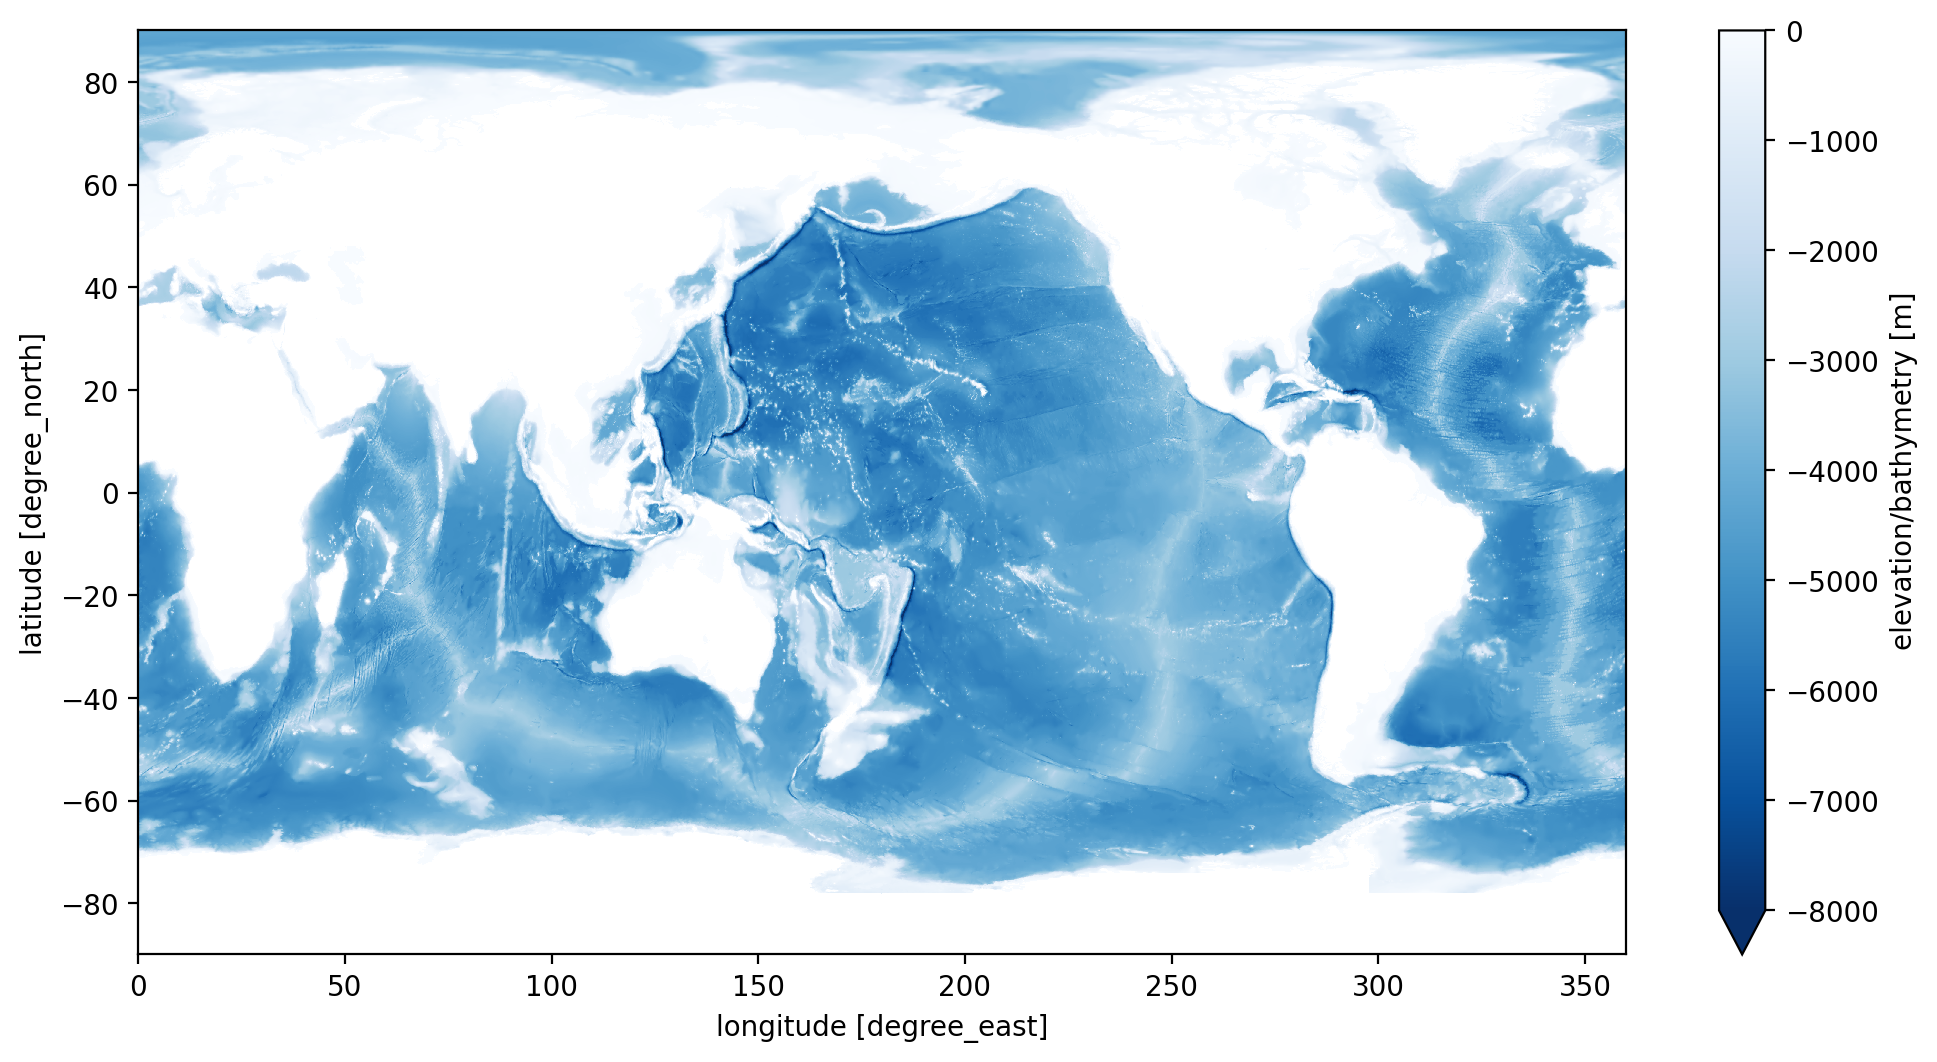

In [8]:
elev_ocean.plot(cmap='Blues_r',vmin=-8000,vmax=0)

#### I told you in lecture 2 that the ocean occupies ~71% of Earth's total surface area - is that true? What is Earth's surface area?

In [9]:
r_earth = 6371.0e3

In [10]:
SA_earth = 4*np.pi*(r_earth**2)

In [11]:
SA_earth

510064471909788.25

#### We can write a basic function to compute grid cell area in $m^2$ given a dataset's lat, lon coordinate label values.

In [12]:
# The following function is used to create weights for the Earths grid space.
import warnings 

def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

In [13]:
lat_elev = elev.coords['lat'].values #1-D numpy array of model's latitude values
lon_elev = elev.coords['lon'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_elev,lon_elev) 

In [14]:
# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original array:

areacell_xarray = xr.DataArray(areacell,dims=({'lat':2160, 'lon':4320}),\
                                                coords=(elev.coords['lat'],\
                                                        elev.coords['lon']))

In [15]:
areacell_xarray # is m^2

<xarray.DataArray (lat: 2160, lon: 4320)>
array([[6.55422786e-06, 6.55422786e-06, 6.55422786e-06, ...,
        6.55422786e-06, 6.55422786e-06, 6.55422786e-06],
       [1.24890632e+05, 1.24890632e+05, 1.24890632e+05, ...,
        1.24890632e+05, 1.24890632e+05, 1.24890632e+05],
       [2.49769567e+05, 2.49769567e+05, 2.49769567e+05, ...,
        2.49769567e+05, 2.49769567e+05, 2.49769567e+05],
       ...,
       [3.74659406e+05, 3.74659406e+05, 3.74659406e+05, ...,
        3.74659406e+05, 3.74659406e+05, 3.74659406e+05],
       [2.49781000e+05, 2.49781000e+05, 2.49781000e+05, ...,
        2.49781000e+05, 2.49781000e+05, 2.49781000e+05],
       [1.24890632e+05, 1.24890632e+05, 1.24890632e+05, ...,
        1.24890632e+05, 1.24890632e+05, 1.24890632e+05]])
Coordinates:
  * lat      (lat) float32 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
  * lon      (lon) float32 0.0 0.08333 0.1667 0.25 ... 359.7 359.8 359.8 359.9

#### If we sum up all of our gridcell areas, we should now arrive at a value close to our original surface area of the Earth we calculated above - is this correct?

In [16]:
SA_earth = areacell_xarray.sum(dim=['lat','lon'])
SA_earth

<xarray.DataArray ()>
array(5.10079881e+14)

#### Great, now lets isolate the area ONLY of the ocean:

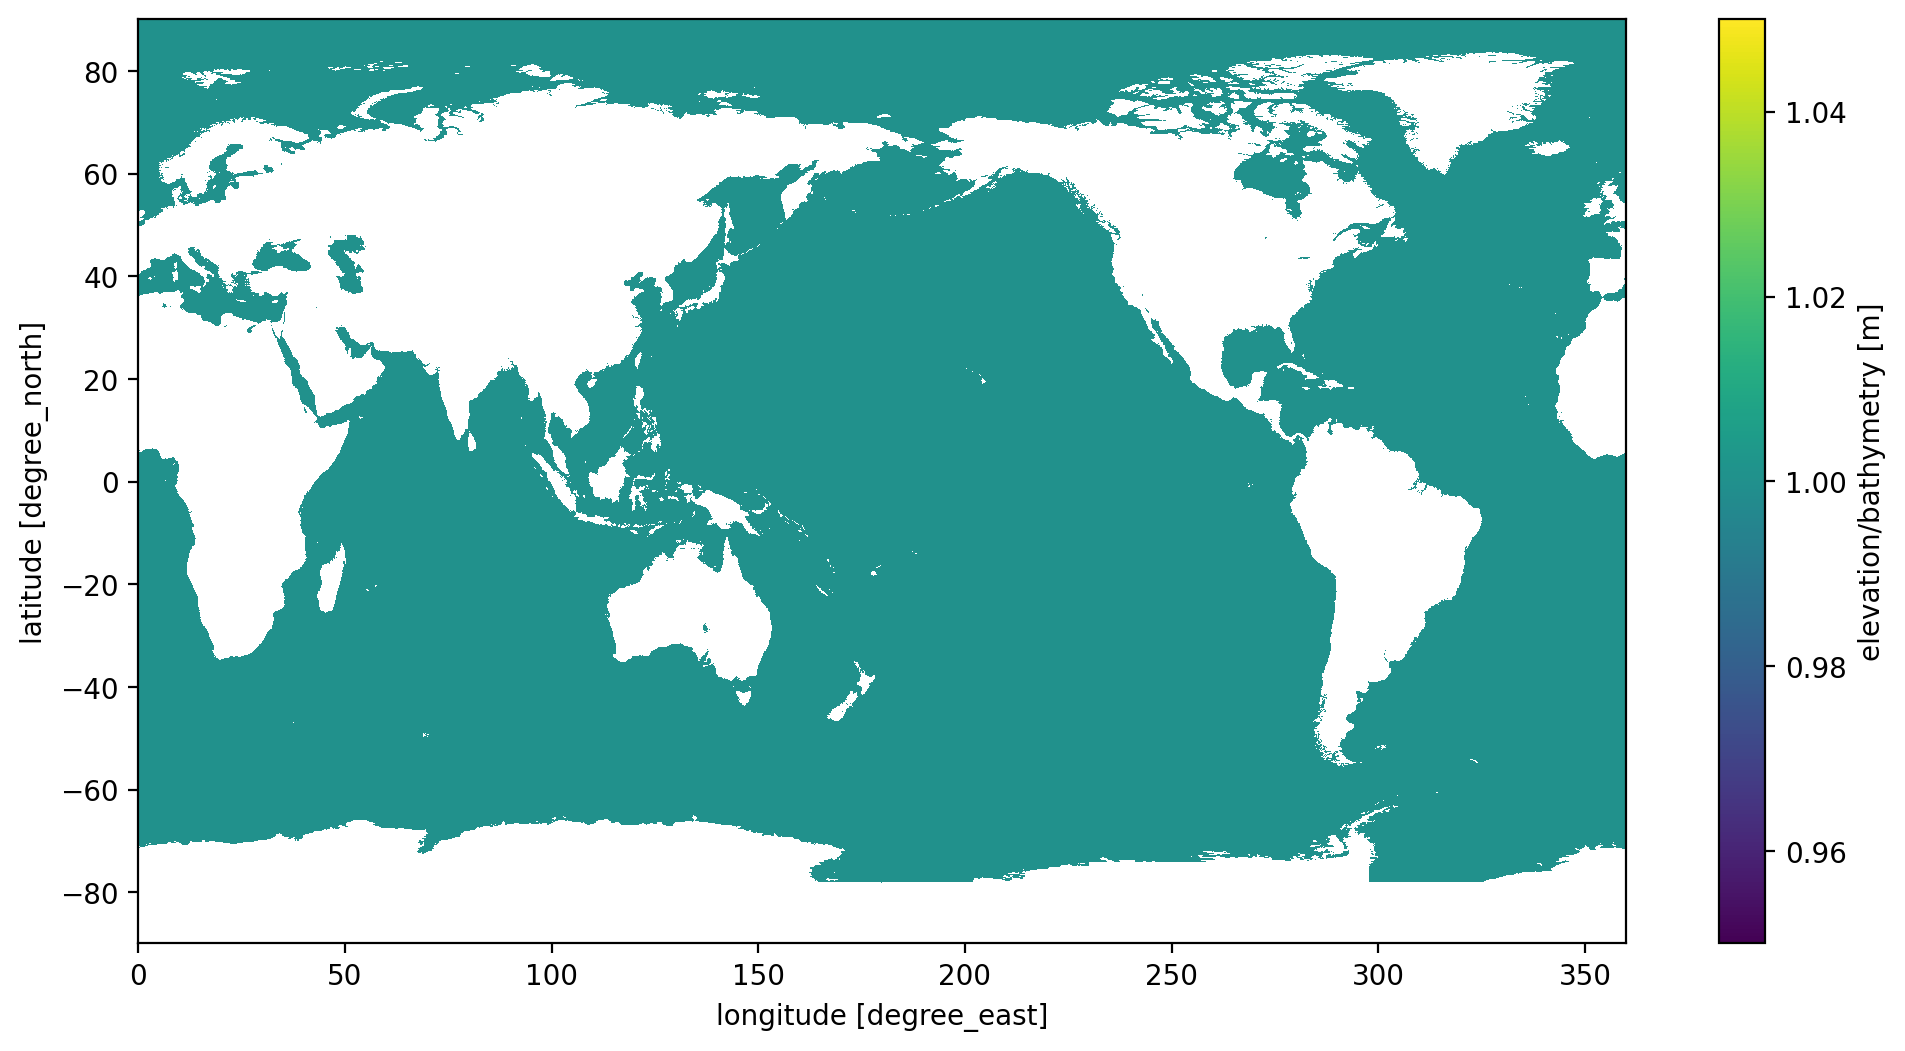

In [17]:
ocean_only = elev_ocean.where(elev_ocean.isnull(), 1)
ocean_only.plot()

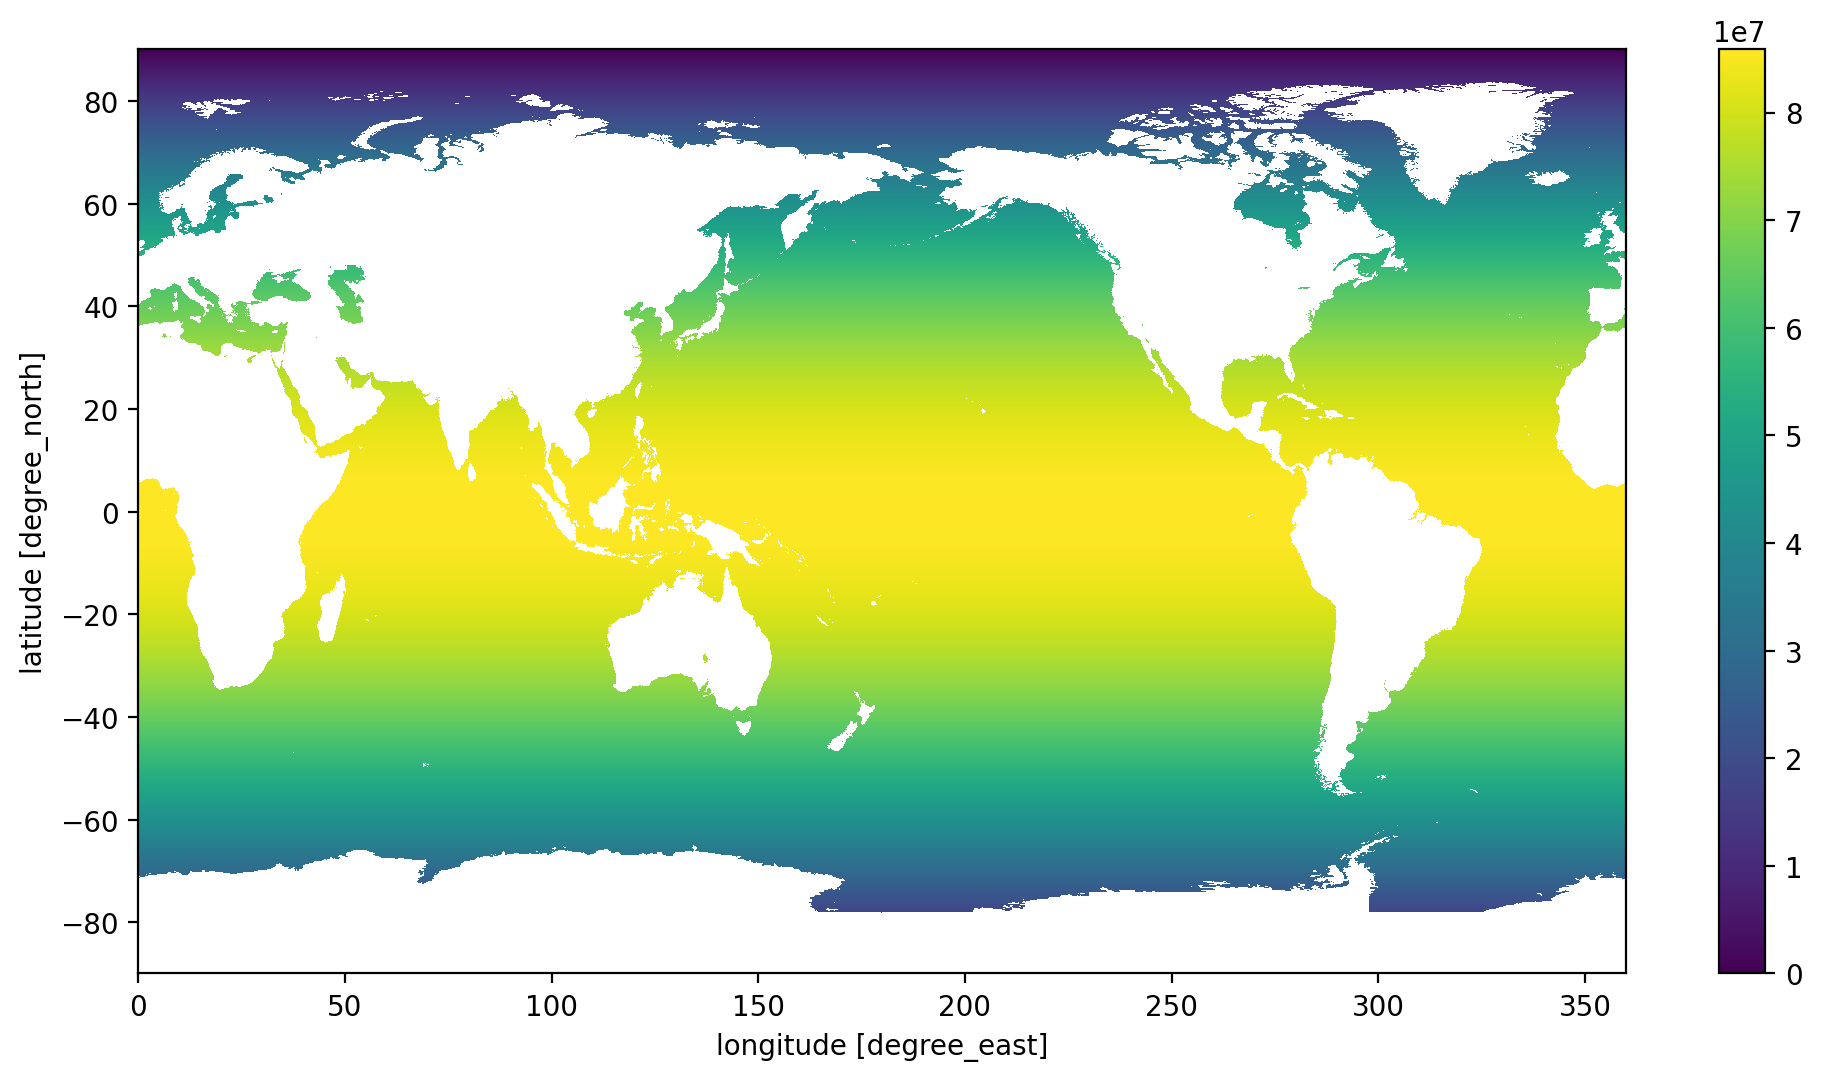

In [18]:
ocean_area = (areacell_xarray*ocean_only)
ocean_area.plot()

#### Compute the percent coverage of Earth's surface by the ocean:

In [19]:
ocean_coverage = (ocean_area.sum() / SA_earth)*100

In [20]:
ocean_coverage

<xarray.DataArray ()>
array(71.39352607)

#### Let's calculate some basic quantities using our ocean depth array

In [21]:
deepest = float(elev_ocean.min().values)
shallowest = float(elev_ocean.max().values)

weights = ocean_area.fillna(0)
average_depth = float(elev_ocean.weighted(weights).mean().values)
ocean_volume = float(elev_ocean.weighted(weights).sum().values*-1)

In [22]:
print('The deepest part of the ocean is', deepest, 'm')
print('The shallowest part of the ocean is', shallowest, 'm')
print('The average depth of the ocean is', average_depth, 'm')
print('The volume of the ocean is', ocean_volume, 'm')

The deepest part of the ocean is -10376.0 m
The shallowest part of the ocean is -1.0 m
The average depth of the ocean is -3674.6555473758563 m
The volume of the ocean is 1.3381773099938644e+18 m


#### How is depth distributed in the global ocean? Let's produce an area-weighted distribution of elevation everywhere.

(-8000.0, 6000.0)

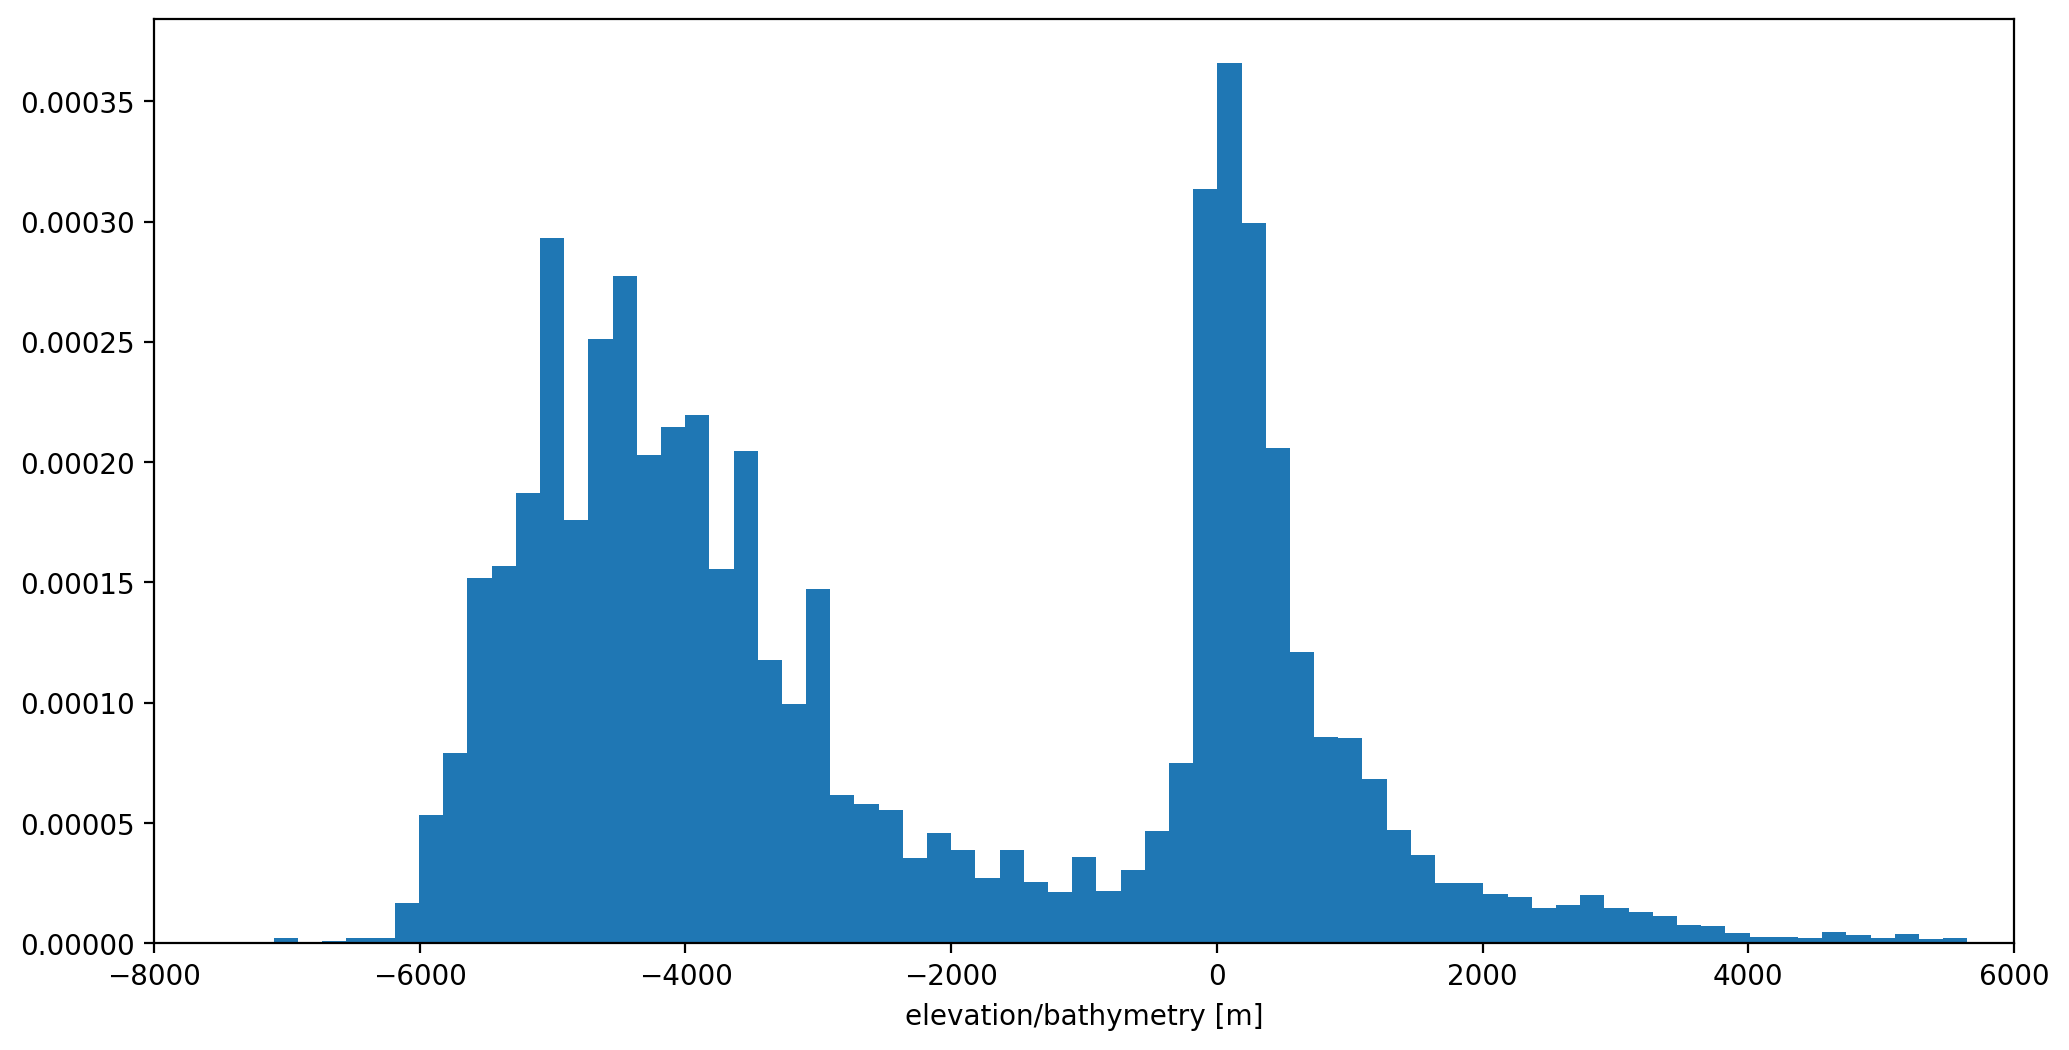

In [23]:
## Produce area-weighted distribution of elevation around the globe. The density=True normalizes
## it such that the total area under the curve (the histogram) sumes to 1.

fig, ax = plt.subplots()
elev.plot.hist(bins=100, weights=areacell_xarray.values.ravel(), density=True) ## count the number of depths that fall into 100 bins
ax.set_xlim([-8000,6000])

#### Great --- so that is what the ocean looks like spatially. There is much more you can do with this notebook, e.g, explore depth in a given ocean basin, etc.

#### Let's explore the __pressure, temperature, salinity, and density__ structure of the ocean.

WOA provides its data product on standard depth levels, not pressure. We can use the Gibbs SeaWater Oceanographic Toolbox python package (gsw) to convert depth to pressure. The gsw package uses the International Thermodynamic Equation of SeaWater - 2010 (TEOS-10). 

See here for a description of the gsw toolbox: https://teos-10.github.io/GSW-Python/

See here for the full description of TEOS-10: https://www.teos-10.org/pubs/gsw/pdf/TEOS-10_Manual.pdf



In [24]:
import gsw

In [25]:
help(gsw.p_from_z)

Help on function p_from_z in module gsw._fixed_wrapped_ufuncs:

p_from_z(z, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)
    Calculates sea pressure from height using computationally-efficient
    75-term expression for density, in terms of SA, CT and p (Roquet et al.,
    2015).  Dynamic height anomaly, geo_strf_dyn_height, if provided,
    must be computed with its p_ref = 0 (the surface). Also if provided,
    sea_surface_geopotental is the geopotential at zero sea pressure. This
    function solves Eqn.(3.32.3) of IOC et al. (2010) iteratively for p.
    
    Parameters
    ----------
    z : array-like
        Depth, positive up, m
    lat : array-like
        Latitude, -90 to 90 degrees
    geo_strf_dyn_height : array-like
        dynamic height anomaly, m^2/s^2
            Note that the reference pressure, p_ref, of geo_strf_dyn_height must
            be zero (0) dbar.
    sea_surface_geopotential : array-like
        geopotential at zero sea pressure,  m^2/s^2
    


In [26]:
gsw.p_from_z?

Signature: gsw.p_from_z(z, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)
Docstring:
Calculates sea pressure from height using computationally-efficient
75-term expression for density, in terms of SA, CT and p (Roquet et al.,
2015).  Dynamic height anomaly, geo_strf_dyn_height, if provided,
must be computed with its p_ref = 0 (the surface). Also if provided,
sea_surface_geopotental is the geopotential at zero sea pressure. This
function solves Eqn.(3.32.3) of IOC et al. (2010) iteratively for p.

Parameters
----------
z : array-like
    Depth, positive up, m
lat : array-like
    Latitude, -90 to 90 degrees
geo_strf_dyn_height : array-like
    dynamic height anomaly, m^2/s^2
        Note that the reference pressure, p_ref, of geo_strf_dyn_height must
        be zero (0) dbar.
sea_surface_geopotential : array-like
    geopotential at zero sea pressure,  m^2/s^2

Returns
-------
p : array-like, dbar
    sea pressure
    ( i.e. absolute pressure - 10.1325 dbar )


Notes
-----
Note

## <font color=purple> </font><br /><font color=purple> __Pressure__

In [27]:
depth = woa18_data.depth
pressure = (gsw.p_from_z(-depth, woa18_data.lat))#.rename({'depth':'pressure'})

ds_pressure = xr.Dataset()
ds_pressure["pressure"] = pressure
ds_pressure.pressure.sel(depth=1000,method='nearest')

<xarray.DataArray 'pressure' (lat: 180)>
array([1013.32094206, 1013.31766494, 1013.31111473, 1013.30129952,
       1013.28823143, 1013.27192658, 1013.2524051 , 1013.22969107,
       1013.20381253, 1013.17480138, 1013.14269343, 1013.10752827,
       1013.06934927, 1013.0282035 , 1012.98414167, 1012.93721809,
       1012.88749059, 1012.83502041, 1012.77987218, 1012.7221138 ,
       1012.66181637, 1012.59905409, 1012.53390418, 1012.46644674,
       1012.39676473, 1012.32494378, 1012.25107213, 1012.17524051,
       1012.09754202, 1012.01807203, 1011.93692802, 1011.85420951,
       1011.77001789, 1011.68445634, 1011.59762965, 1011.50964412,
       1011.42060745, 1011.33062853, 1011.23981741, 1011.14828506,
       1011.05614331, 1010.96350468, 1010.87048224, 1010.77718947,
       1010.68374016, 1010.59024819, 1010.49682748, 1010.4035918 ,
       1010.31065463, 1010.21812905, 1010.12612757, 1010.03476204,
       1009.94414345, 1009.85438188, 1009.76558627, 1009.67786437,
       1009.59132258, 1009.50606581, 1009.42219738, 1009.33981888,
       1009.25903005, 1009.17992868, 1009.10261046, 1009.02716889,
       1008.95369519, 1008.88227814, 1008.81300401, 1008.74595645,
       1008.68121641, 1008.61886201, 1008.55896848, 1008.50160805,
       1008.44684988, 1008.39475997, 1008.34540108, 1008.29883269,
       1008.25511087, 1008.21428828, 1008.17641406, 1008.14153381,
...
       1008.14153381, 1008.17641406, 1008.21428828, 1008.25511087,
       1008.29883269, 1008.34540108, 1008.39475997, 1008.44684988,
       1008.50160805, 1008.55896848, 1008.61886201, 1008.68121641,
       1008.74595645, 1008.81300401, 1008.88227814, 1008.95369519,
       1009.02716889, 1009.10261046, 1009.17992868, 1009.25903005,
       1009.33981888, 1009.42219738, 1009.50606581, 1009.59132258,
       1009.67786437, 1009.76558627, 1009.85438188, 1009.94414345,
       1010.03476204, 1010.12612757, 1010.21812905, 1010.31065463,
       1010.4035918 , 1010.49682748, 1010.59024819, 1010.68374016,
       1010.77718947, 1010.87048224, 1010.96350468, 1011.05614331,
       1011.14828506, 1011.23981741, 1011.33062853, 1011.42060745,
       1011.50964412, 1011.59762965, 1011.68445634, 1011.77001789,
       1011.85420951, 1011.93692802, 1012.01807203, 1012.09754202,
       1012.17524051, 1012.25107213, 1012.32494378, 1012.39676473,
       1012.46644674, 1012.53390418, 1012.59905409, 1012.66181637,
       1012.7221138 , 1012.77987218, 1012.83502041, 1012.88749059,
       1012.93721809, 1012.98414167, 1013.0282035 , 1013.06934927,
       1013.10752827, 1013.14269343, 1013.17480138, 1013.20381253,
       1013.22969107, 1013.2524051 , 1013.27192658, 1013.28823143,
       1013.30129952, 1013.31111473, 1013.31766494, 1013.32094206])
Coordinates:
    depth    float32 1e+03
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    axis:           Z
    bounds:         depth_bnds
    positive:       down
    standard_name:  depth
    units:          meters

#### What is the pressure at 1000 m depth at a given latitude, let's choose the equator. Is it equal to 1000 ?

In [28]:
ds_pressure.pressure.sel(depth=1000,method='nearest',lat=0) # dbar is convinent (pascal to bar)

<xarray.DataArray 'pressure' ()>
array(1007.96479084)
Coordinates:
    depth    float32 1e+03
    lat      float32 0.5
Attributes:
    axis:           Z
    bounds:         depth_bnds
    positive:       down
    standard_name:  depth
    units:          meters

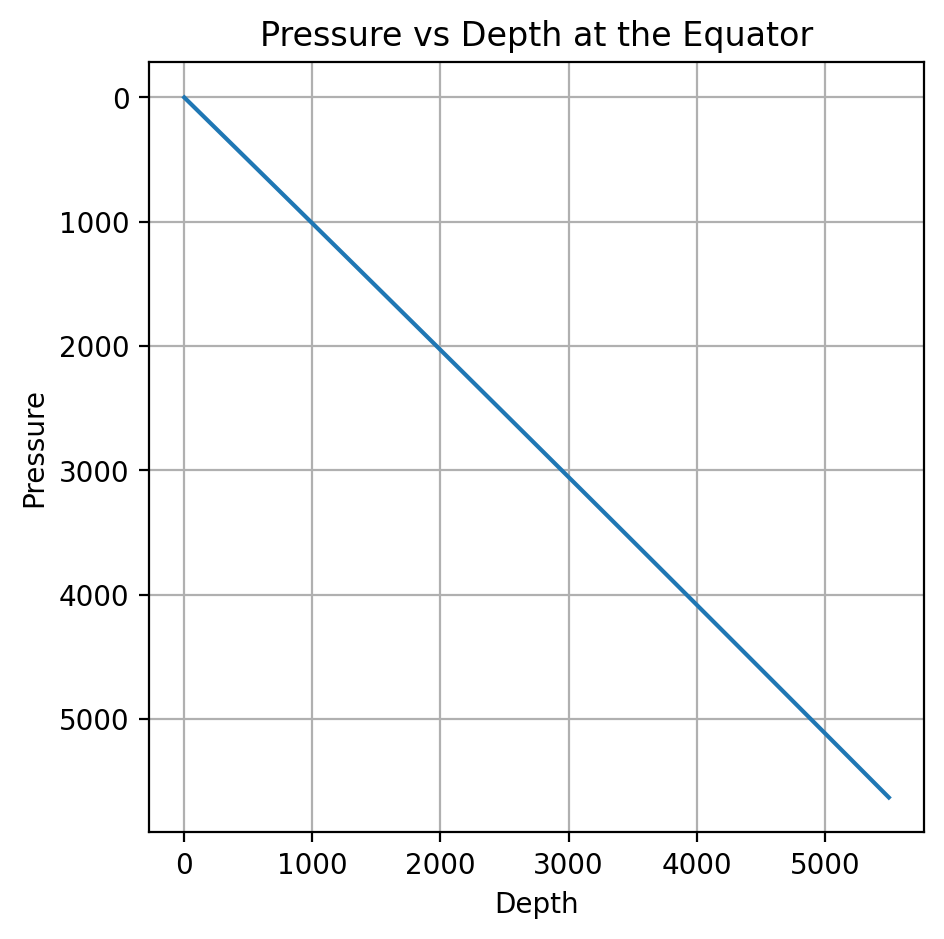

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
ds_pressure.pressure.isel(lat=0).plot(ax=ax)

plt.xlabel('Depth')
plt.ylabel('Pressure')
plt.gca().invert_yaxis()  # Optional: if you want depth increasing downward (common in geoscience)
plt.title('Pressure vs Depth at the Equator')
plt.grid(True)
plt.show()

#### <font color=red> Why is depth not equal to pressure? For a given latitude, explore the nature of this divergence as a function of depth in the water column. What do you notice? What's the explanation?

#### A. 
#### Depth is only dependent on distance which will not be changed by where it is on the Earth. 
#### But pressure is force per area, this means if the mass within an area changes the pressure will change. The gravitional pull on a sphere is different at different latitudes which will change the mass within an area changing the pressure. 

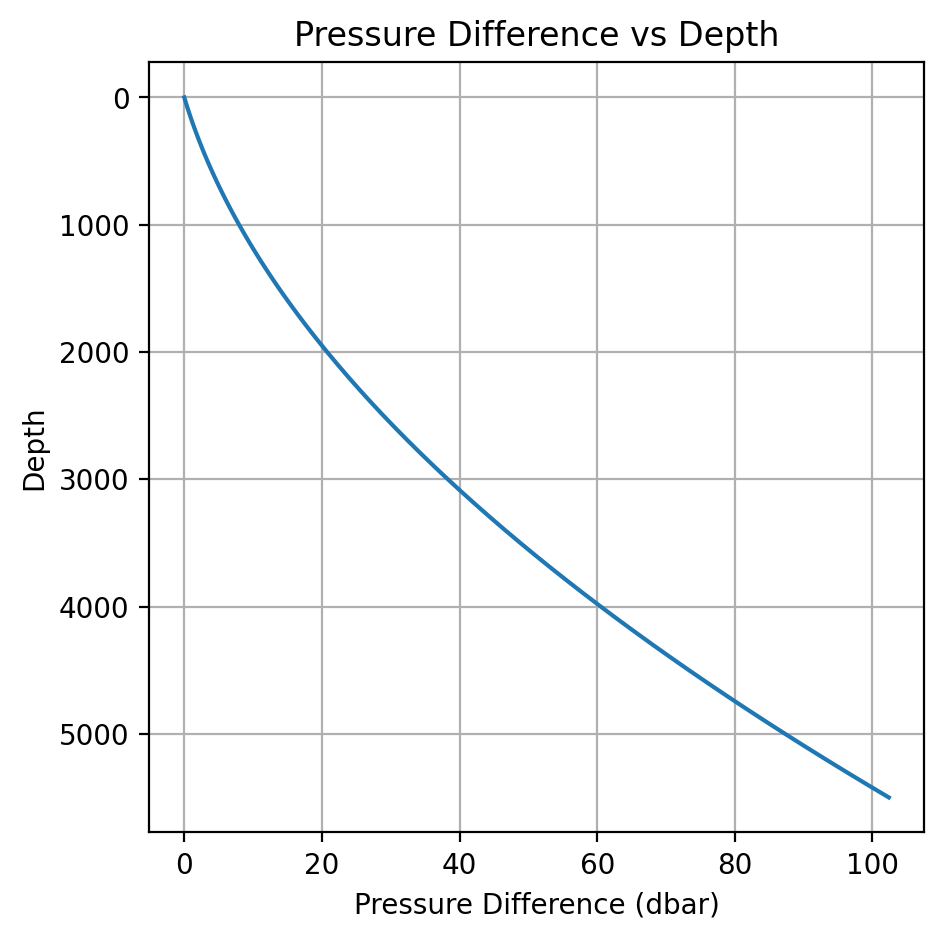

In [30]:
pressure_eq = ds_pressure.pressure.sel(method='nearest',lat=0)
depth = ds_pressure.depth

difference = pressure_eq - depth

fig, ax = plt.subplots(figsize=(5,5))

plt.plot(difference, depth)
plt.xlabel('Pressure Difference (dbar)')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  
plt.title('Pressure Difference vs Depth')
plt.grid(True)

#### Recall that the relationship of **hydrostatic balance** is given by the following equation which states that the pressure at a given depth ($z$) is a function of the mass of water (or air in the case of the atmosphere) above it:


$$
p(z) = g \int_z^0 \rho(z') \, dz'
$$

$$
\frac{\partial p}{\partial z} = - \rho g
$$

#### where:

- \( $p$ \) is pressure at a given depth (or height),
- \( $z$ \) is the vertical height,
- \( $\rho$) is the sea water density,
- \( $g$ \) is the acceleration due to gravity.

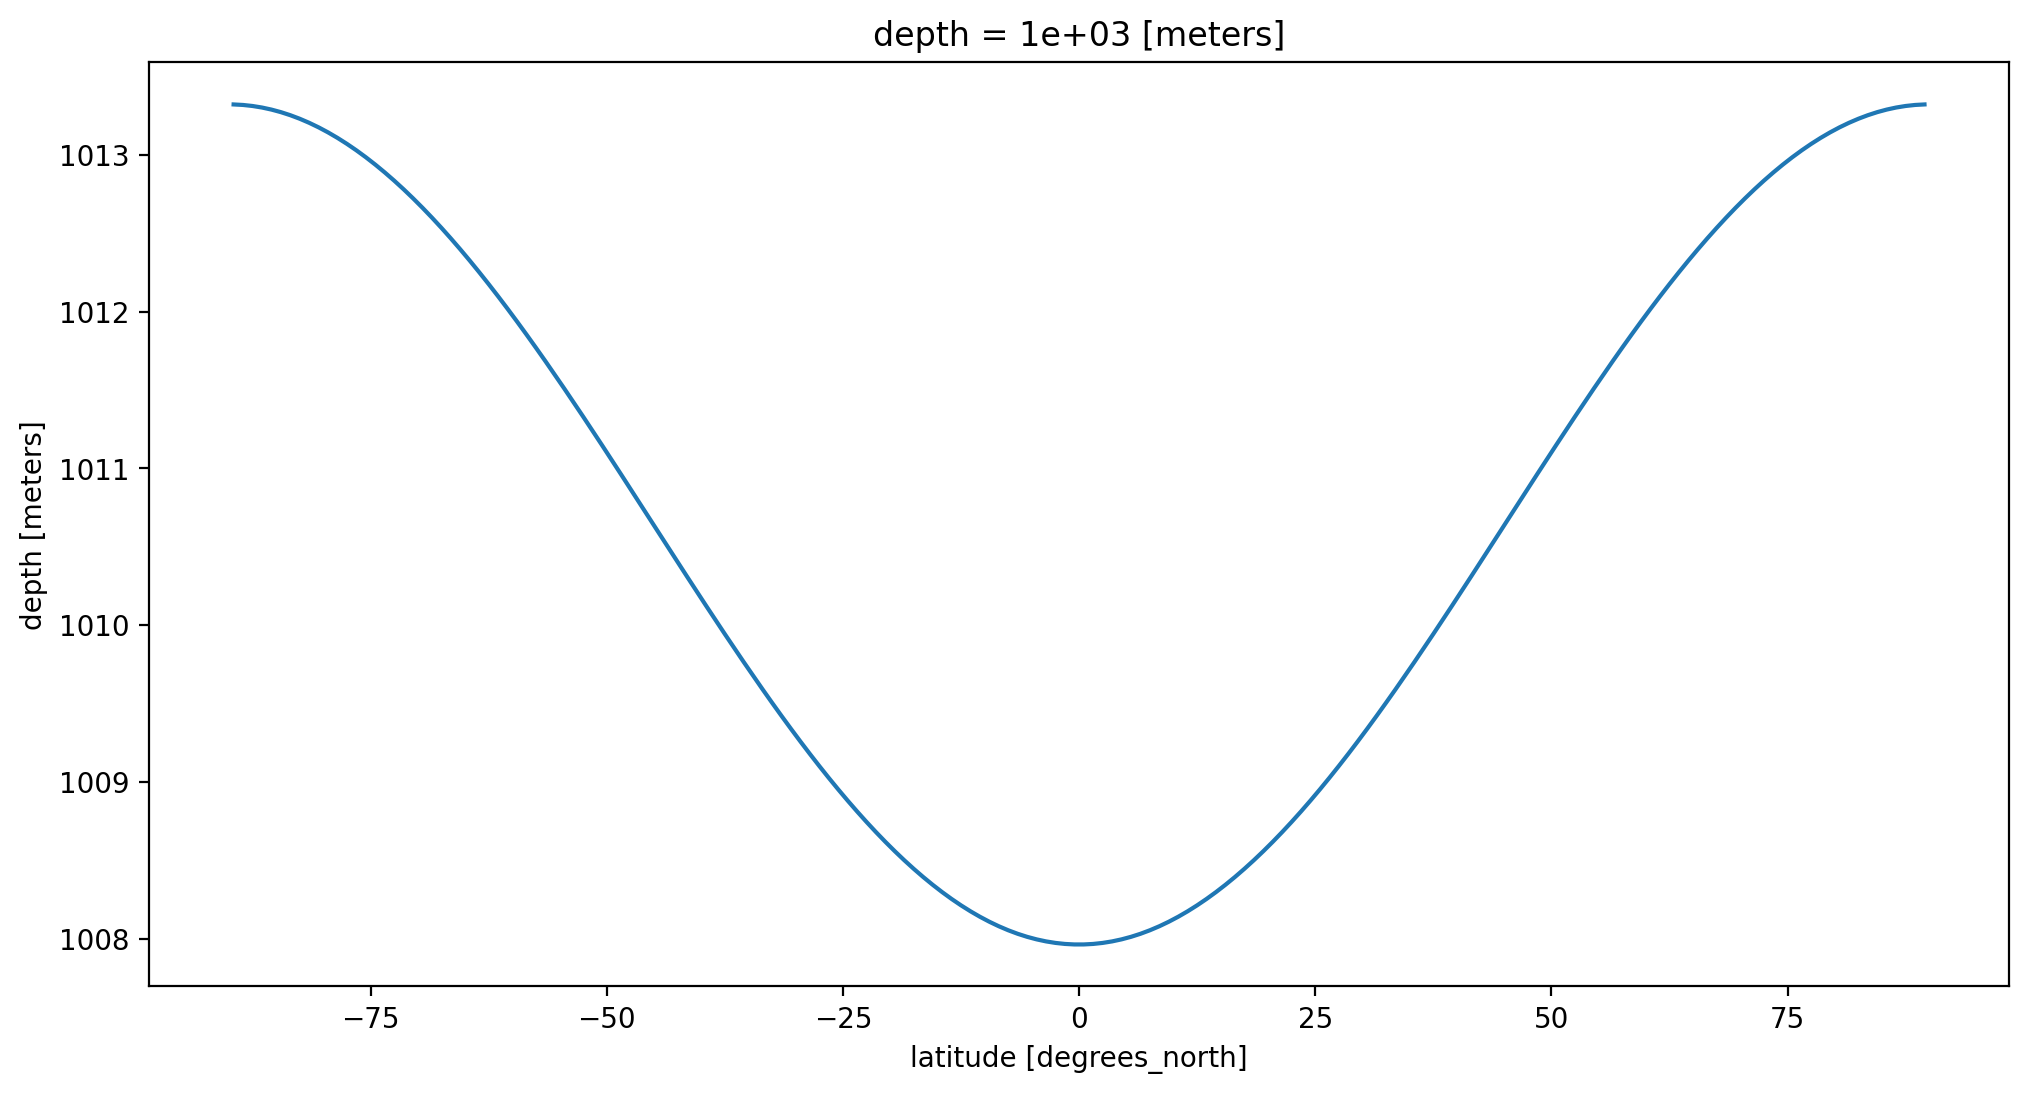

In [31]:
ds_pressure.pressure.sel(depth=1000).plot()

#### <font color=red> </font><br /><font color=red> Why does the deviation of pressure from depth vary with respect to latitude? The difference is smallest at the equator, but gets larger toward the poles. Why?</font><br />

The equation below is the one that is being solved by the `gsw.p_from_z` function (see https://www.teos-10.org/pubs/TEOS-10_Manual.pdf).

$$
h^{75} \bigl( S_{SO}\, , 0^\circ \mathrm{C}, p \bigr) - \Psi - \Phi^0 + g(\phi,0)( z - \frac{1}{2} \gamma z^2) = 0.
$$

#### __A.__ As seen in the gsw.p_from_z fuction the gravity term is dependent on the latitude. The difference at the equator is small because of the earth's rotation which generates a centrifugal force that counteracts gravity. The centrifugal force's strength depends on the radius of the rotating object. The Earth's radius is largest at the equator and is smallest at the poles. Therefore, the counter-acting force is less at the poles than at the equator. 

## <font color=purple> </font><br /><font color=purple> __Temperature__

#### Now we'll explore the temperature structure of the global ocean. 

Temperature is a __thermodynamic property of a fluid__, due to the activity or energy of molecules and atoms within the fluid. It is related  to __heat__ via the quantity of __specific heat__ ($c_p$)

#### There are three forms of temperature that you will encounter in oceanography defined below:

__1. In-situ temperature__: this is the __actual measured temperature__ of a parcel of water at a certain depth in the ocean. In-situ temperature of a parcel is NOT conserved as the parcel moves adiabatically (without exchange of heat) throughout the water column due to the fact that seawater is __compressible__. Thus, in-situ temperature includes the effects of pressure on temperature. A parcel that is raised adiabatically from some depth to the surface will undergo a __decrease__ in pressure and thus its in-situ temperature will change as a result. In this case, the parcel will __cool__ relative to its in-situ temperature in its original location at depth due to a decrease in internal energy associated with the decompression. The opposite will be true for a parcel that is lowered adiabatically through the water column.

---

__2. Potential temperature ($\theta$)__: this measure of temperature is defined as the temperature that a water parcel would have if moved adiabatically to another pressure level (_the reference pressure_) with no change in salinity. Thus, potential temperature is __insensitive to the effects of pressure__, allowing one to compare temperatures of water parcels at different depths in the ocean.

Potential temperature is defined by Equation 26 of [Fofonof 1985](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/JC090iC02p03332) by:

<div style="text-align: center; font-size: 20px;">
$
\theta(S,T,p,p_{ref}) = T + \int_{p}^{p_{ref}} \Gamma(S, T, p) \, dp
$
</div>

#### where:

- \( $\theta$ \) is potential temperature
- \( $T$ \) is the in-situ temperature at pressure $p$
- \( $S$ \) is the salinity at pressure $p$
- \( $p$) is the in-situ pressure
- \( $p_{ref}$) is the reference pressure that the parcel is being "raised" to.
- \($\Gamma(S, T, p)$) is the __adiabatic lapse rate__ which is a function of salinity, temperature, and pressure.

----

__3. Conservative temperature ($\Theta$)__: this measure of temperature reflects a parcel's total heat content, taking the pressure effects noted above into account by computing temperature as a function of a parcel's __sea water specific potential enthalpy__ ($h_0$). It is defined as:

<div style="text-align: center; font-size: 20px;">
$
\Theta = \frac{h_0}{c_p^0}
$
</div>

where $h_0$ is a parcel's specific potential enthalpy, and $c_p^0$ is a fixed value of the specific heat capacity of sea water, namely cp_0 = 3991.86795711963 J kg-1 K-1.

Specific enthalpy is defined as $h = U + PV$, with units of J/Kg. A change in $h$
is equal to the change in the internal energy of the system ($u$) (thermal and chemical), plus the pressure work ($PV$) that the system does on its surroundings (compressibility), at constant pressure.

Potential specific enthalpy ($h_0$) in the equation for conservative temperature ($\theta$) is the enthalpy that a parcel of water would have if brought adiabatically to surface pressure. 

Because $\theta$ is a function of a parcel's potential enthalpy, this measure of temperature is __conserved__ as a fluid parcel moves throughtout the ocean. __Conservative temperature is a more accurate measurement of the true "heat content" of water.__

See [here](https://www.teos-10.org/pubs/gsw/v3_04/pdf/Getting_Started_Conservative_Temperature.pdf) for a discussion on Conservative vs. Potential Temperature.

See [here](https://journals.ametsoc.org/view/journals/phoc/33/5/1520-0485_2003_033_0945_peacov_2.0.co_2.xml) for the mathematical proof by Trevor McDougall that Conservative temperature ($\Theta$) is more conservative than potential temperature:

> "These results prove that potential enthalpy is the quantity whose advection and diffusion is equivalent to advection and diffusion of “heat” in the ocean. That is, it is proven that to very high accuracy, the first law of thermodynamics in the ocean is the conservation equation of potential enthalpy. It is shown that potential enthalpy is to be preferred over the Bernoulli function. A new temperature variable called “conservative temperature” is advanced that is simply proportional to potential enthalpy. It is shown that present ocean models contain typical errors of 0.1°C and maximum errors of 1.4°C in their temperature because of the neglect of the nonconservative production of potential temperature"

#### World Ocean Atlas provides gridded in-situ temperature for the the global ocean. We can convert in-situ to conservative and potential temperature and explore these relationships using real data. First let's explore these relationships for a single parcel:

In [32]:
# Example for a single point, assigning values

S = 38.0         # Absolute Salinity in g/kg
T = 10.0         # In-situ temperature in °C
p = 2000.0       # In-situ pressure in dbar
p_ref = 1000      # Reference pressure in dbar (e.g. surface) # look at 2000

poto_temp = gsw.pt_from_t(S, T, p, p_ref) # Convert in-situ to potential temperature
cons_temp = gsw.CT_from_t(S, T, p)        # Convert in-situ to conservative temperature


T, poto_temp, cons_temp

(10.0, 9.863261218415829, 9.677429919404045)

#### <font color=red> </font><br /><font color=red> What are the relationships between the three temperatures returned? Explore what happens when you change the individual values one by one in the example above, write down your observations.</font><br />

#### The temps from the original numbers:
#### T = 10
#### Pot_temp = 9.74
#### Cons_temp = 9.68
#### We can see than both the pot temp and the cons temp are cooler than the in situ temp - 

#### when the p=1000 (all else is the same)
#### T = 10
#### Pot_temp = 9.88 -> changes (increase)
#### Cons_temp = 9.81 -> changes (increase)
#### both pot temp and the cons temp change when at differnt pressure levels 

#### when the p_ref=1000 (all else is the same)
#### T = 10
#### Pot_temp = 9.86 -> changes (increase)
#### Cons_temp = 9.81 -> no change
#### Only the pot temp changes when the reference level is changed.

#### these observations make sense as cons temp only takes into account the internal energy which will change based on pressure but not the refernce level.

#### Let's "displace" a parcel of water. What happens to in-situ temperature, potential temperature, and conservative temperature?

In [33]:
T_insitu_0 = 10                                # initial in-situ temperature, degrees C
p0 = 0                                         # initial pressure, dbar
S = 35                                         # initial salinity
ct0 = gsw.CT_from_t(S,T_insitu_0,p0)           # calculate initial conservative temperature


## Lower the parcel from the surface to 4000 db
p = 4000                                       # new pressure
T = gsw.t_from_CT(S,ct0,p)                     # new temperature

print(f'Initial temp: {T_insitu_0:.3f}, conservative temp: {ct0:.3f}')
print(f'Final   temp: {T:.3f}, conservative temp: {ct0:.3f}')

Initial temp: 10.000, conservative temp: 9.993
Final   temp: 10.562, conservative temp: 9.993


#### Once again this proves that conservative temp does not change based on the refrence level while the pot temperature will.

#### Convert WOA18 temperature field into different temperature quantities:

In [34]:
p_ref = 0.0
ds_pressure.pressure

in_situ_T = woa18_data.temp
salt = woa18_data.salinity

poto_temp = gsw.pt_from_t(salt, in_situ_T, ds_pressure.pressure, p_ref) # Convert in-situ to potential temperature
cons_temp = gsw.CT_from_t(salt, in_situ_T, ds_pressure.pressure) # Convert in-situ to potential temperature

In [35]:
poto_temp_eq = poto_temp.sel(lat=0,method='nearest').mean(dim='lon')
cons_temp_eq = cons_temp.sel(lat=0,method='nearest').mean(dim='lon')
insitu_temp_eq = in_situ_T.sel(lat=0,method='nearest').mean(dim='lon')

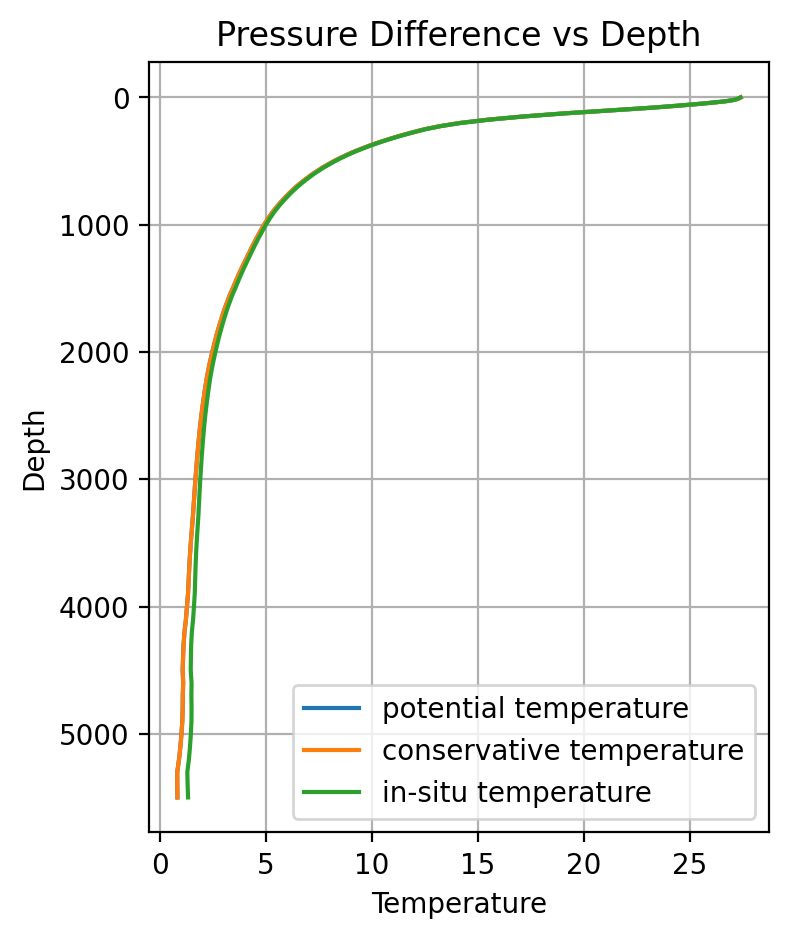

In [36]:
fig, ax = plt.subplots(figsize=(4,5))

plt.plot(poto_temp_eq,depth,label='potential temperature')
plt.plot(cons_temp_eq,depth,label='conservative temperature')
plt.plot(insitu_temp_eq,depth,label='in-situ temperature')

plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  
plt.title('Pressure Difference vs Depth')
plt.grid(True)
plt.legend()

#### <font color=red> </font><br /><font color=red> Create a few Temperature profiles for different latitudes for the global ocean, how do they compare? Why is in-situ temperature always warmer than the other two temperature metrics? </font><br />

Text(0, 0.5, 'Depth')

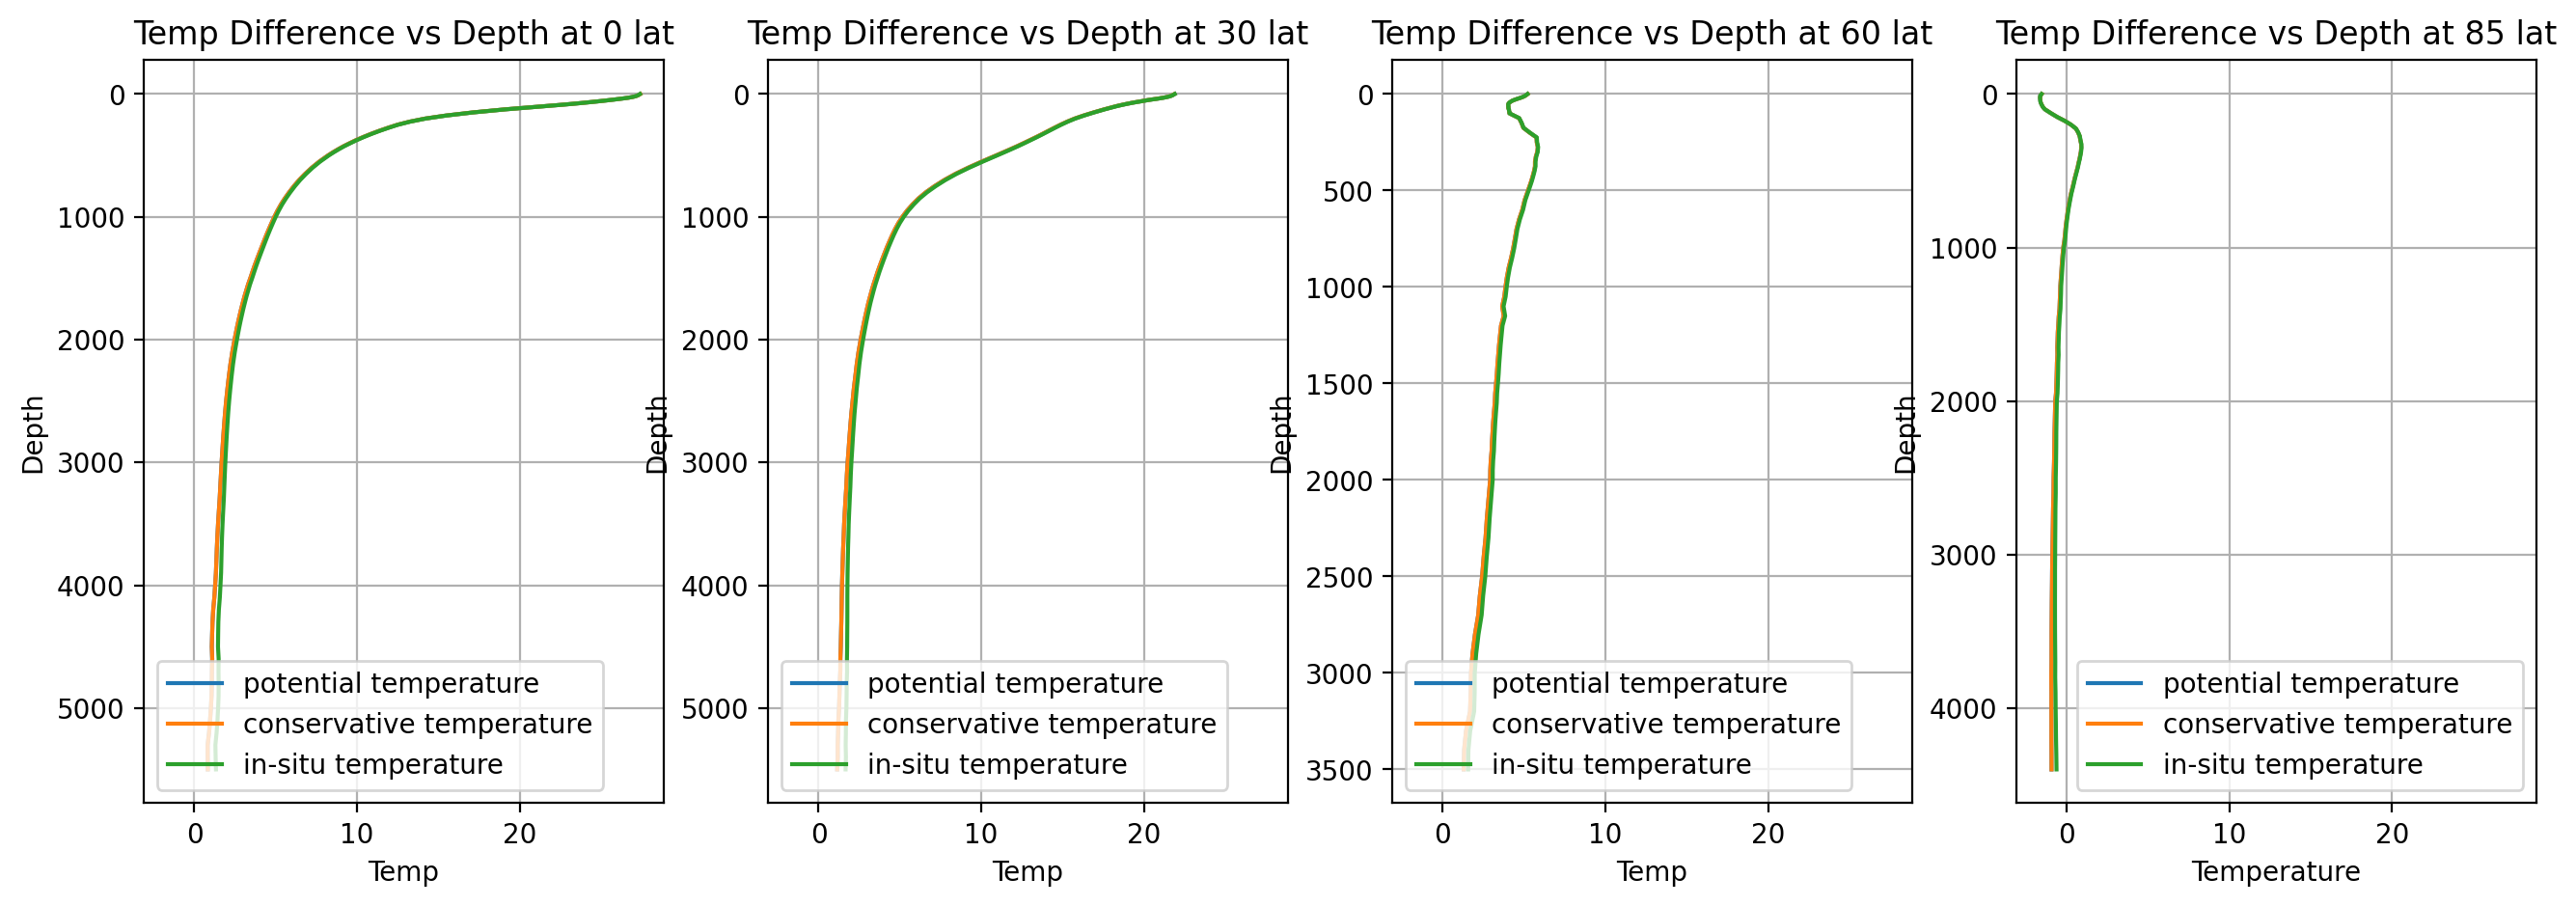

In [37]:
poto_temp_eq = poto_temp.sel(lat=0,method='nearest').mean(dim='lon')
cons_temp_eq = cons_temp.sel(lat=0,method='nearest').mean(dim='lon')
insitu_temp_eq = in_situ_T.sel(lat=0,method='nearest').mean(dim='lon')

poto_temp_eq1 = poto_temp.sel(lat=30,method='nearest').mean(dim='lon')
cons_temp_eq1 = cons_temp.sel(lat=30,method='nearest').mean(dim='lon')
insitu_temp_eq1 = in_situ_T.sel(lat=30,method='nearest').mean(dim='lon')

poto_temp_eq2 = poto_temp.sel(lat=60,method='nearest').mean(dim='lon')
cons_temp_eq2 = cons_temp.sel(lat=60,method='nearest').mean(dim='lon')
insitu_temp_eq2 = in_situ_T.sel(lat=60,method='nearest').mean(dim='lon')

poto_temp_eq3 = poto_temp.sel(lat=85,method='nearest').mean(dim='lon')
cons_temp_eq3 = cons_temp.sel(lat=85,method='nearest').mean(dim='lon')
insitu_temp_eq3 = in_situ_T.sel(lat=85,method='nearest').mean(dim='lon')


fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharex=True)

axs[0].plot(poto_temp_eq,depth,label='potential temperature')
axs[0].plot(cons_temp_eq,depth,label='conservative temperature')
axs[0].plot(insitu_temp_eq,depth,label='in-situ temperature')
axs[0].legend()
axs[0].set_title('Temp Difference vs Depth at 0 lat')
axs[0].set_xlabel('Temp')
axs[0].set_ylabel('Depth')
axs[0].invert_yaxis() 
axs[0].grid(True)

axs[1].plot(poto_temp_eq1,depth,label='potential temperature')
axs[1].plot(cons_temp_eq1,depth,label='conservative temperature')
axs[1].plot(insitu_temp_eq1,depth,label='in-situ temperature')
axs[1].legend()
axs[1].set_title('Temp Difference vs Depth at 30 lat')
axs[1].set_xlabel('Temp')
axs[1].set_ylabel('Depth')
axs[1].invert_yaxis() 
axs[1].grid(True)

axs[2].plot(poto_temp_eq2,depth,label='potential temperature')
axs[2].plot(cons_temp_eq2,depth,label='conservative temperature')
axs[2].plot(insitu_temp_eq2,depth,label='in-situ temperature')
axs[2].legend()
axs[2].set_title('Temp Difference vs Depth at 60 lat')
axs[2].set_xlabel('Temp')
axs[2].set_ylabel('Depth')
axs[2].invert_yaxis() 
axs[2].grid(True)

axs[3].plot(poto_temp_eq3,depth,label='potential temperature')
axs[3].plot(cons_temp_eq3,depth,label='conservative temperature')
axs[3].plot(insitu_temp_eq3,depth,label='in-situ temperature')
axs[3].legend()
axs[3].set_title('Temp Difference vs Depth at 85 lat')
axs[3].set_xlabel('Temp')
axs[3].set_ylabel('Depth')
axs[3].invert_yaxis() 
axs[3].grid(True)

plt.xlabel('Temperature')
plt.ylabel('Depth')



## A. 
### part 2
#### in-situ temp is slightly warmer with depth becuase of the effect of pressure on the water parcel.

### part 1
#### At depth the profiles are more similar than at the surface. 
#### At the equator to 30 lat there us a strong profile which is warmer than 20 degC at the surface and decreases to about 5 degC at 1000m. Then decreases to around 1-2 degrees C at 5000m
#### the temp profile at 60lat starts at 5 degC with a temp inversion in the first 500m. Then decreases to around 1-2 degrees C at 5000m. 
#### the 85lat profile also has a temp inversion but is a colder with surface values below 0 degC.

## <font color=purple> </font><br /><font color=purple> __Salinity__

#### What is salinity?

From Talley DPO: 
_"Seawater is a complicated solution containing the majority of known elements"_

__Absolute Salinity__ is a measure of the ratio of the mass of all dissolved substances in seawater to the mass of the seawater, expressed as kg/kg or g/kg. This is the current recommended defintion of salinity (there have been many!).

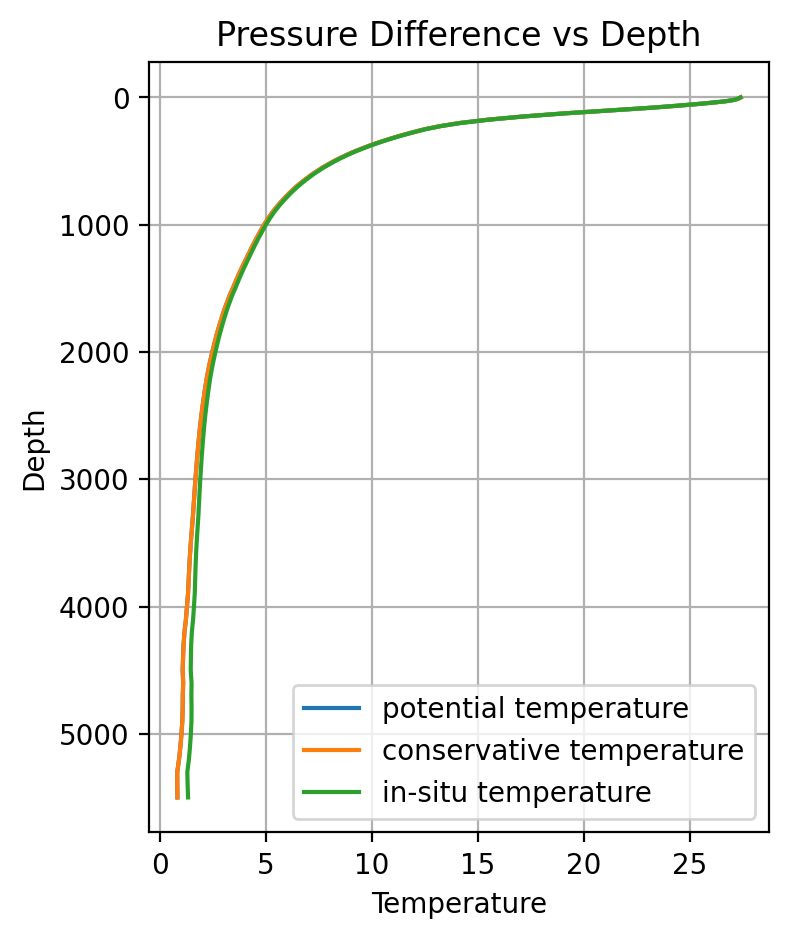

In [38]:
fig, ax = plt.subplots(figsize=(4,5))

plt.plot(poto_temp_eq,depth,label='potential temperature')
plt.plot(cons_temp_eq,depth,label='conservative temperature')
plt.plot(insitu_temp_eq,depth,label='in-situ temperature')

plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  
plt.title('Pressure Difference vs Depth')
plt.grid(True)
plt.legend()

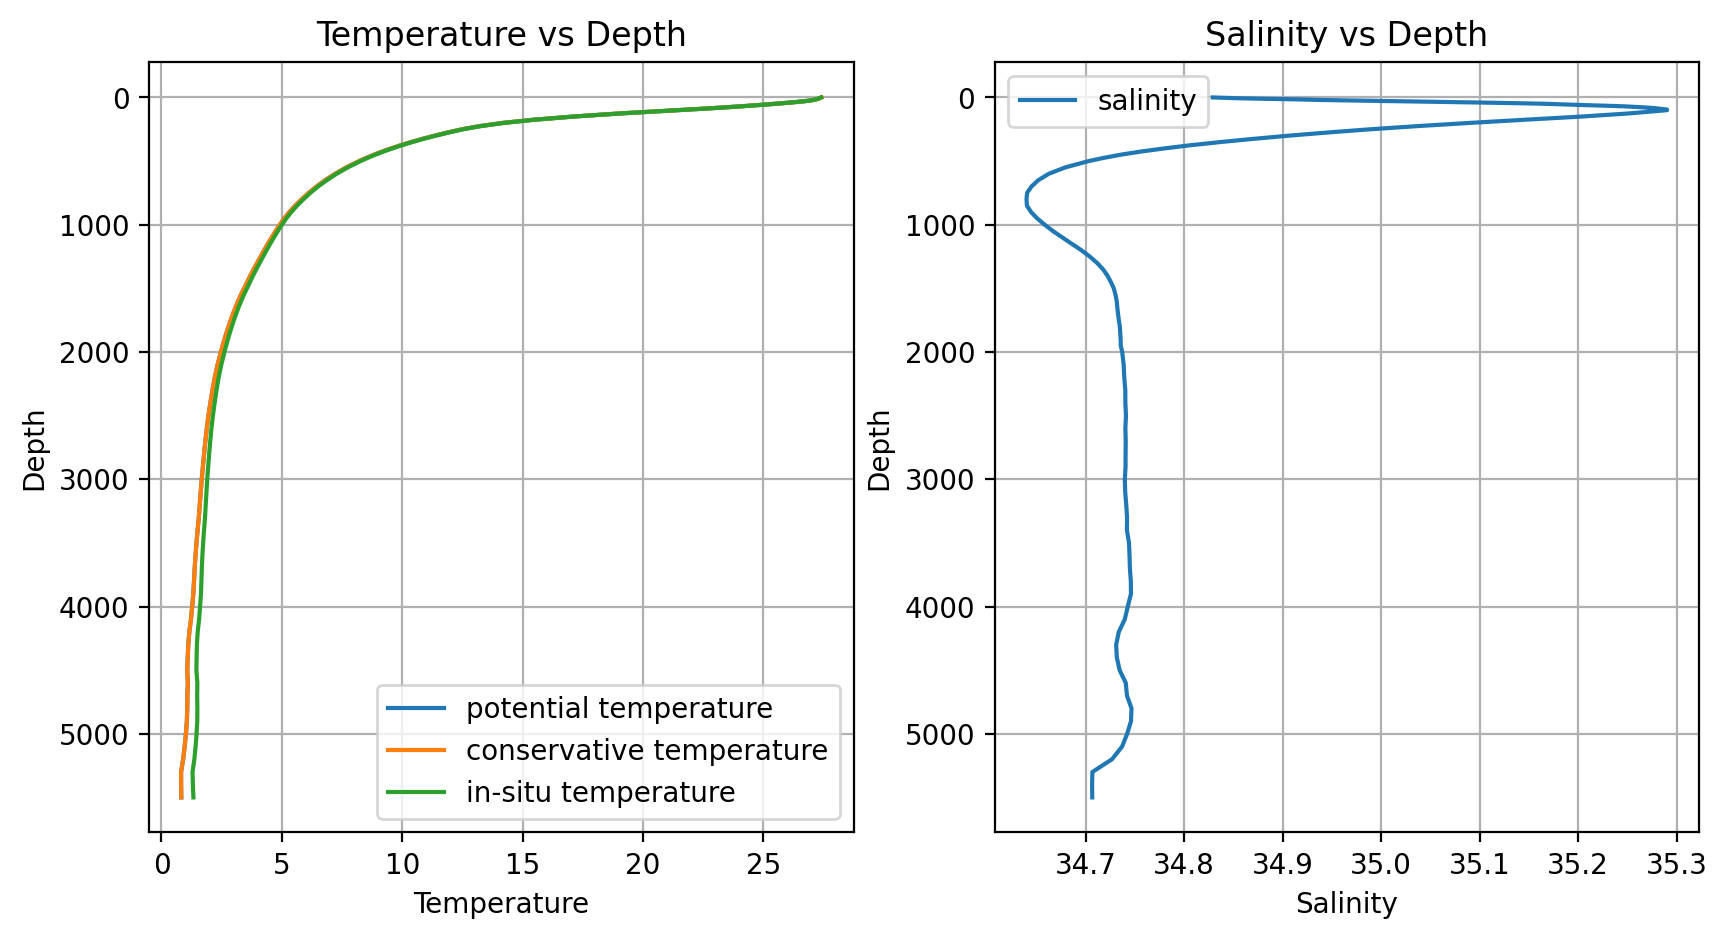

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 

# Left subplot: your existing temperature vs depth plot
axs[0].plot(poto_temp_eq, depth, label='potential temperature')
axs[0].plot(cons_temp_eq, depth, label='conservative temperature')
axs[0].plot(insitu_temp_eq, depth, label='in-situ temperature')
axs[0].set_xlabel('Temperature')
axs[0].set_ylabel('Depth')
axs[0].invert_yaxis()
axs[0].set_title('Temperature vs Depth')
axs[0].grid(True)
axs[0].legend()

salt_eq = salt.sel(lat=0,method='nearest').mean(dim='lon')

# Left subplot: your existing temperature vs depth plot
axs[1].plot(salt_eq, depth, label='salinity')
axs[1].set_xlabel('Salinity')
axs[1].set_ylabel('Depth')
axs[1].invert_yaxis()
axs[1].set_title('Salinity vs Depth')
axs[1].grid(True)
axs[1].legend()

#### <font color=red> </font><br /><font color=red> Create a few salinity profiles for different latitudes for the global ocean / different regions. How do they compare? For each region describe the nature of your salinity profile and speculate on which water masses you might be encoutering. What is a water mass? Place your answers in the cells below. </font><br />

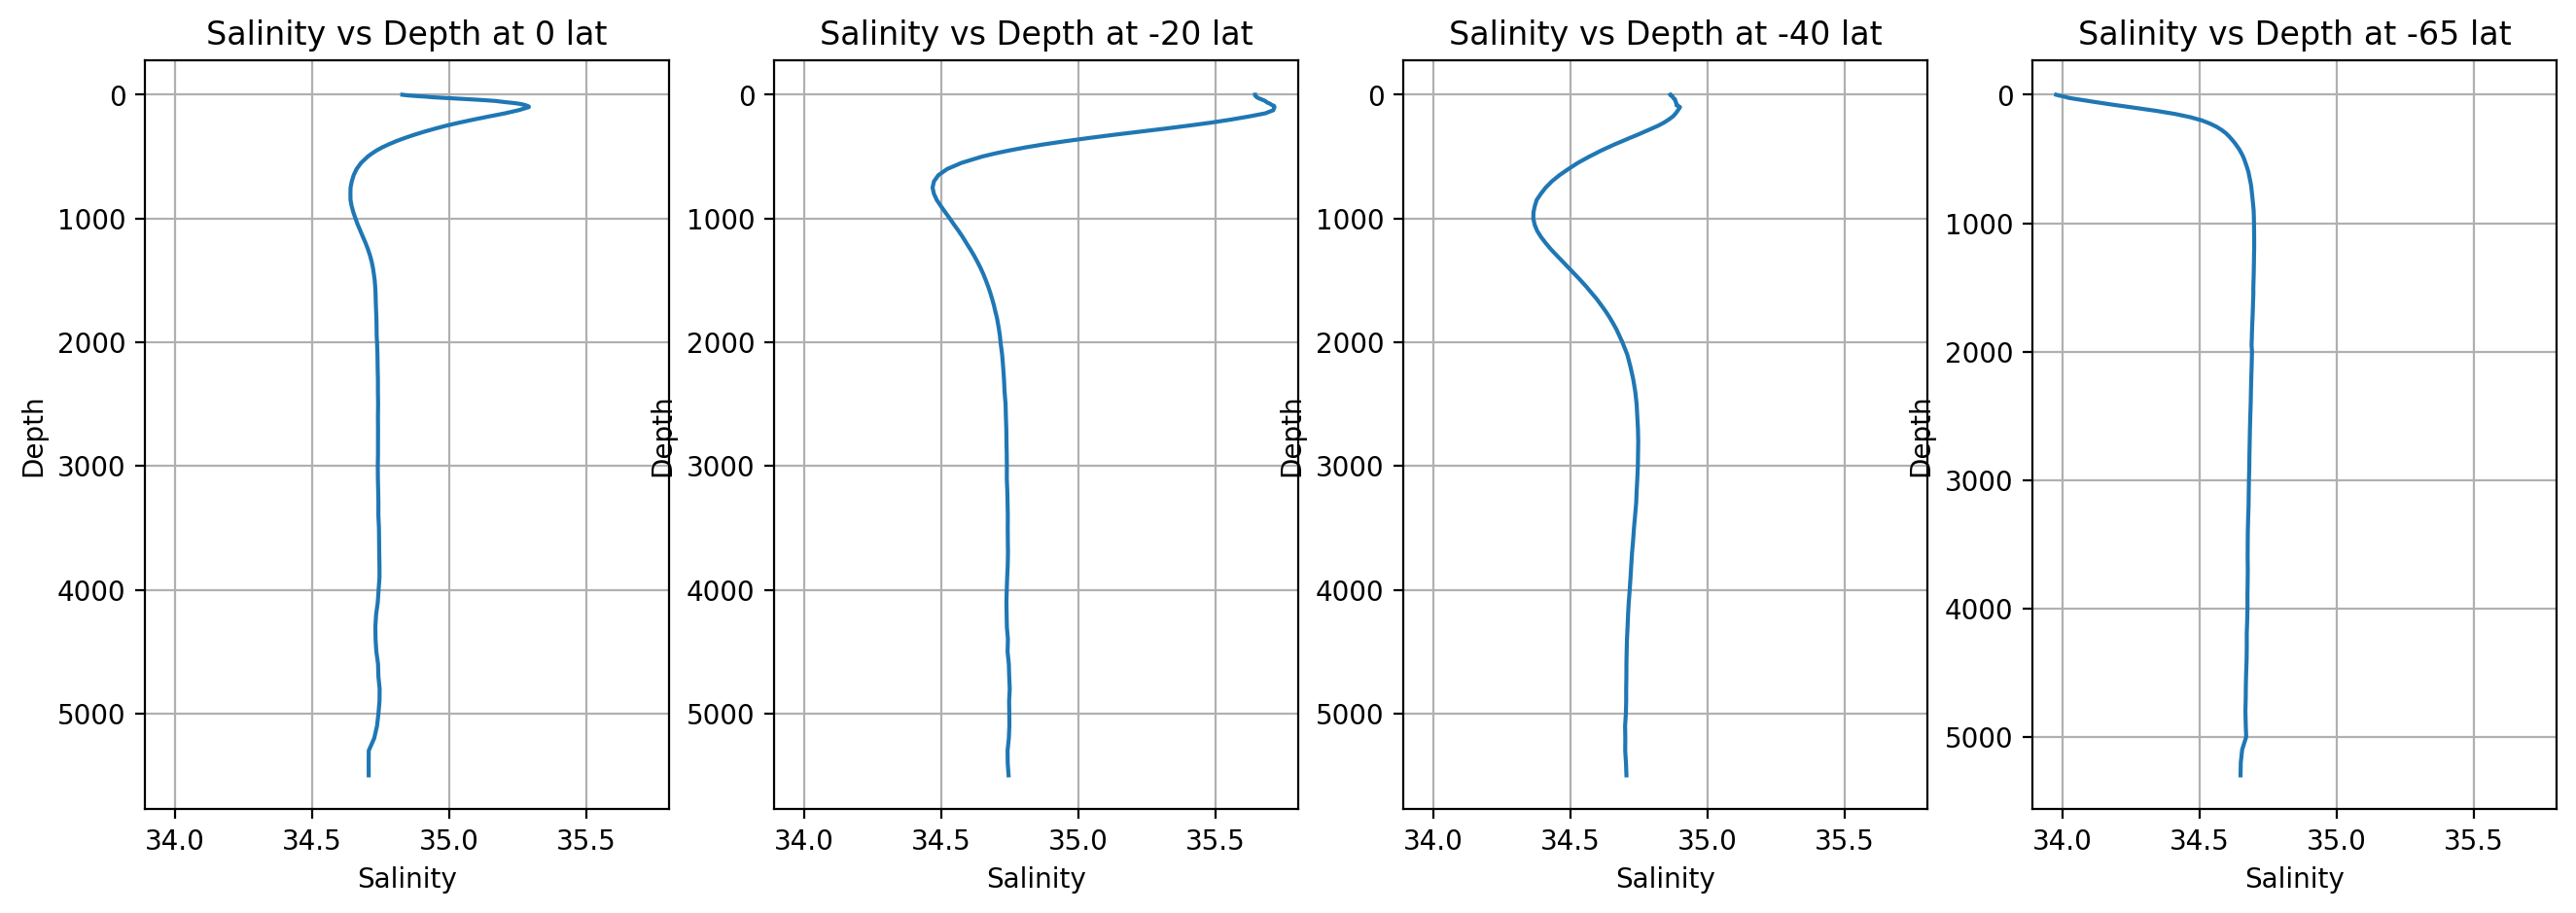

In [40]:
salt_eq = salt.sel(lat=0,method='nearest').mean(dim='lon')

salt_eq1 = salt.sel(lat=-20,method='nearest').mean(dim='lon')
salt_eq2 = salt.sel(lat=-40,method='nearest').mean(dim='lon')
salt_eq3 = salt.sel(lat=-65,method='nearest').mean(dim='lon')

fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharex=True)

axs[0].plot(salt_eq,depth,label='Salinity')
#axs[0].legend()
axs[0].set_title('Salinity vs Depth at 0 lat')
axs[0].set_xlabel('Salinity')
axs[0].set_ylabel('Depth')
axs[0].invert_yaxis() 
axs[0].grid(True)

axs[1].plot(salt_eq1,depth,label='Salinity')
#axs[1].legend()
axs[1].set_title('Salinity vs Depth at -20 lat')
axs[1].set_xlabel('Salinity')
axs[1].set_ylabel('Depth')
axs[1].invert_yaxis() 
axs[1].grid(True)

axs[2].plot(salt_eq2,depth,label='Salinity')
#axs[2].legend()
axs[2].set_title('Salinity vs Depth at -40 lat')
axs[2].set_xlabel('Salinity')
axs[2].set_ylabel('Depth')
axs[2].invert_yaxis() 
axs[2].grid(True)

axs[3].plot(salt_eq3,depth,label='Salinity')
#axs[3].legend()
axs[3].set_title('Salinity vs Depth at -65 lat')
axs[3].set_xlabel('Salinity')
axs[3].set_ylabel('Depth')
axs[3].invert_yaxis() 
axs[3].grid(True)





#### <font color=red> </font><br /><font color=red> Now slice your WOA T and S along different lat / lon sections through which your profiles pass through to see if you can identify water masses better. Place your plots in the cells below and in using descriptive markdown describe the patterns you see and relationships of these properties with respect to depth / location.

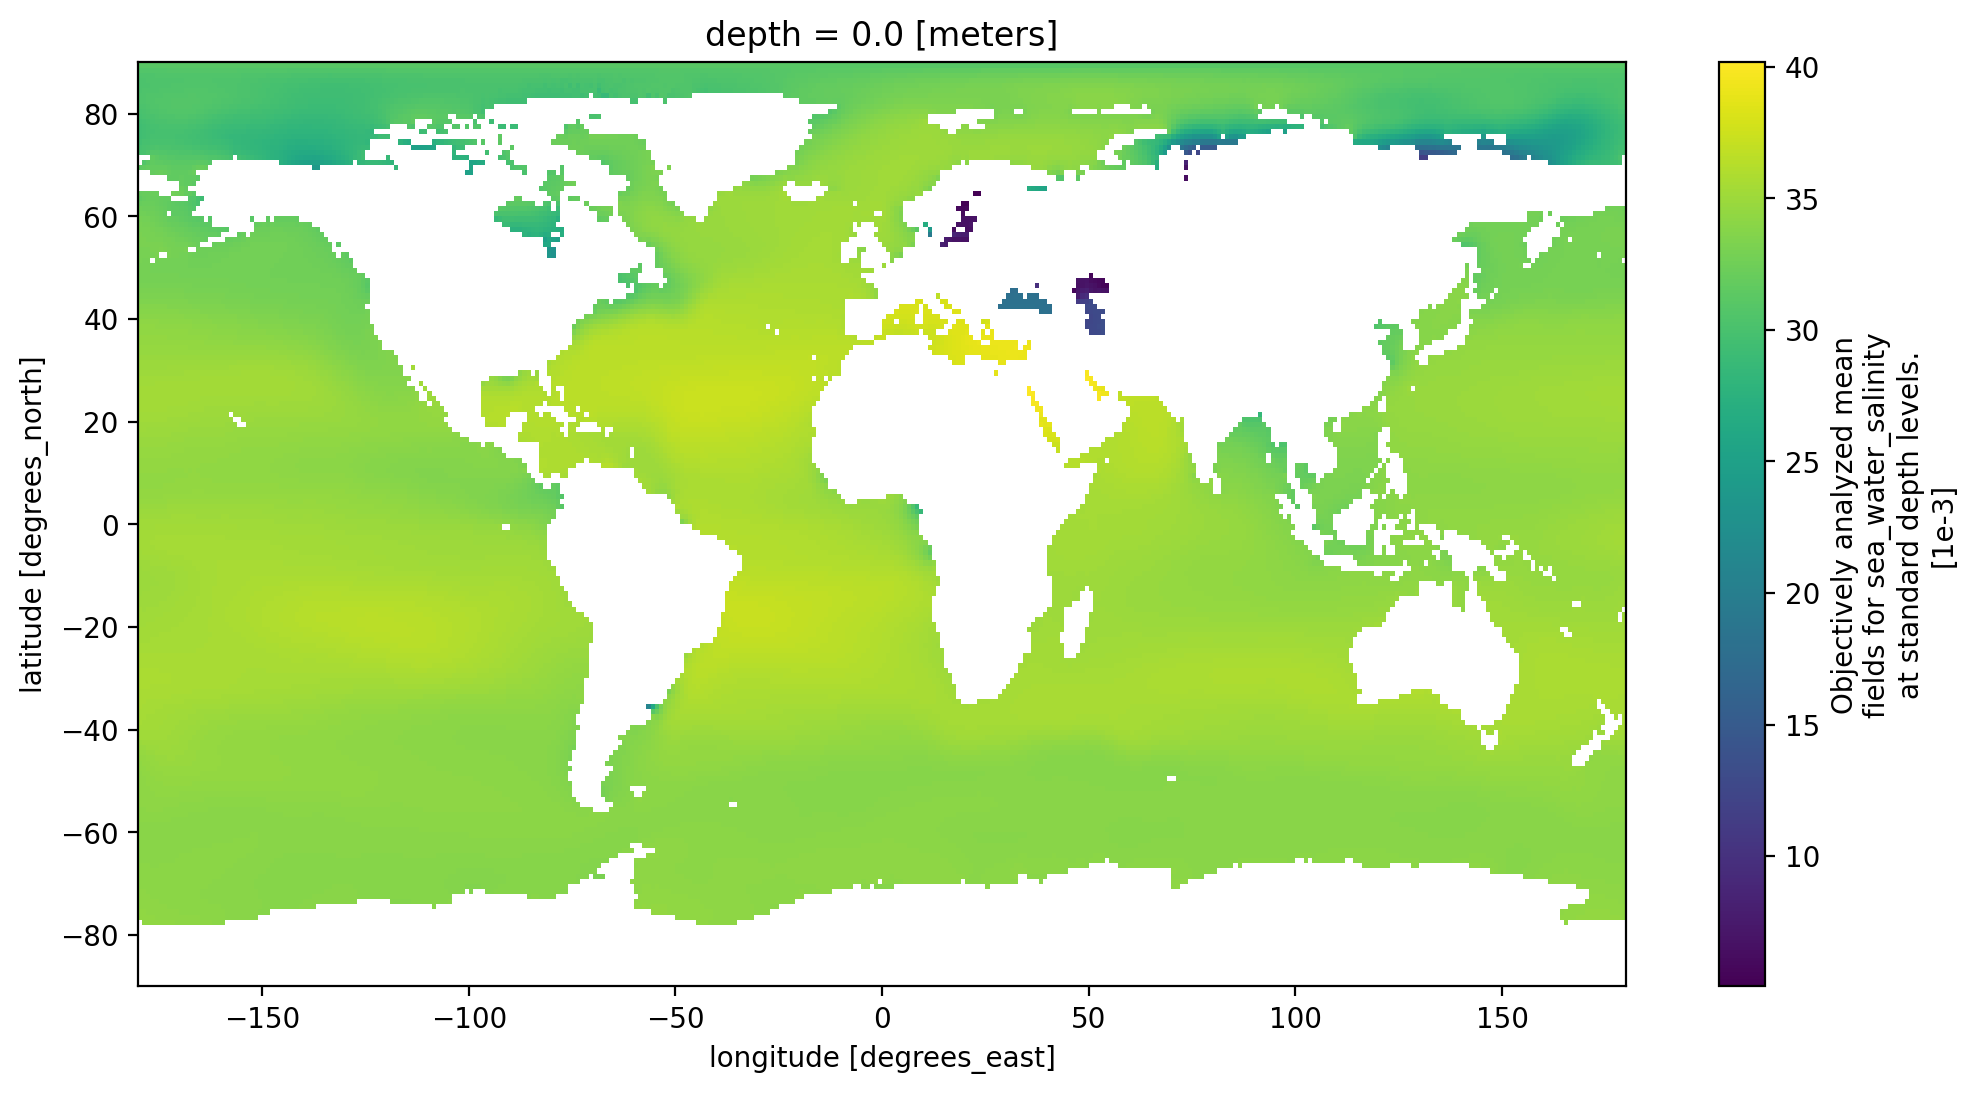

In [41]:
salt.sel(depth=0).plot()

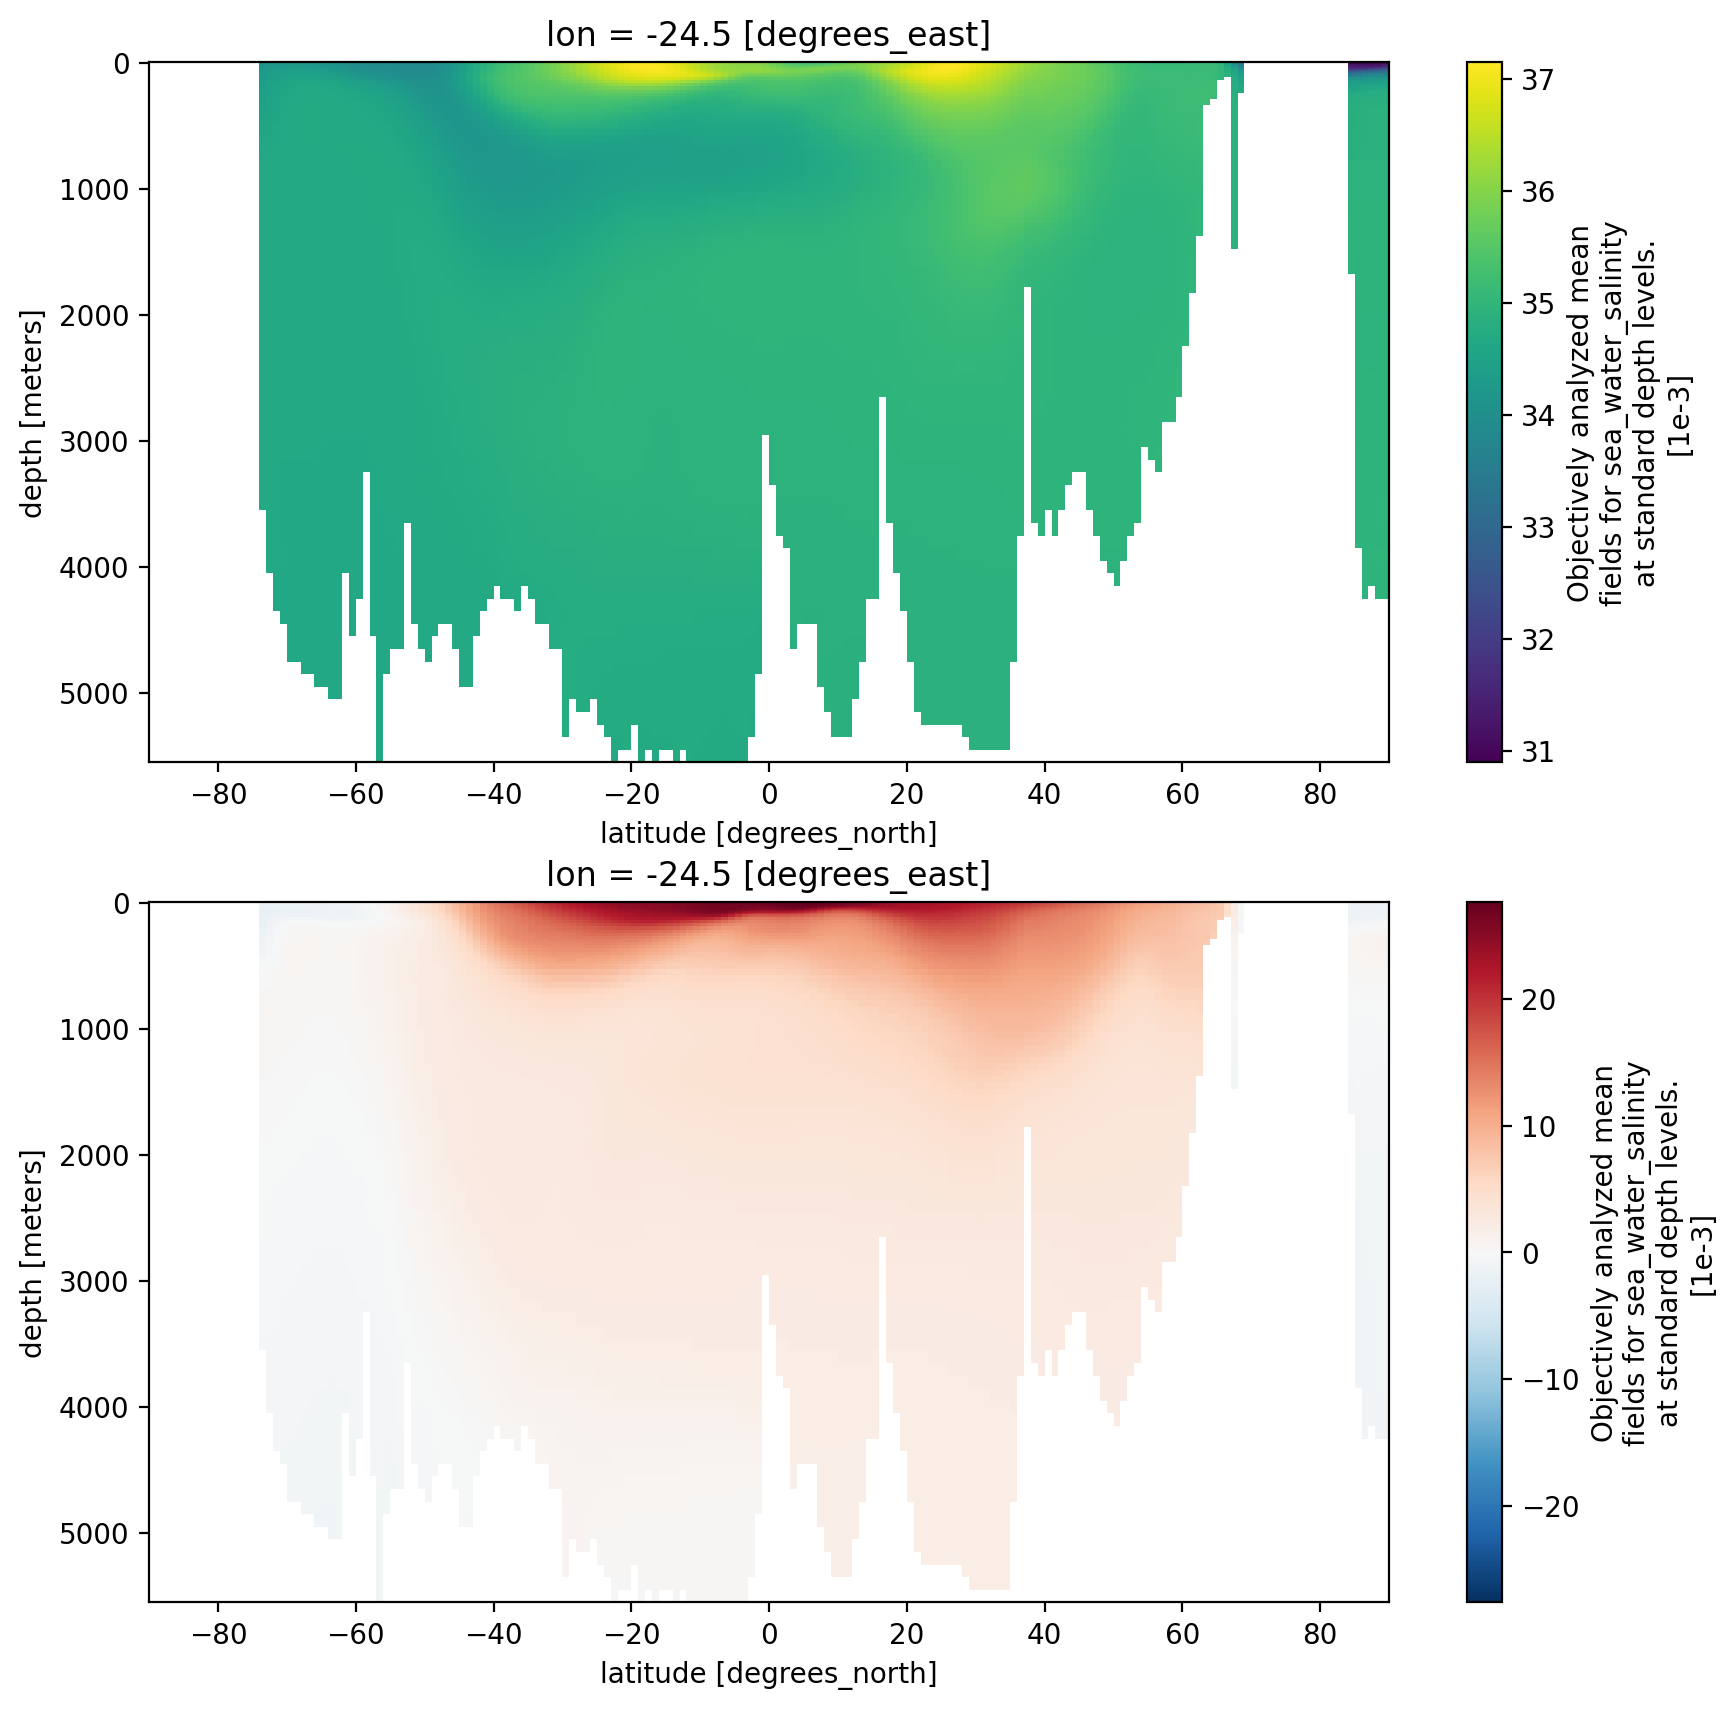

In [42]:
fig,(ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(10,10)) 

# Left subplot: your existing temperature vs depth plot
salt.sel(lon=-25,method='nearest').plot(ax=ax1,yincrease=False)
poto_temp.sel(lon=-25,method='nearest').plot(yincrease=False)




#### On both sides of the EQ the surface waters are warmer. The water gets cooler deeper and further to the poles. There is a fresher toungue in the sub-surface in the southern hemipshere.The areas with are warm in on both sides of the EQ is very dense.

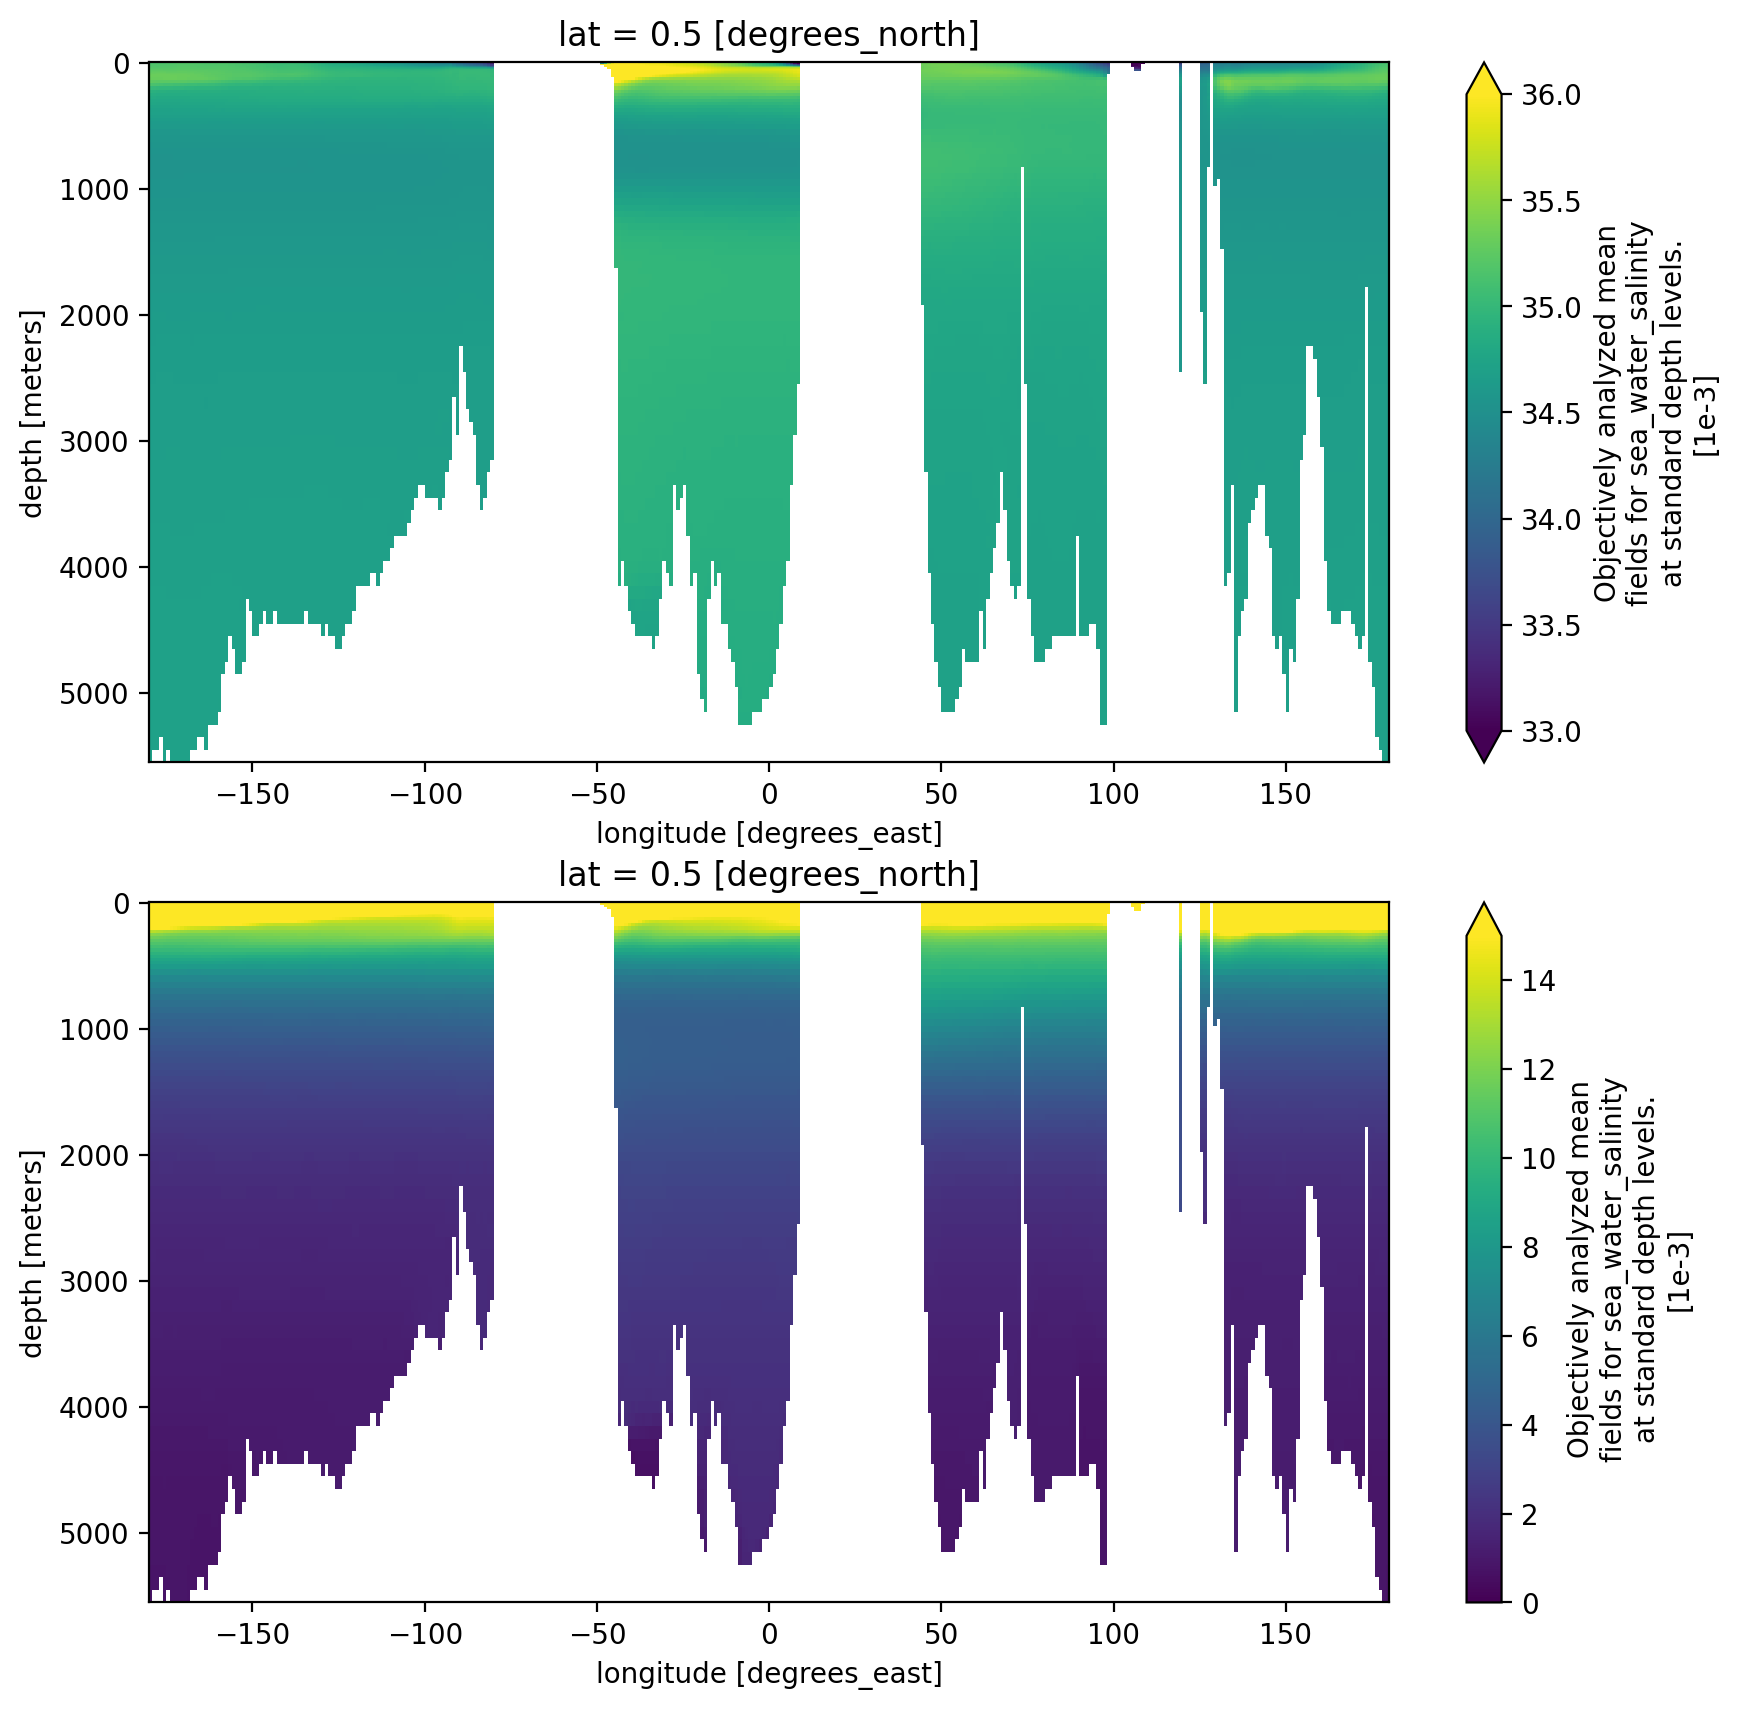

In [43]:
fig,(ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(10,10)) 

# Left subplot: your existing temperature vs depth plot
salt.sel(lat=0,method='nearest').plot(ax=ax1,yincrease=False,
                                      vmin=33,vmax=36)
poto_temp.sel(lat=0,method='nearest').plot(yincrease=False,
                                          vmin=0,vmax=15)


#### A. Consistently the top 100m of the surface has temp of above 25 degrees C. Then a cold sub-surface that is consistent in all the ocean basins. The surface of the Atlantic is the much saltier than the other the ocean basins. The Atlantic sub-surafce is slighly fresher and then gets more saline after 1200m.

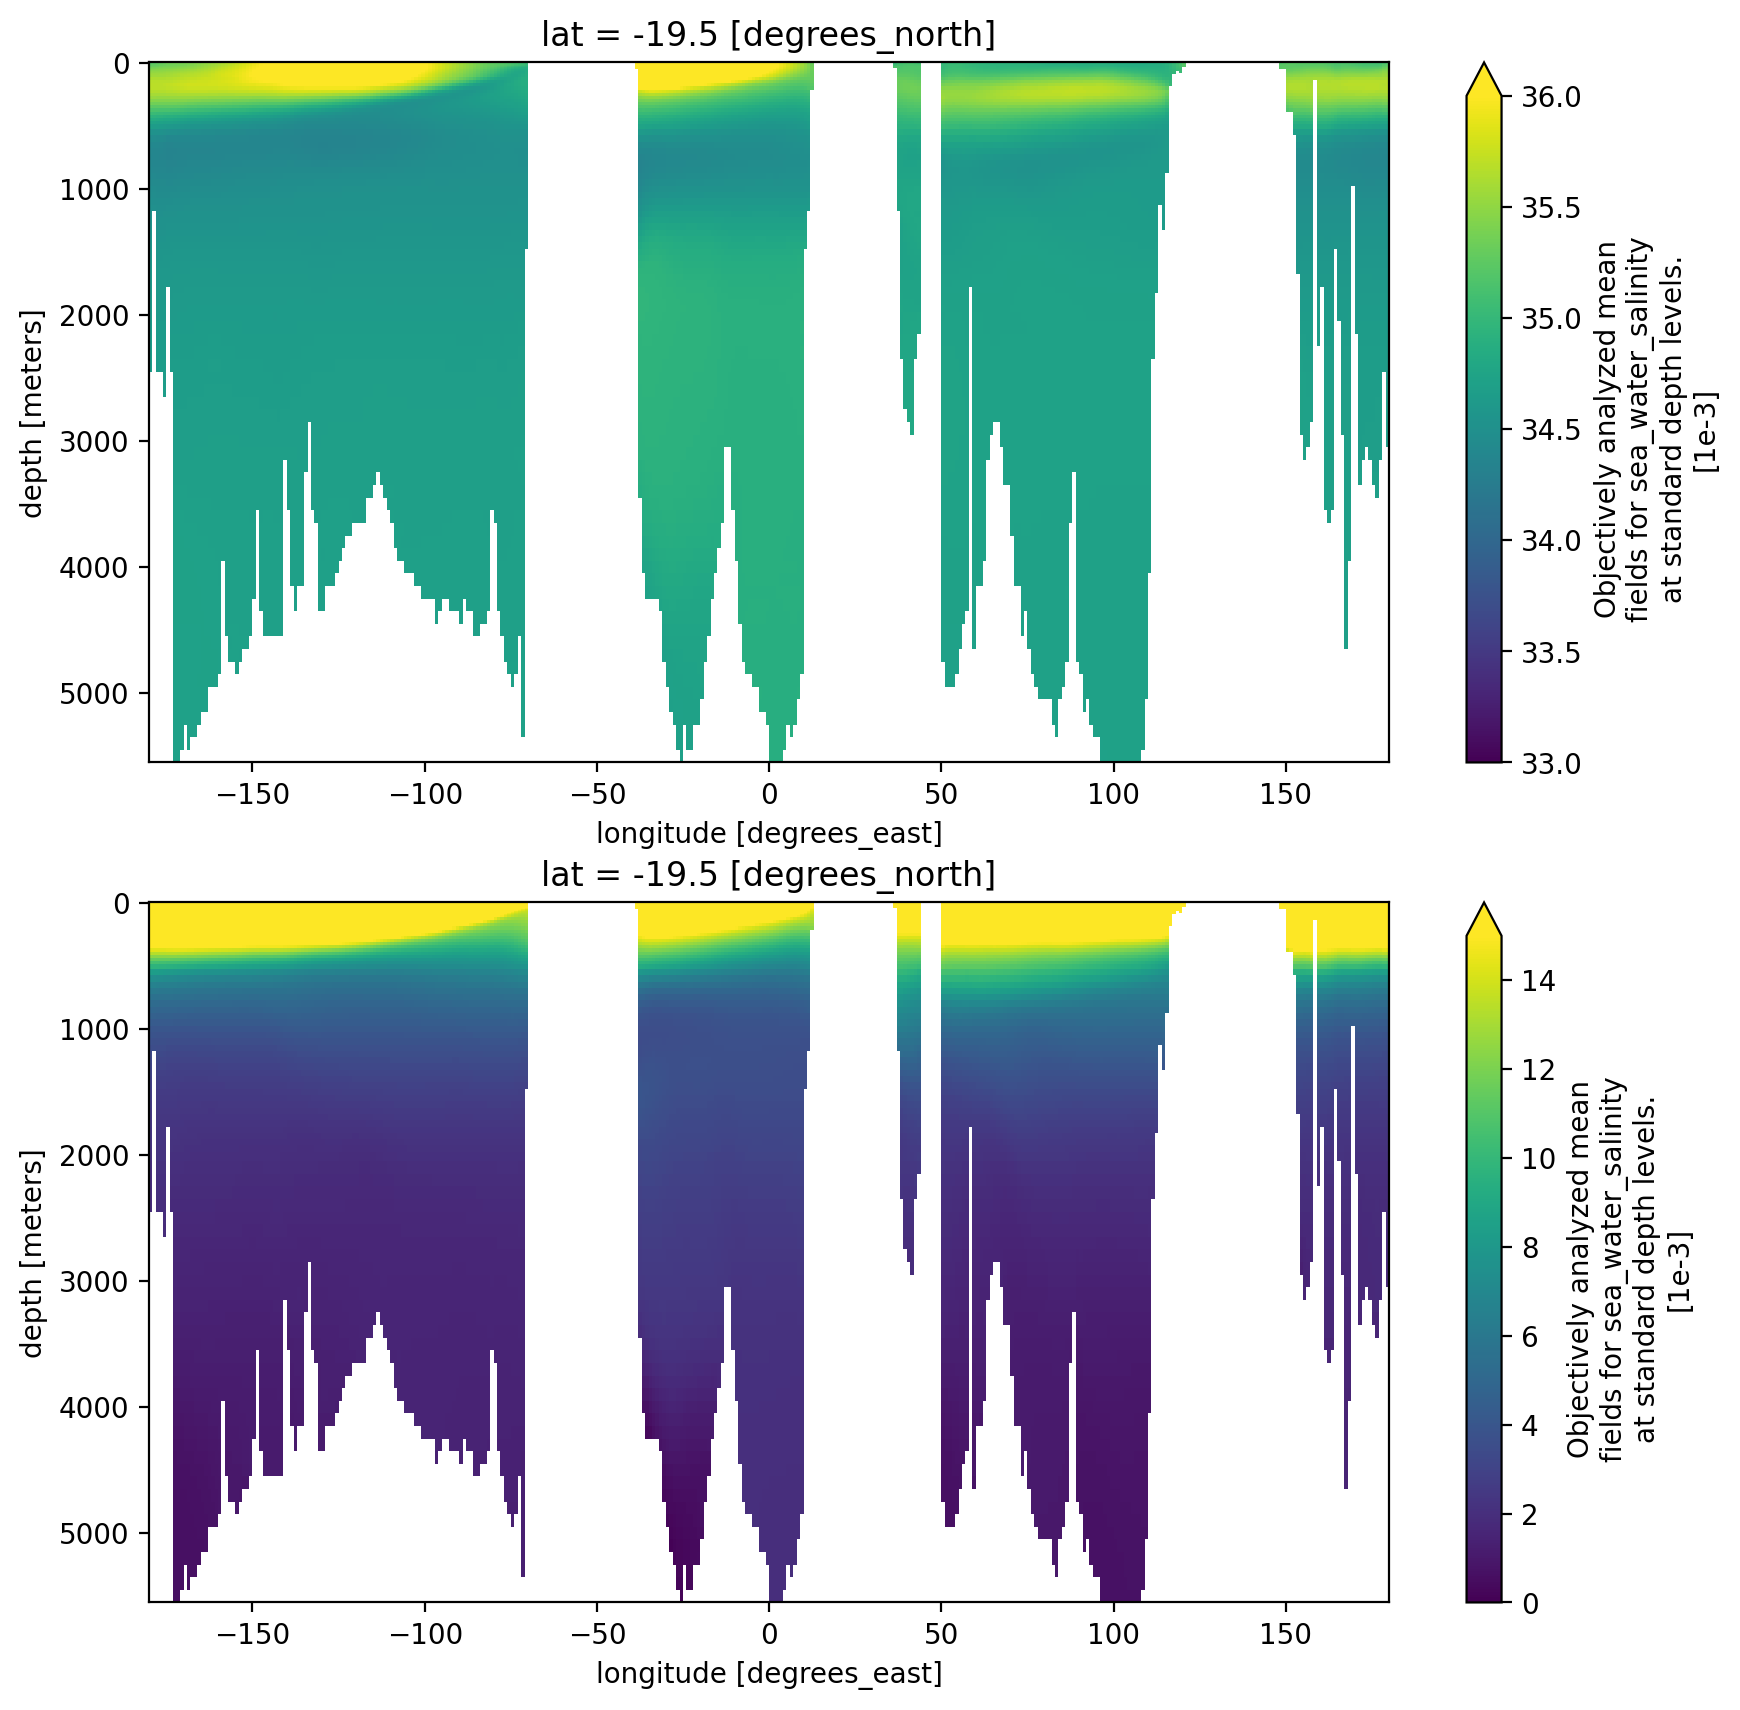

In [44]:
fig,(ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(10,10)) 

# Left subplot: your existing temperature vs depth plot
salt.sel(lat=-20,method='nearest').plot(ax=ax1,yincrease=False,
                                      vmin=33,vmax=36)
poto_temp.sel(lat=-20,method='nearest').plot(yincrease=False,
                                          vmin=0,vmax=15)


#### A. Consistently the top 100m of the surface has temp of above 20 degrees C with is a bit cooler than the EQ slice. The warm and salty water extends further down in the water coloum. Then a cold sub-surface that is consistent in all the ocean basins. The surface of the of all of the ocean basins has a salty surface layer and then a fresher layer below. 

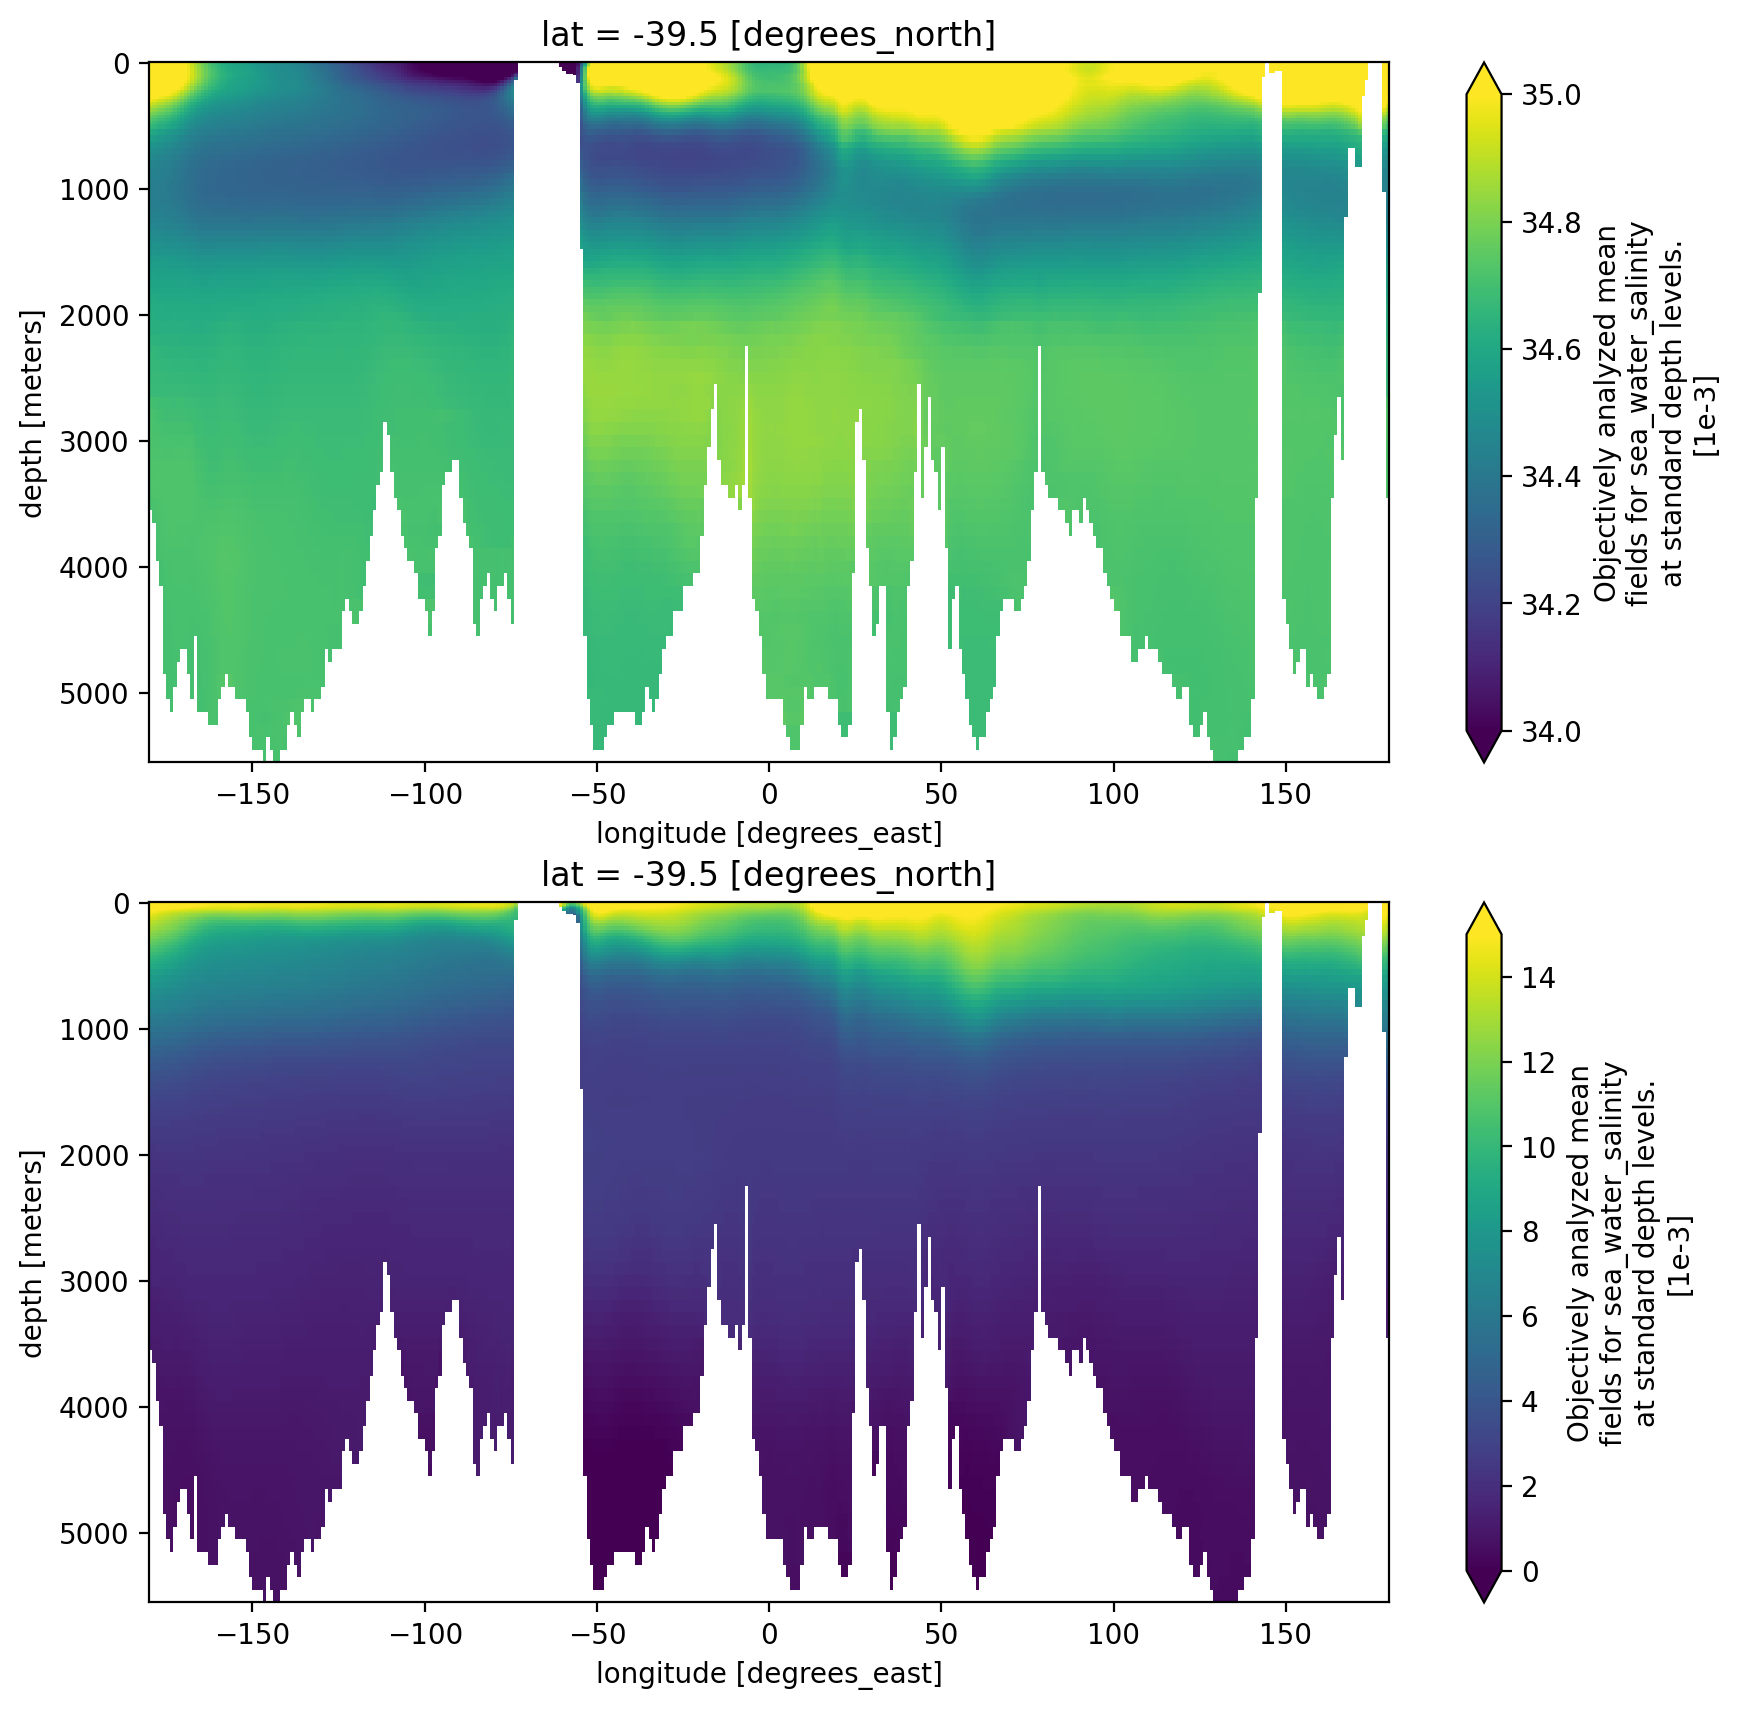

In [45]:
fig,(ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(10,10)) 

# Left subplot: your existing temperature vs depth plot
salt.sel(lat=-40,method='nearest').plot(ax=ax1,yincrease=False,
                                      vmin=34,vmax=35)
poto_temp.sel(lat=-40,method='nearest').plot(yincrease=False,
                                          vmin=0,vmax=15)


#### A. At 60S (in the southern ocean) the temp is much cooler with most of the temp valus below 5 degrees C. The Atalntic is the coldest basin (probably becuase of NADW and AABW formation). The warmest values are seen in the in the Pacfic basin. 
#### the salinty values are pretty consistent with a fresh surface layer and then a salty layer below. In the Pacfific the fresher layer extends deeper to 1000m.

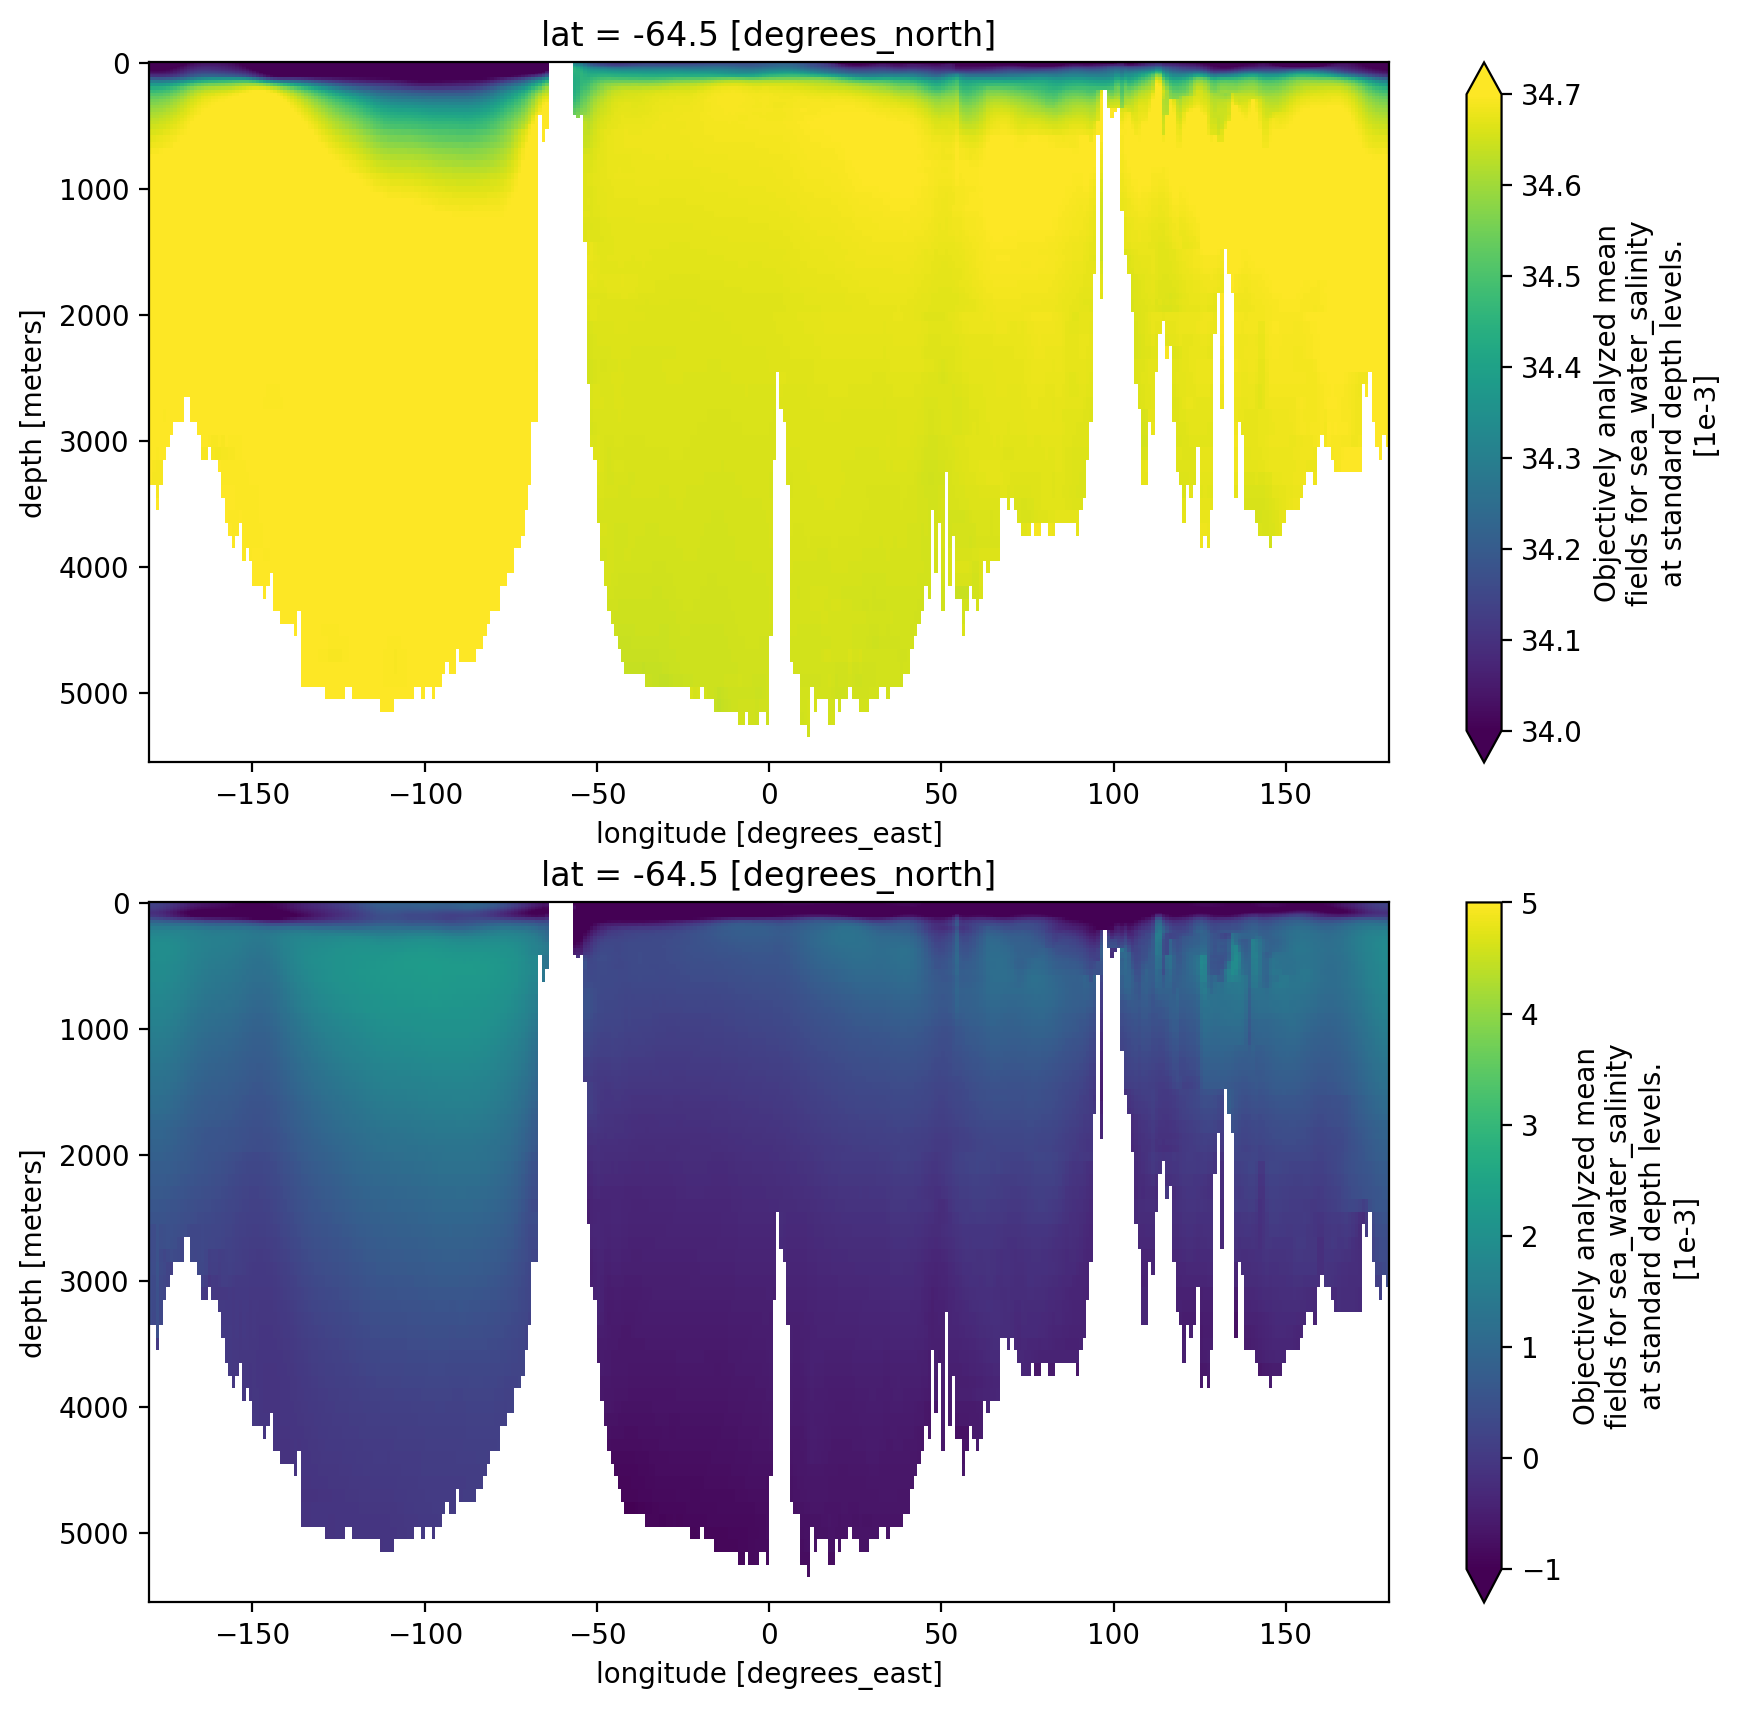

In [46]:
fig,(ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(10,10)) 

# Left subplot: your existing temperature vs depth plot
salt.sel(lat=-65,method='nearest').plot(ax=ax1,yincrease=False,
                                       vmin=34,vmax=34.7)
poto_temp.sel(lat=-65,method='nearest').plot(yincrease=False,
                                          vmin=-1,vmax=5)

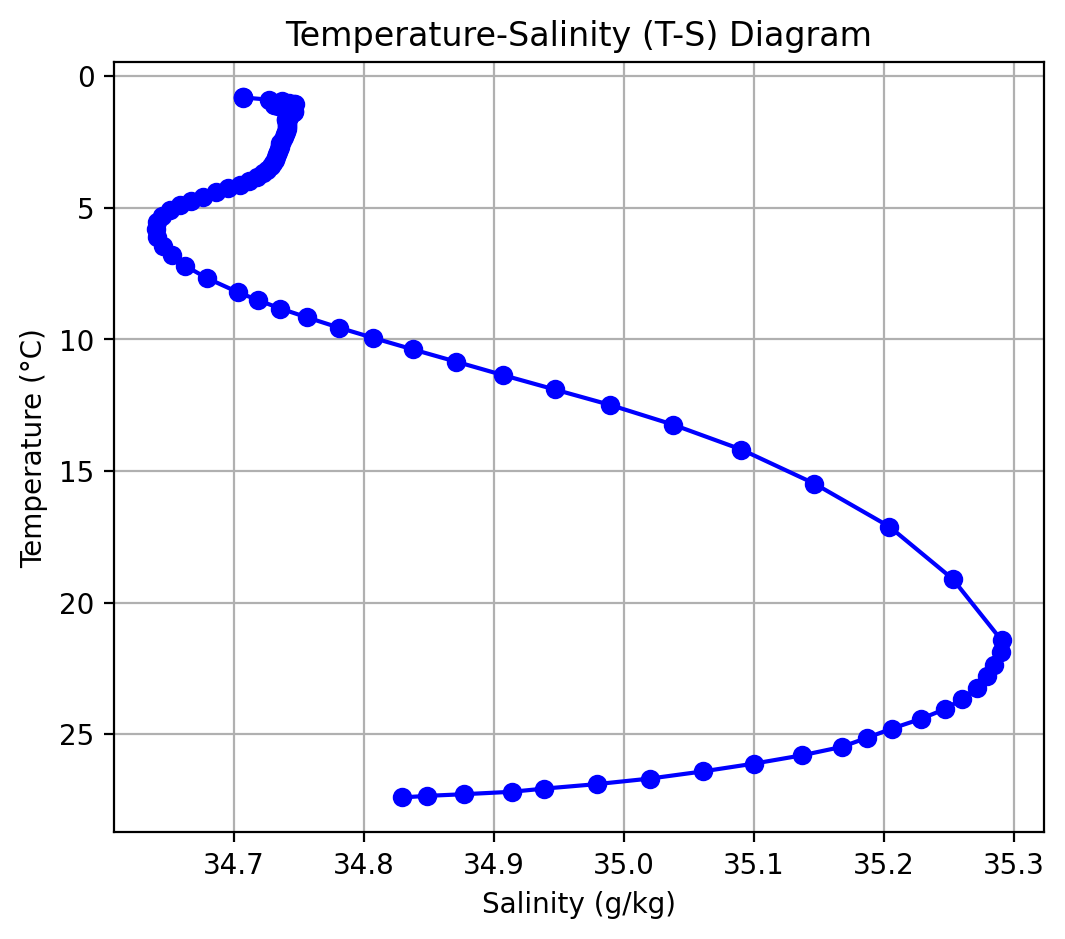

In [47]:
# A common way that oceanographers visualize ocean properties and identify water masses" is via Temperature - Salinity diagrams.
plt.figure(figsize=(6, 5))
plt.plot(salt_eq, poto_temp_eq, marker='o', linestyle='-', color='b')

plt.xlabel('Salinity (g/kg)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature-Salinity (T-S) Diagram')
plt.grid(True)

plt.gca().invert_yaxis()

#### <font color=red> </font><br /><font color=red> Create T-S diagrams below for the regions you investigated above and use them to identify your watermasses.

(-2.0, 30.0)

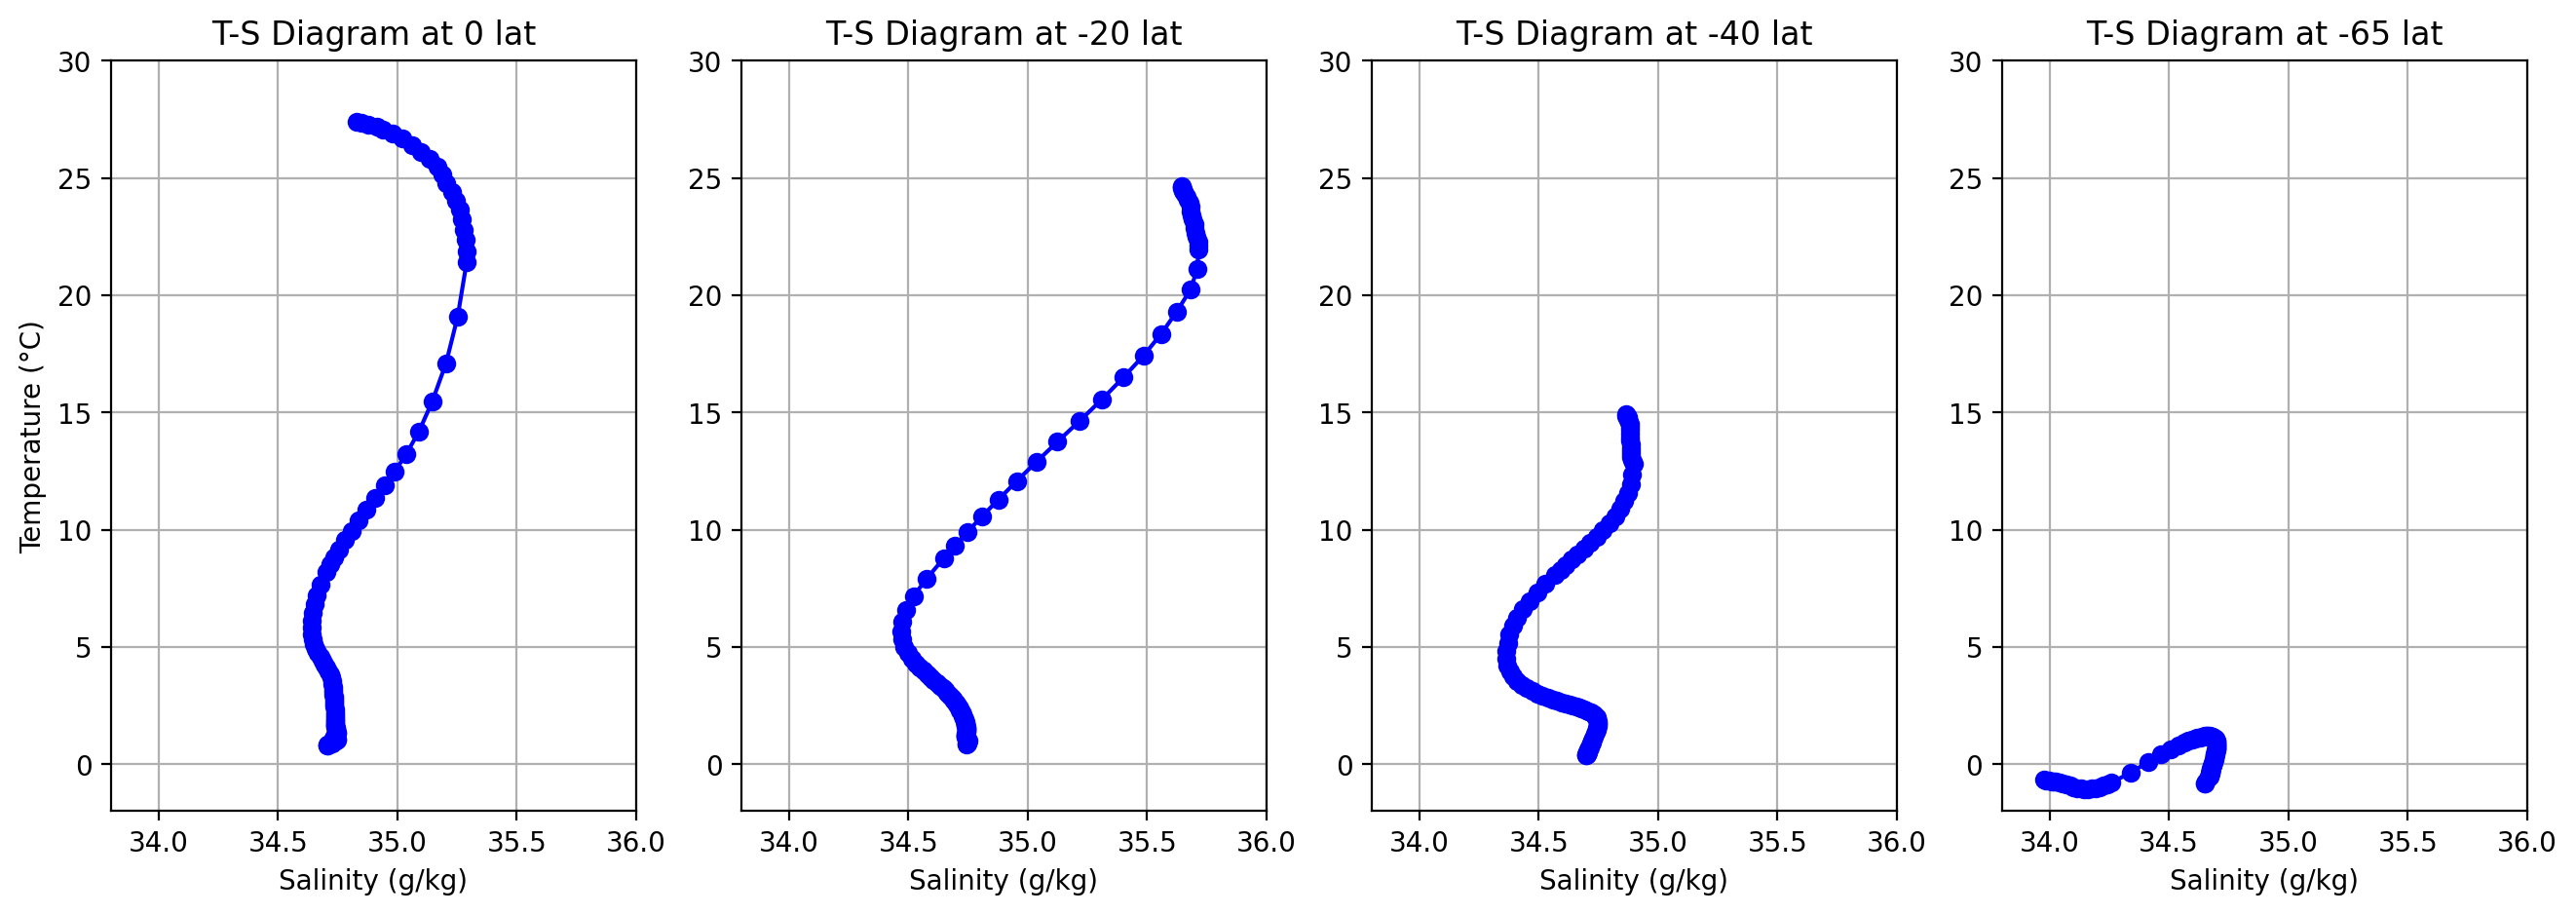

In [48]:

poto_temp_eq = poto_temp.sel(lat=0,method='nearest').mean(dim='lon')
poto_temp_eq1s = poto_temp.sel(lat=-20,method='nearest').mean(dim='lon')
poto_temp_eq2s = poto_temp.sel(lat=-40,method='nearest').mean(dim='lon')
poto_temp_eq3s = poto_temp.sel(lat=-65,method='nearest').mean(dim='lon')


fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharex=True)

axs[0].plot(salt_eq, poto_temp_eq ,marker='o', linestyle='-', color='b')
#axs[0].legend()
axs[0].set_title('T-S Diagram at 0 lat')
axs[0].set_xlabel('Salinity (g/kg)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].invert_yaxis() 
axs[0].grid(True)

axs[1].plot(salt_eq1, poto_temp_eq1s, marker='o', linestyle='-', color='b')
#axs[1].legend()
axs[1].set_title('T-S Diagram at -20 lat')
axs[1].set_xlabel('Salinity (g/kg)')
#axs[1].set_ylabel('Depth')
axs[1].invert_yaxis() 
axs[1].grid(True)

axs[2].plot(salt_eq2, poto_temp_eq2s, marker='o', linestyle='-', color='b')
#axs[2].legend()
axs[2].set_title('T-S Diagram at -40 lat')
axs[2].set_xlabel('Salinity (g/kg)')
#axs[2].set_ylabel('Depth')
axs[2].invert_yaxis() 
axs[2].grid(True)

axs[3].plot(salt_eq3, poto_temp_eq3s, marker='o', linestyle='-', color='b')
#axs[3].legend()
axs[3].set_title('T-S Diagram at -65 lat')
axs[3].set_xlabel('Salinity (g/kg)')
#axs[3].set_ylabel('Depth')
axs[3].invert_yaxis() 
axs[3].grid(True)

axs[0].set_xlim([33.8, 36])
axs[1].set_xlim([33.8, 36])
axs[2].set_xlim([33.8, 36])
axs[3].set_xlim([33.8, 36])

axs[0].set_ylim([-2, 30])
axs[1].set_ylim([-2, 30])
axs[2].set_ylim([-2, 30])
axs[3].set_ylim([-2, 30])

#### A.
#### The warm and salty water at the surafce of the EQ that extend down in the water colum at 20S (T= 25, S=35.4) is central Atlantic surface water.
#### The fresh (34.4) and cold (5 deg C) best seen in lat 40S is the Antarctic intermediate water.

#### In the 65S T/S:
#### The cold (<0 deg C) and fresher (34) water mass is AABW 
#### The cold (0 deg C)and saltier (34.7) is the NADW (alos seen in the other T/S diagrams)





## <font color=purple> </font><br /><font color=purple> __Density__

#### Density (in units of kg / m3) of seawater is a non-linear function of temperature, salinity, and pressure whose relationship is described by the __seawater equation of state__. 

The density of seawater determines the depth at which a parcel will settle in equilibrium - more dense on the bottom, less dense on top. This determines the "layering" or __stratification__ of a column of water. If a parcel of seawater moves such that its density is __more or less__ than that of the surrounding environment, it will experience a __buoyancy force__. Such forces are important to understaning the circulation of the global ocean.

Just like what was discussed above for in-situ temperature, the compressibility of seawater means that under high pressure (with increasing depth), the in-situ density of the water parcel will increase. This is the direct result of the increase in pressure causing water molecules to become pushed together. This "pressure effect" on density is __large__, yet it has little to do with the initial temperature and salinity of a water parcel - which is really what we care about as oceanographers. We want to be able to "trace" water around the global ocean and understand pathways.

Oceanographers use a quantity known as __potential density__ which removes this pressure effect. Potential density (similar to potential temperature described above) is __the density a parcel of water would have if it were moved adiabatically to a chosen reference pressure__. Potential density is calculated using potential temperature, in-situ salinity, and requires specifying a reference pressure level. The surface is commonly used, yet this is not adequate when analyzing changes in the deep ocean.

#### Lets compute in-situ density using the Gibbs Seawater Package:

In [49]:
S  = 35.0      # Salinity (g/kg)
t = 10.0       # In-situ temperature (°C)
p = 0     # Pressure (dbar)

# Calculate in-situ density
rho = gsw.rho(S, t, p)
rho

1026.8246444578683

#### <font color=red> </font><br /><font color=red> Explore what happens when you change the parameters above. Place your notes here.

In [50]:
p = 1000.0     # Pressure (dbar)
den = 1026.82

p = 1000.0     # Pressure (dbar)
den = 1031.28

p = 2000.0     # Pressure (dbar)
den = 1035.63

p = 3000.0     # Pressure (dbar)
den = 1039.9

p = 4000.0     # Pressure (dbar)
den = 1044.06

# as the pressure increases the density increases

In [51]:
S = 35.0       # Absolute Salinity (g/kg)
t = 10.0       # In-situ temperature (°C)
p = 1000.0     # In-situ pressure (dbar)
p_ref = 0.0    # Reference pressure (dbar), usually surface pressure

# Calculate potential density referenced to p_ref
potential_density = gsw.pot_rho_t_exact(S, t, p, p_ref)
potential_density

1026.8463552798069

#### <font color=red> </font><br /><font color=red> How different is your potential density value relative to your in-situ?

In [52]:
p = 1000.0     # Pressure (dbar)
den = 1026.82

p = 1000.0     # Pressure (dbar)
den = 1031.28

p = 1000.0     # In-situ pressure (dbar)
p_ref = 0.0    # Reference pressure (dbar), usually surface pressure
p_den = 1026.84

# Even though the pressure is set at 1000 the p den is more similar to the surface in situ density

#### <font color=red> </font><br /><font color=red> Use the methods we went over above to compute in-situ and potential density fields for the full WOA18 array. Explore differences between in-situ and potential density with respect to depth and over different regions of the ocean. Your analysis should be descriptive, carefully documenting relationships you observe.


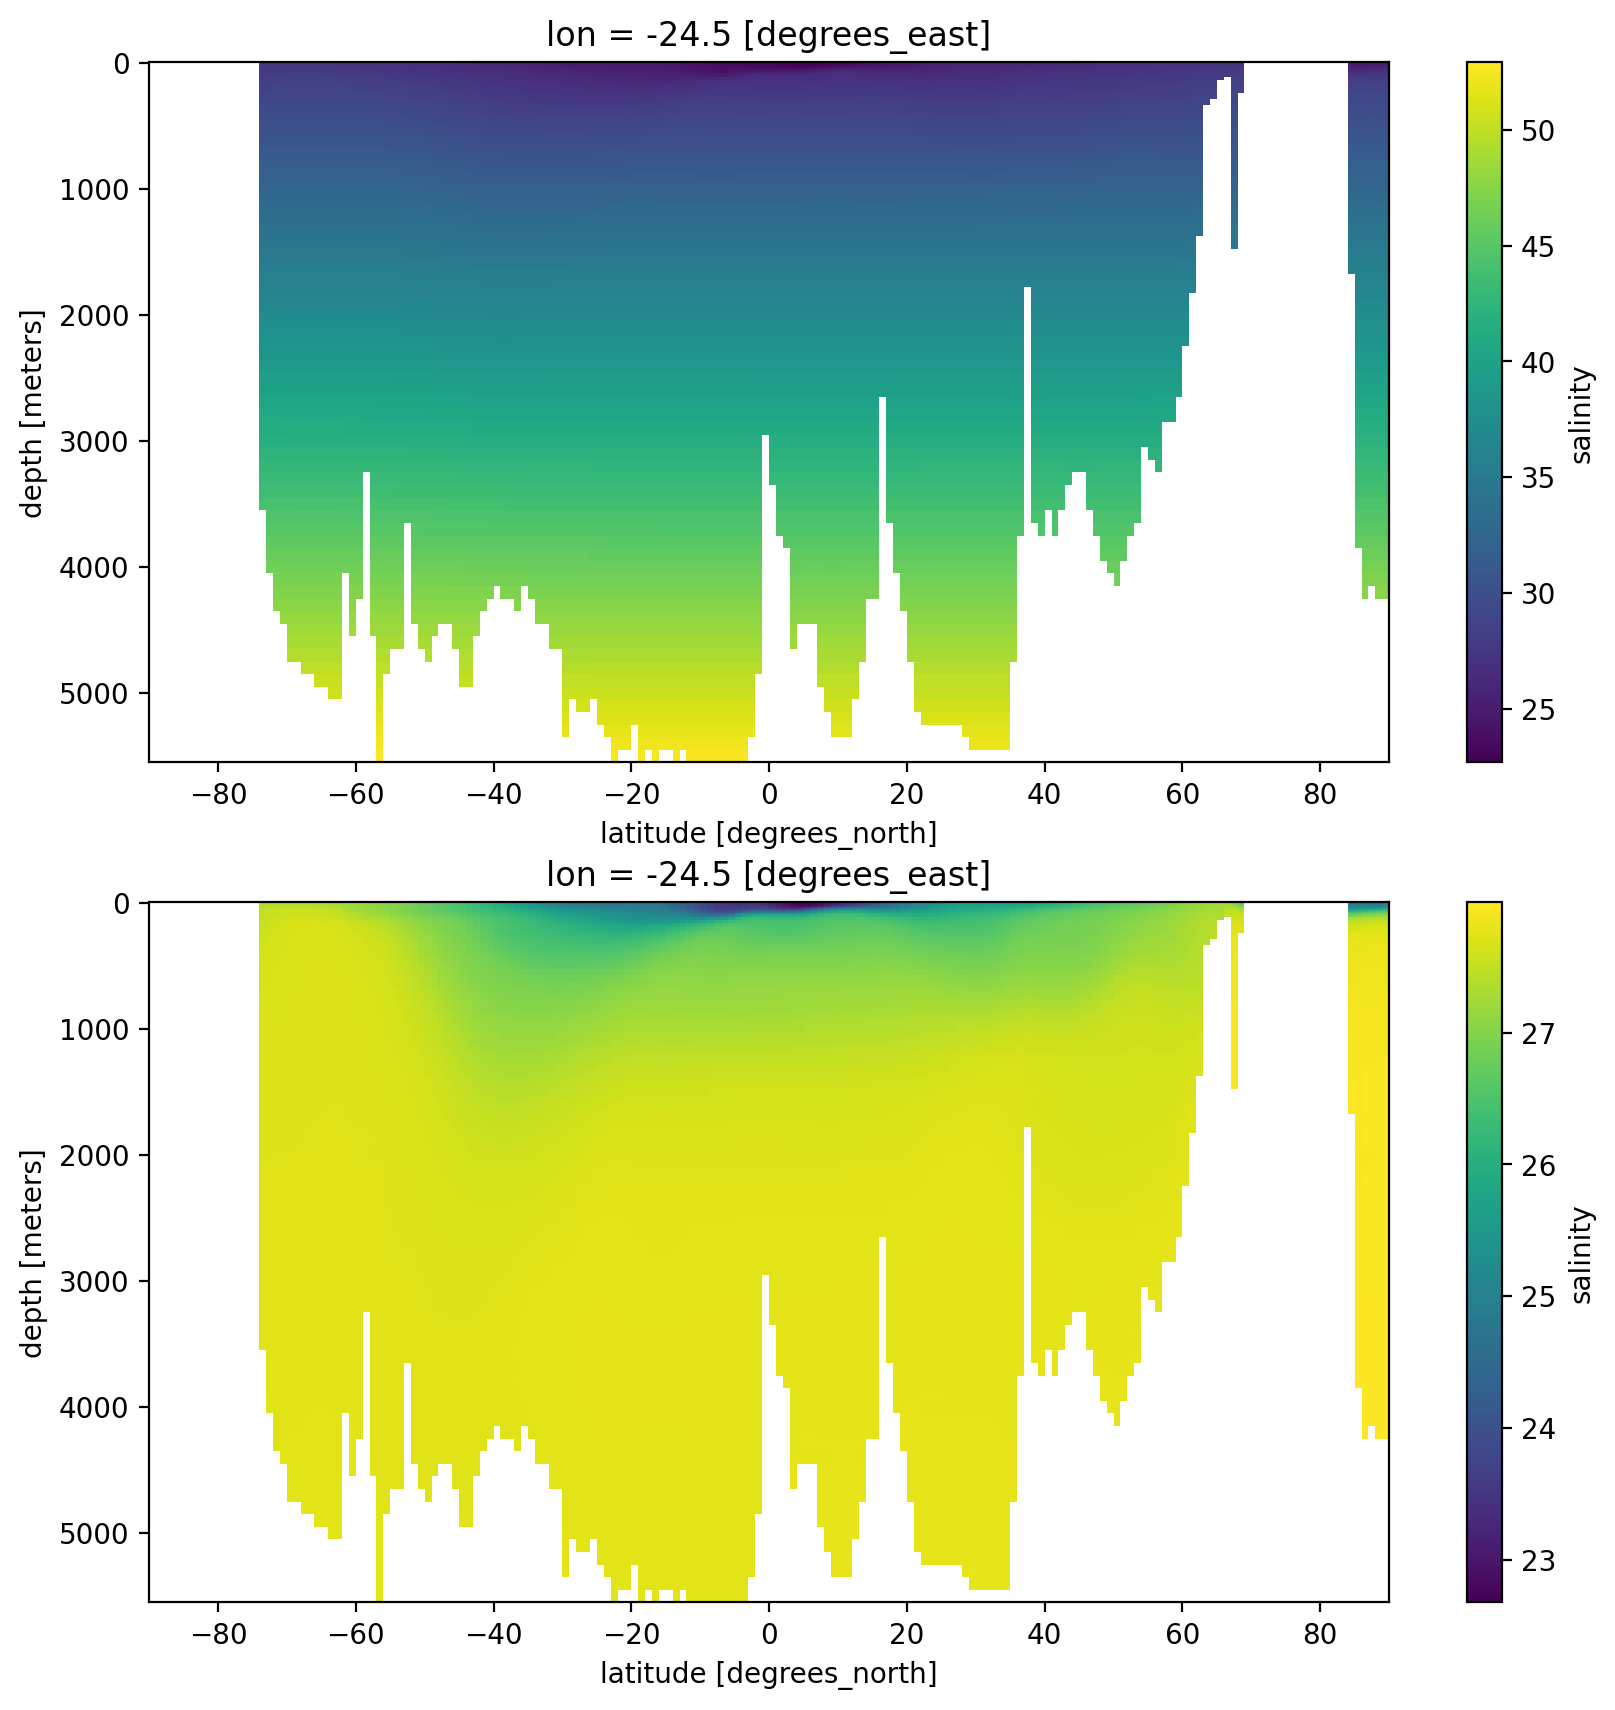

In [53]:
in_situ_den = gsw.rho(salt, temp,ds_pressure.pressure) - 1000
pot_den  = gsw.pot_rho_t_exact(salt,poto_temp,ds_pressure.pressure, p_ref)-1000


fig,(ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(10,10)) 

# Left subplot: your existing temperature vs depth plot
in_situ_den.sel(lon=-25,method='nearest').plot(ax=ax1,yincrease=False)
pot_den.sel(lon=-25,method='nearest').plot(ax=ax2,yincrease=False)



#### A. In the in-situ density the range is much larger than the potneial density (as seen in the previous question). From the influnce of pressure.
#### Another cool oberservation is that the in-situ denisty decreases in parrelell lines with depth. Which would lead to no horizonal gradeints. While the pot den has variation in the gradients of the dentisty lines which are particularly notibale in the mid latitudes at 1000m where the density increases toward the poles and the EQ. 



#### <font color=red> </font><br /><font color=red> Create another set of T and S diagrams but overlay your newly calculated potential density contours. Explain relationships observed.

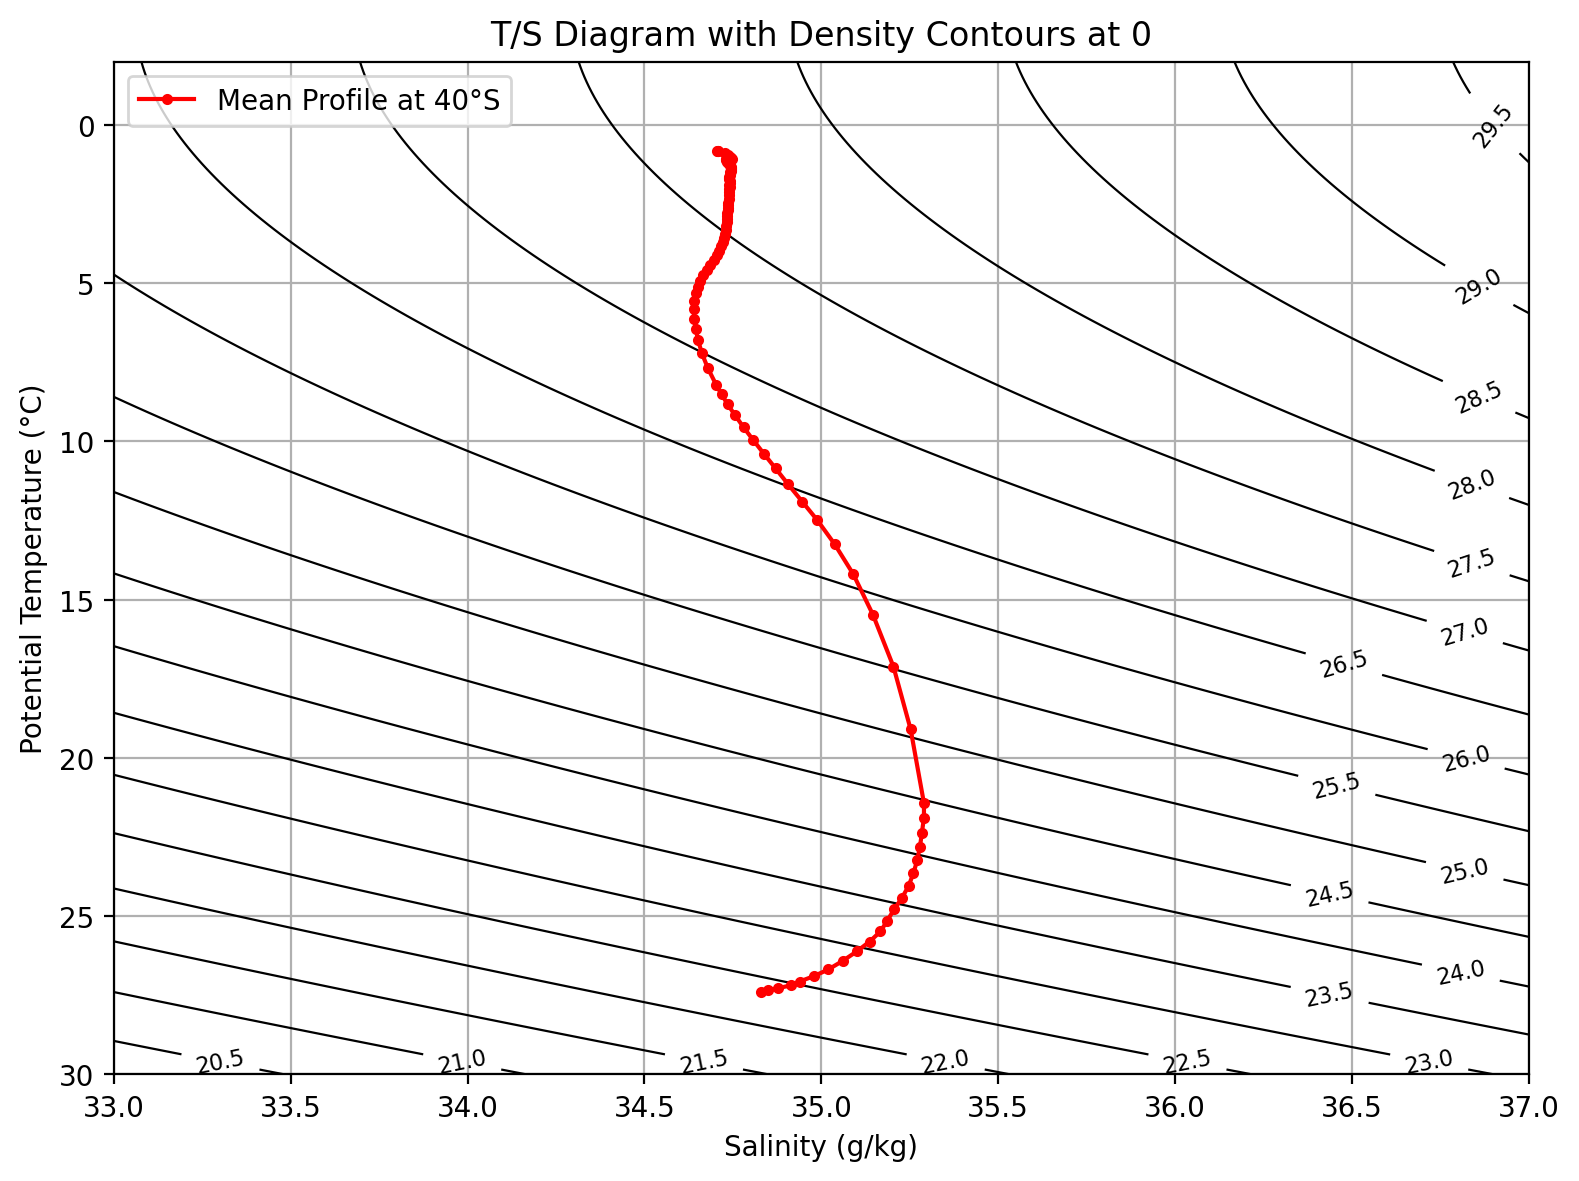

In [54]:
# Extract mean salinity and potential temperature at lat = -40, averaged over lon
# Make sure you have a 'salinity' variable, not poto_temp twice!
salt_eq2s = salt.sel(lat=-0, method='nearest').mean(dim='lon').values
poto_temp_eq2s = poto_temp.sel(lat=-0, method='nearest').mean(dim='lon').values

# Create a regular grid of salinity and temperature for density contours
S_grid, T_grid = np.meshgrid(np.linspace(33, 37, 200), np.linspace(-2, 30, 200))

# Calculate density on the grid (sigma0 = potential density anomaly)
sigma_grid = gsw.sigma0(S_grid.flatten(), T_grid.flatten()).reshape(S_grid.shape)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Density contours
contours = ax.contour(S_grid, T_grid, sigma_grid, levels=np.arange(20, 30.5, 0.5), colors='black', linewidths=0.8)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

# Overlay the T/S profile
ax.plot(salt_eq2s, poto_temp_eq2s, 'r.-', label='Mean Profile at 40°S')

# Labels and titles
ax.set_xlabel('Salinity (g/kg)')
ax.set_ylabel('Potential Temperature (°C)')
ax.set_title('T/S Diagram with Density Contours at 0')
ax.invert_yaxis()  # Oceanography convention: temperature increases downward
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

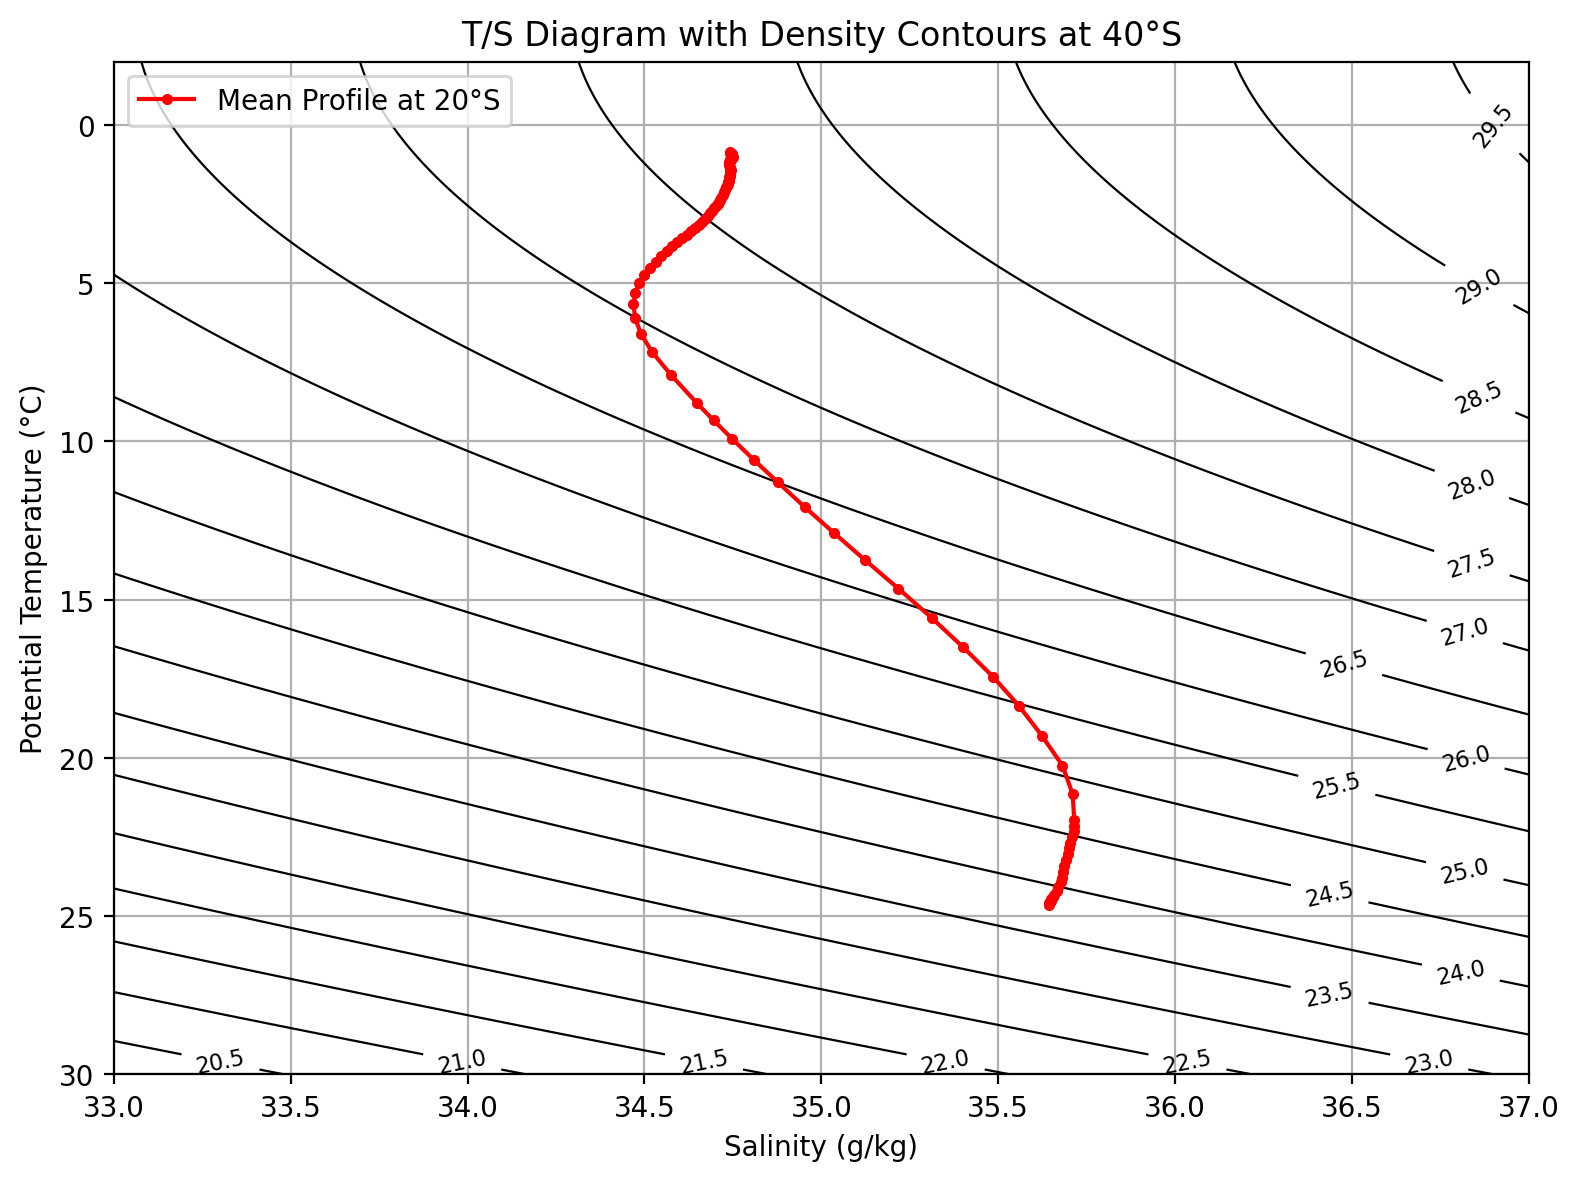

In [55]:

# Extract mean salinity and potential temperature at lat = -40, averaged over lon
# Make sure you have a 'salinity' variable, not poto_temp twice!
salt_eq2s = salt.sel(lat=-20, method='nearest').mean(dim='lon').values
poto_temp_eq2s = poto_temp.sel(lat=-20, method='nearest').mean(dim='lon').values

# Create a regular grid of salinity and temperature for density contours
S_grid, T_grid = np.meshgrid(np.linspace(33, 37, 200), np.linspace(-2, 30, 200))

# Calculate density on the grid (sigma0 = potential density anomaly)
sigma_grid = gsw.sigma0(S_grid.flatten(), T_grid.flatten()).reshape(S_grid.shape)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Density contours
contours = ax.contour(S_grid, T_grid, sigma_grid, levels=np.arange(20, 30.5, 0.5), colors='black', linewidths=0.8)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

# Overlay the T/S profile
ax.plot(salt_eq2s, poto_temp_eq2s, 'r.-', label='Mean Profile at 20°S')

# Labels and titles
ax.set_xlabel('Salinity (g/kg)')
ax.set_ylabel('Potential Temperature (°C)')
ax.set_title('T/S Diagram with Density Contours at 40°S')
ax.invert_yaxis()  # Oceanography convention: temperature increases downward
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


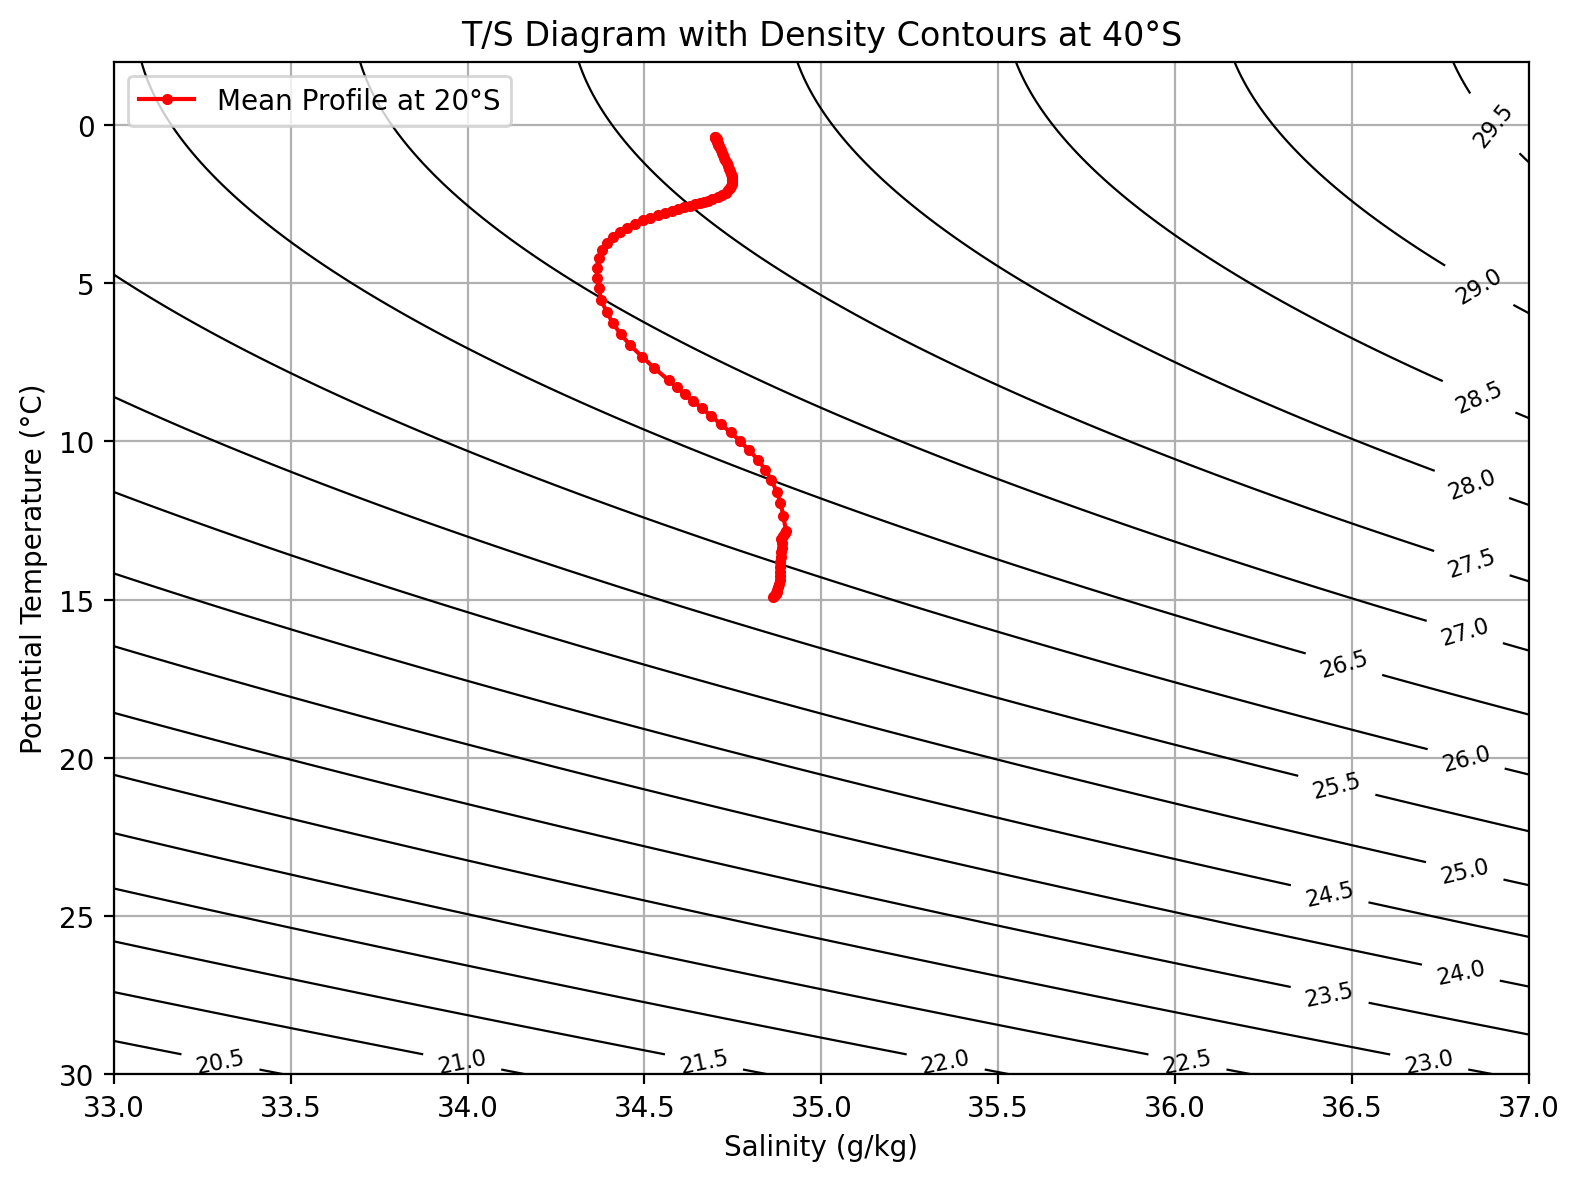

In [56]:

# Extract mean salinity and potential temperature at lat = -40, averaged over lon
# Make sure you have a 'salinity' variable, not poto_temp twice!
salt_eq2s = salt.sel(lat=-40, method='nearest').mean(dim='lon').values
poto_temp_eq2s = poto_temp.sel(lat=-40, method='nearest').mean(dim='lon').values

# Create a regular grid of salinity and temperature for density contours
S_grid, T_grid = np.meshgrid(np.linspace(33, 37, 200), np.linspace(-2, 30, 200))

# Calculate density on the grid (sigma0 = potential density anomaly)
sigma_grid = gsw.sigma0(S_grid.flatten(), T_grid.flatten()).reshape(S_grid.shape)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Density contours
contours = ax.contour(S_grid, T_grid, sigma_grid, levels=np.arange(20, 30.5, 0.5), colors='black', linewidths=0.8)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

# Overlay the T/S profile
ax.plot(salt_eq2s, poto_temp_eq2s, 'r.-', label='Mean Profile at 20°S')

# Labels and titles
ax.set_xlabel('Salinity (g/kg)')
ax.set_ylabel('Potential Temperature (°C)')
ax.set_title('T/S Diagram with Density Contours at 40°S')
ax.invert_yaxis()  # Oceanography convention: temperature increases downward
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


#### In the diagrams it can be seen that a similar denisty range can be made from different T and s points. As temp has a larger range the density seems to be greatly influnce by the temp. It is more clear to see the differnt water masses in with the contours.

#### <font color=red> </font><br /><font color=red> For a __single location__ plot profiles of potential density referenced to __different pressure levels__ what do you notice?

Text(0.5, 1.0, 'p=4000')

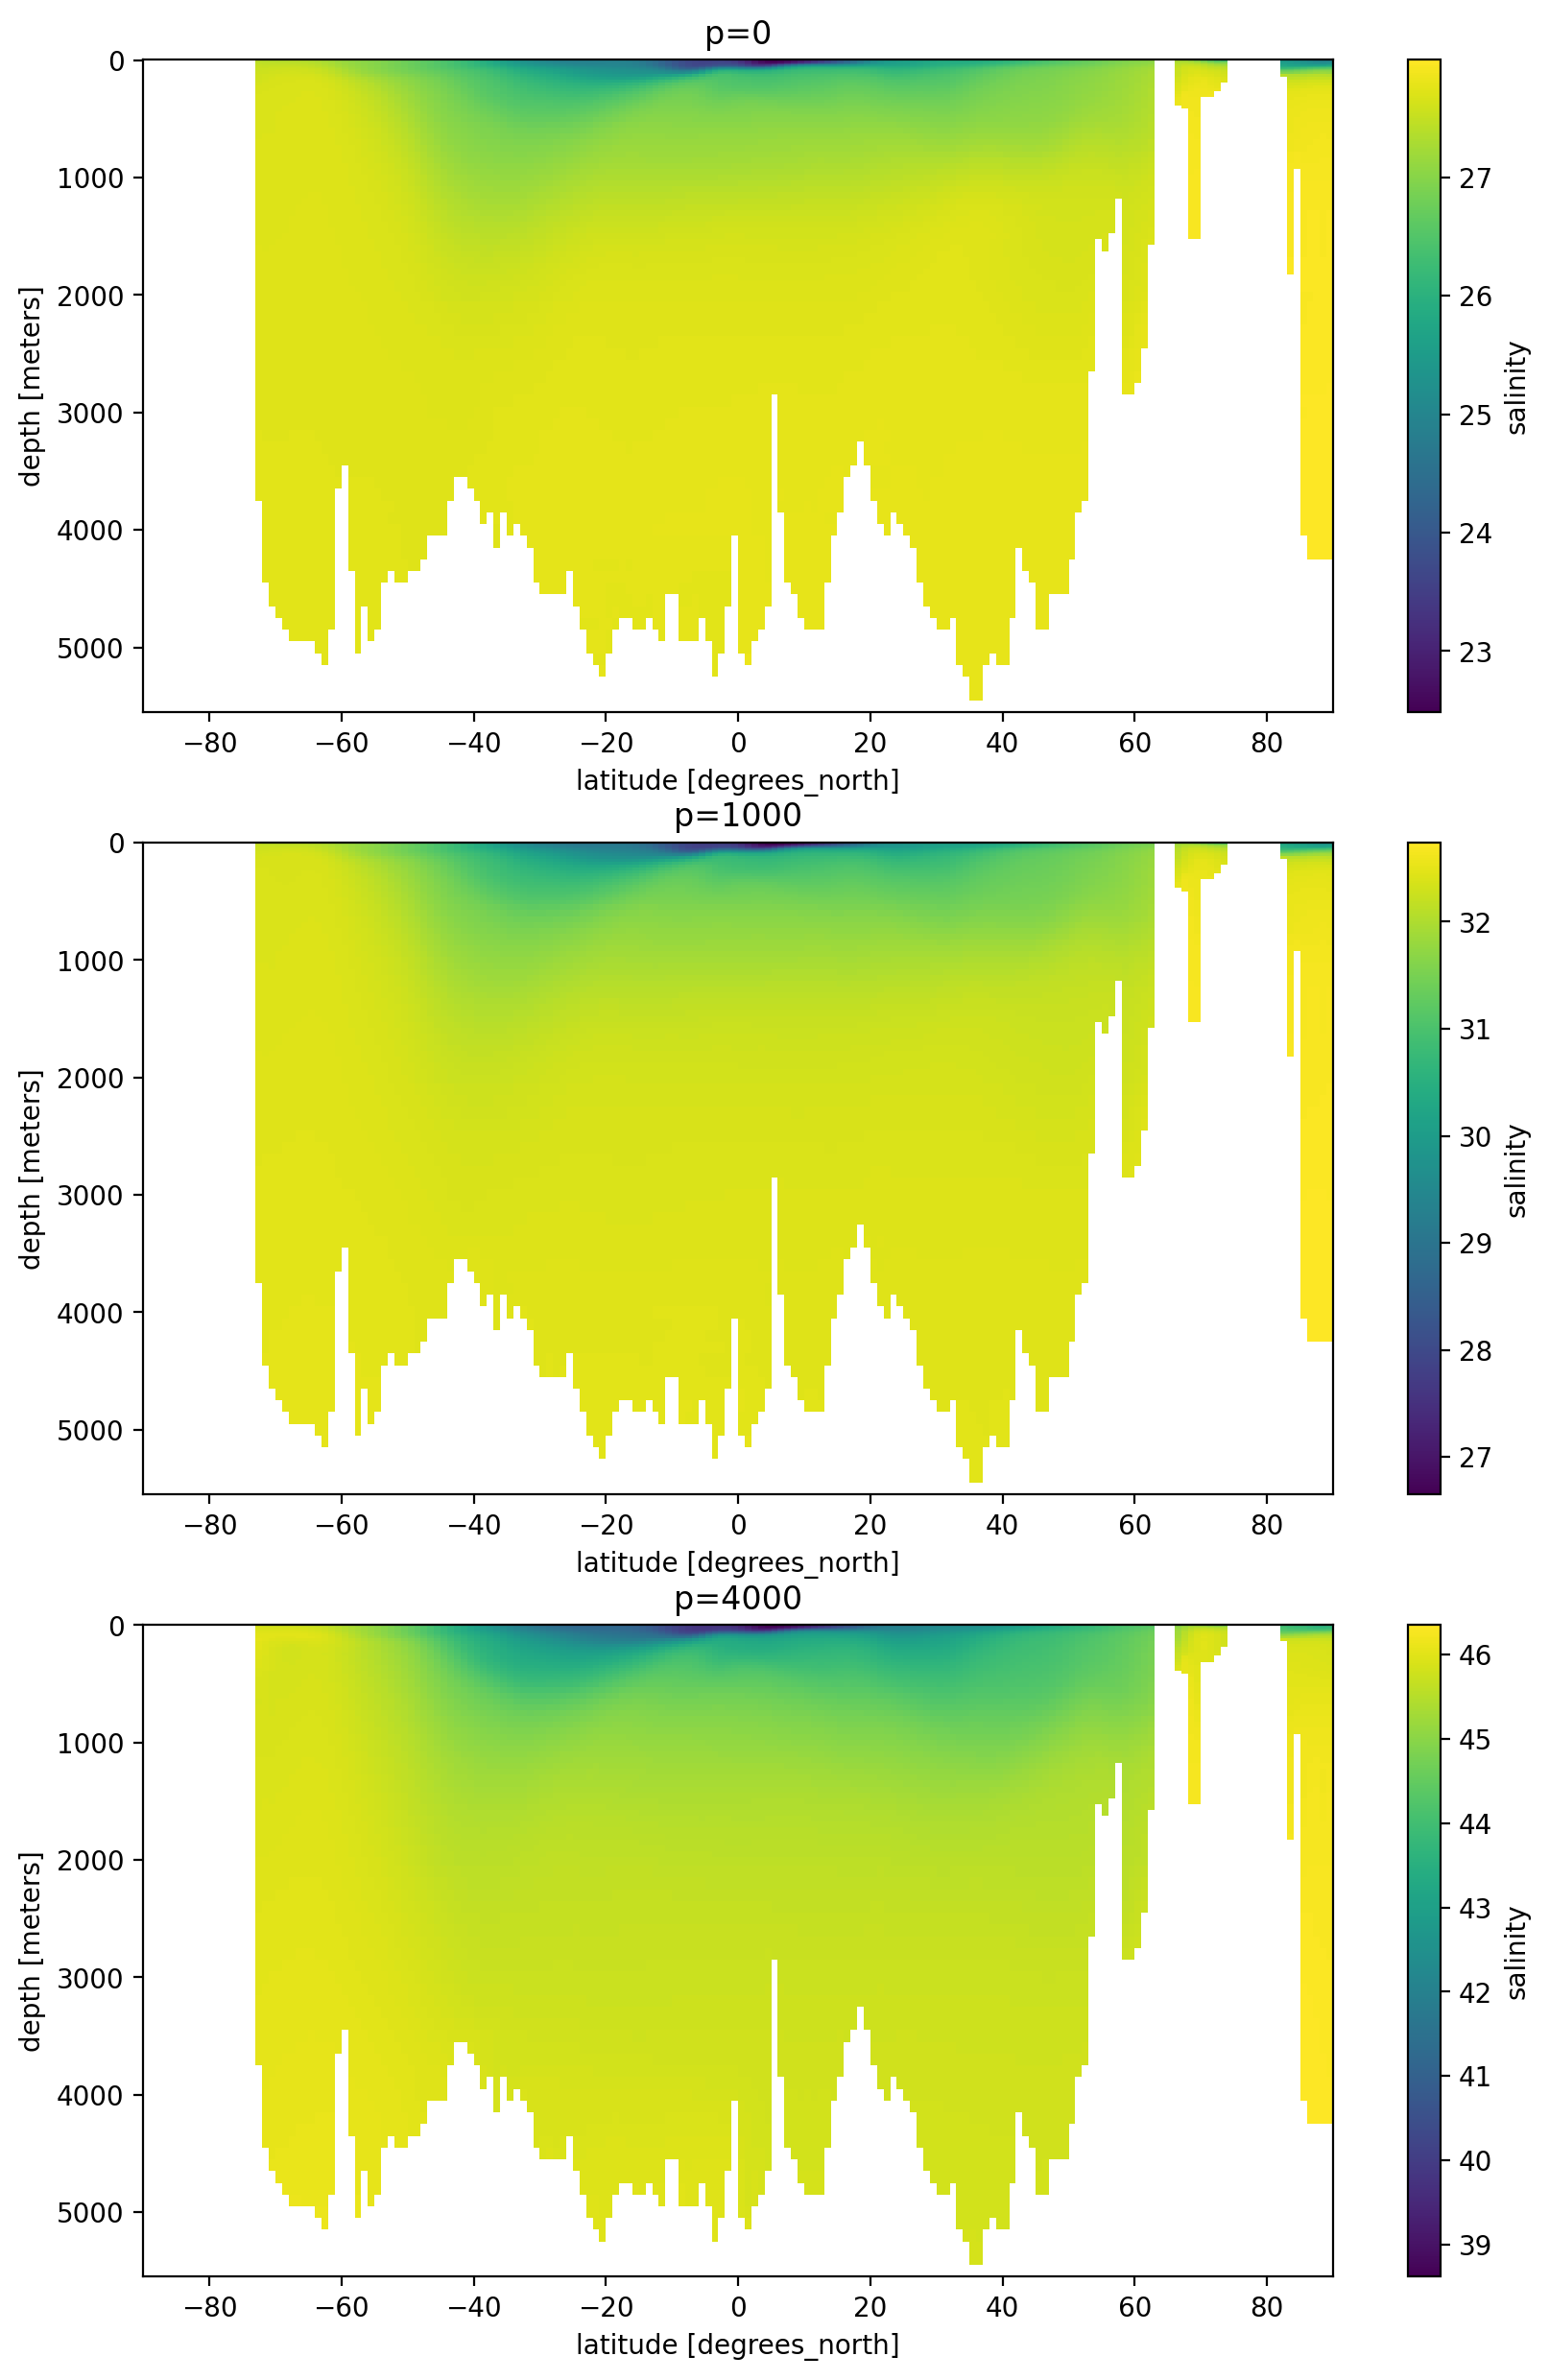

In [70]:
pot_den0  = gsw.pot_rho_t_exact(salt,poto_temp,ds_pressure.pressure, 0)-1000

pot_den1  = gsw.pot_rho_t_exact(salt,poto_temp,ds_pressure.pressure, 1000)-1000

pot_den2  = gsw.pot_rho_t_exact(salt,poto_temp,ds_pressure.pressure, 4000)-1000


fig,(ax1, ax2, ax3)= plt.subplots(nrows=3, ncols=1, figsize=(10,15)) 

# Left subplot: your existing temperature vs depth plot
pot_den0.sel(lon=-20,method='nearest').plot(ax=ax1,yincrease=False)
pot_den1.sel(lon=-20,method='nearest').plot(ax=ax2,yincrease=False)
pot_den2.sel(lon=-20,method='nearest').plot(ax=ax3,yincrease=False)

ax1.set_title("p=0")
ax2.set_title("p=1000")
ax3.set_title("p=4000")

#### When the reference level is lower there is more denisty resoulstion in around that level. When the surface is the reference level there is a higher resoultion at the surface.

#### <font color=red> </font><br /><font color=red> Make a few cross-sections of potential density referenced to different levels at 26 N in the Atlantic, what are the benefits of choosing one reference level over another?

Text(0.5, 1.0, 'p=4000')

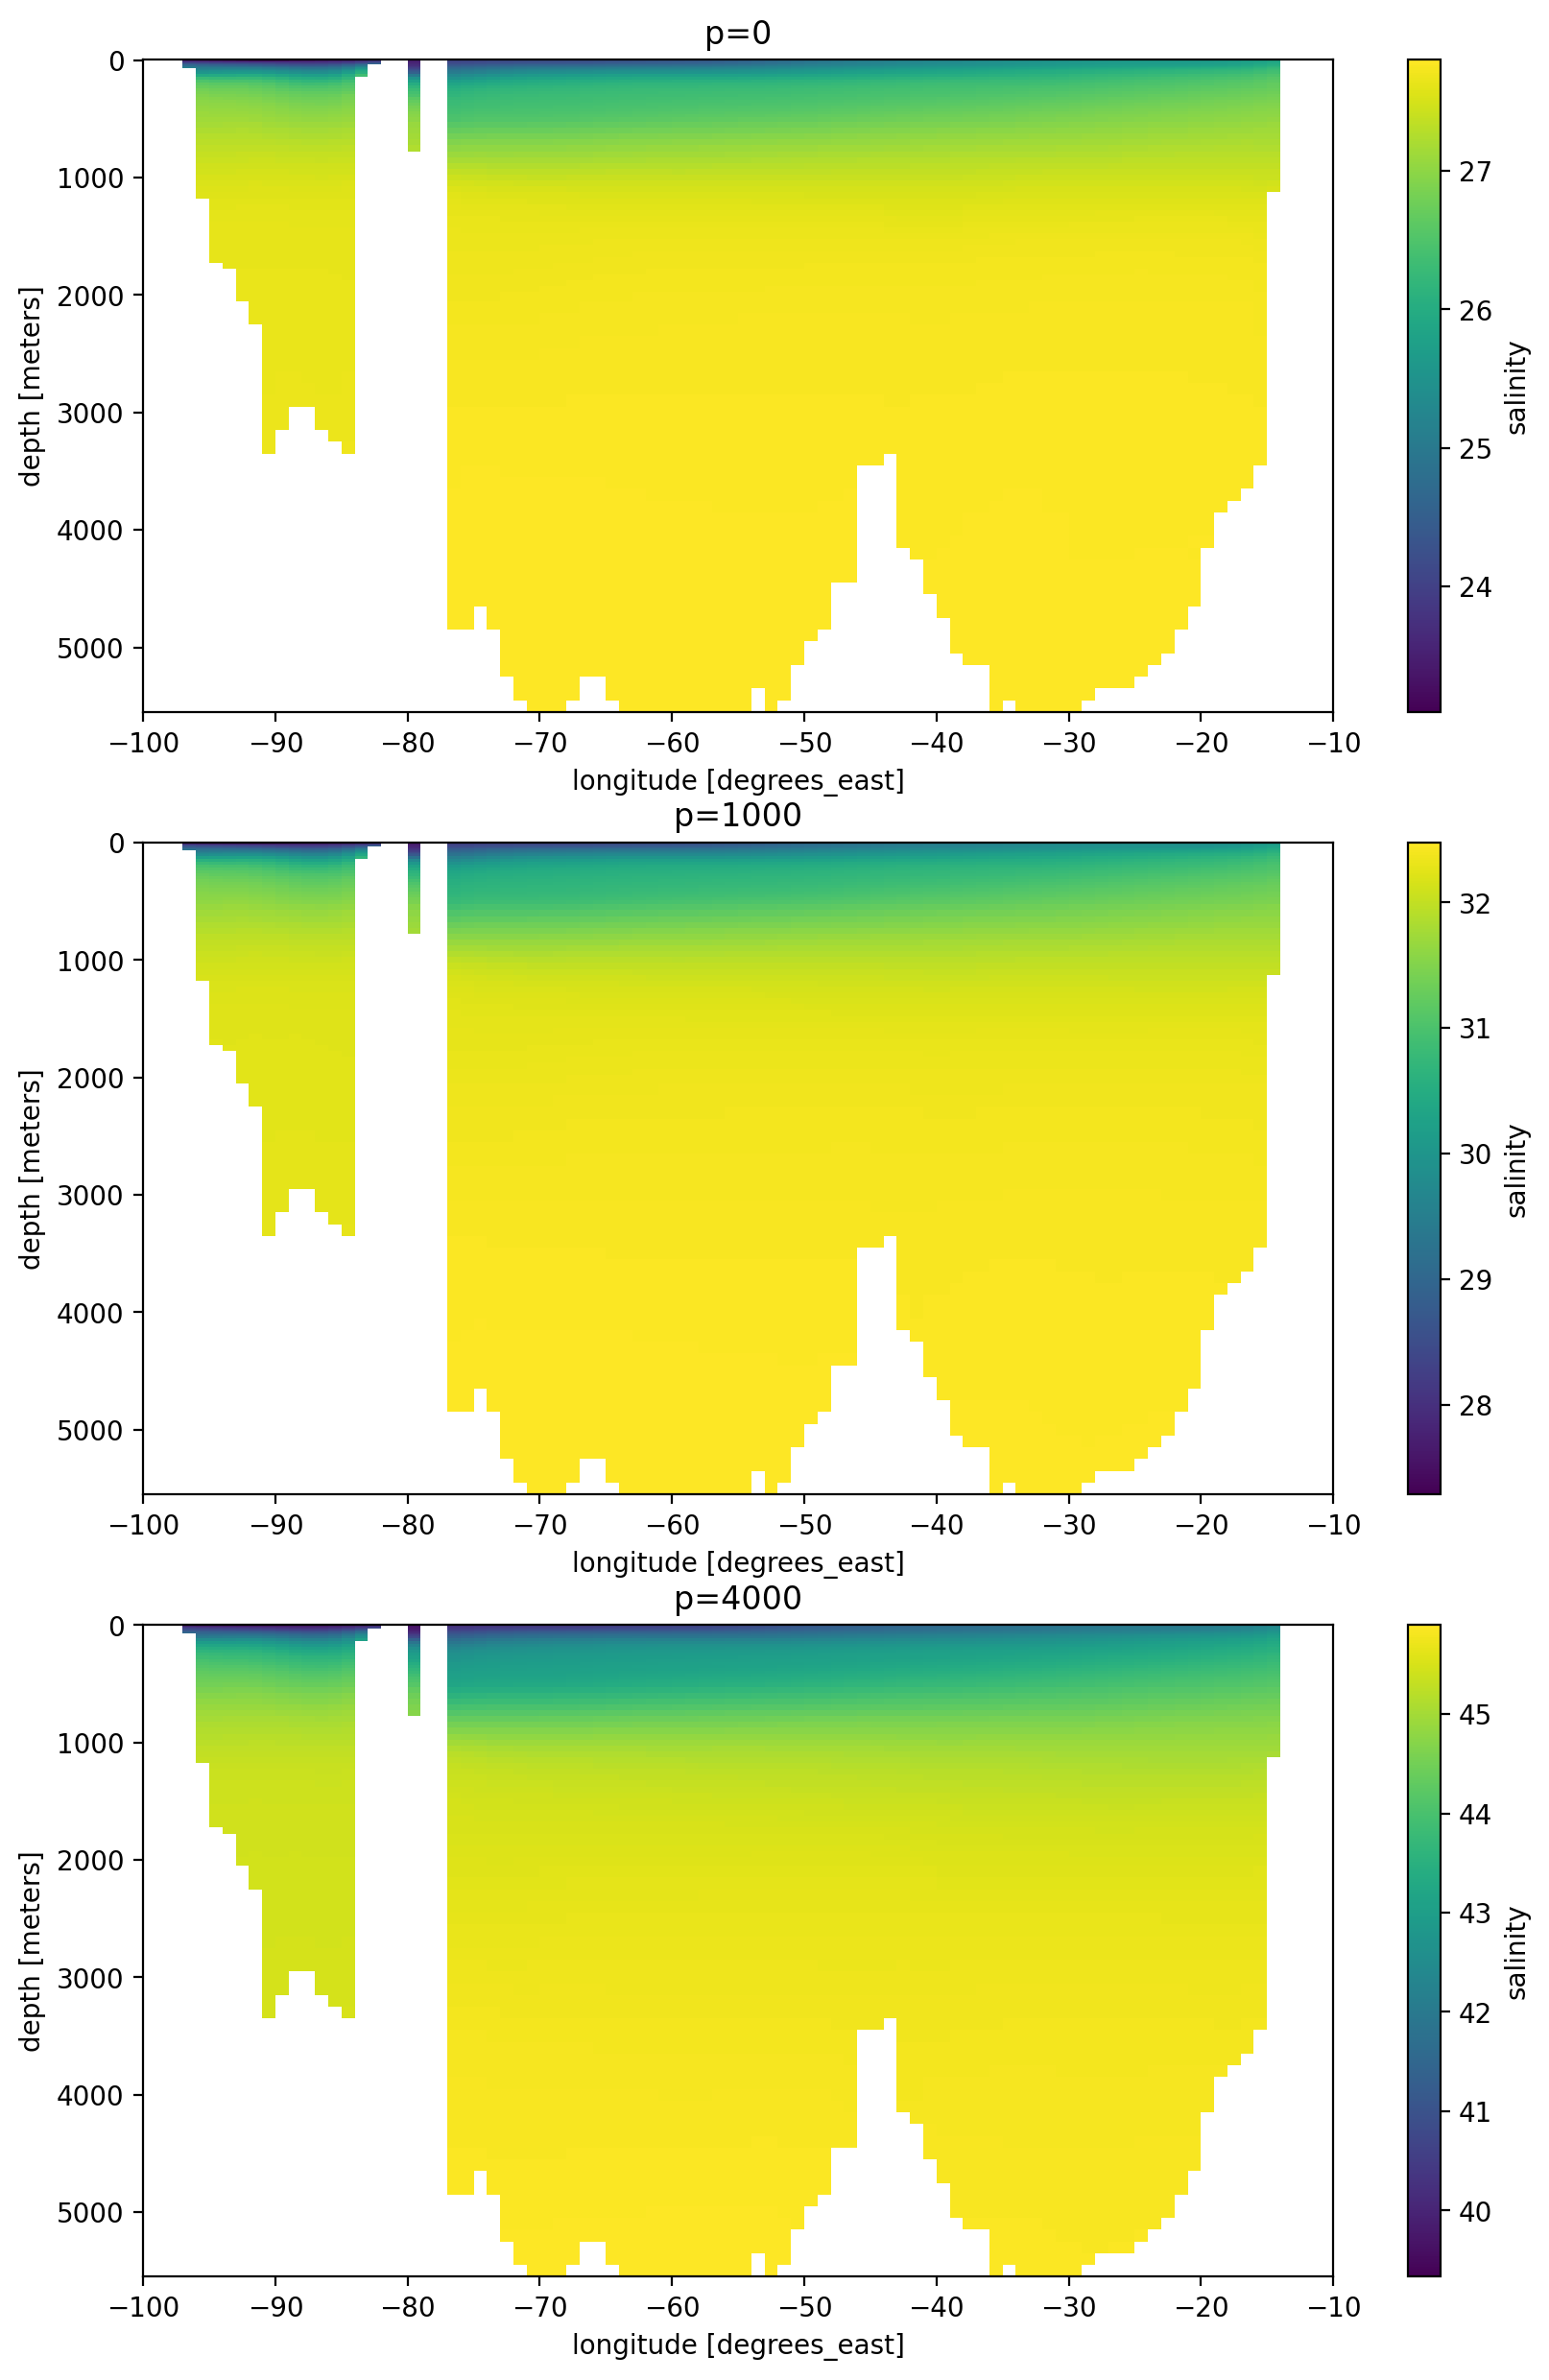

In [72]:
pot_den0  = gsw.pot_rho_t_exact(salt,poto_temp,ds_pressure.pressure, 0)-1000

pot_den1  = gsw.pot_rho_t_exact(salt,poto_temp,ds_pressure.pressure, 1000)-1000

pot_den2  = gsw.pot_rho_t_exact(salt,poto_temp,ds_pressure.pressure, 4000)-1000


fig,(ax1, ax2, ax3)= plt.subplots(nrows=3, ncols=1, figsize=(10,15)) 

# Left subplot: your existing temperature vs depth plot
pot_den0.sel(lat=26,method='nearest').sel(lon=slice(-100,-10)).plot(ax=ax1,yincrease=False)
pot_den1.sel(lat=26,method='nearest').sel(lon=slice(-100,-10)).plot(ax=ax2,yincrease=False)
pot_den2.sel(lat=26,method='nearest').sel(lon=slice(-100,-10)).plot(ax=ax3,yincrease=False)

ax1.set_title("p=0")
ax2.set_title("p=1000")
ax3.set_title("p=4000")

#### If looking for surface features the p ref level best suited will be 0. If looking for subsurface features the 1000 p rer is best. If looking for bottom ocean features the 4000 may be best